<a href="https://colab.research.google.com/github/jonasbarth/nnds-2023-final-project/blob/main/NNDS_2023_Final_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *Jonas Barth*

**Matricola**: *2050678*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

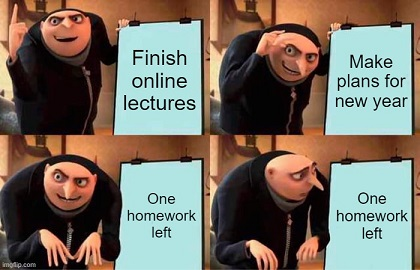

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

## Project Goal
The idea of the project is to first fine-tune a VGG16 on a binary satellite image classification on images that either contain ships or not using classic gradient based optimisation of the final prediction layers, and then use Low Rank Adaptation (LoRa) to transfer the learned features onto a second binary satellite image classification of images that contain planes or not.

The reason for first fine-tuning the VGG16 on the airplane dataset is due to the fact that the base VGG16 has 1000 classes but my target ship and airplane dataset only 2. Since LoRa aims to learn a low rank approximation of the weights, and due to the limited data it is only feasible to retrain the final VGG16 layers, the weight matrix that I approximate should not change shape between the original model and transfer model.

## Datasets

### Airplanes
The airplanes dataset taken from [Kaggle](https://www.kaggle.com/datasets/rhammell/planesnet) is a binary classification of satellite images collected over multiple airports in California. It includes 32,000 20x20 RGB images labeled with either a "plane" (class 1) or "no-plane" (class 0) classification.

No Plane Patch             |  Plane Patch
:-------------------------:|:-------------------------:
<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/data/planes/example_patches/example_patch_no_plane.png?raw=1" width="200">|<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/data/planes/example_patches/example_patch_plane.png?raw=1" width="200">
3000 samples | 1000 samples
 

### Ships
The ship dataset contains a binary ship classification of satellite images from the San Francisco and San Pedro Bay, taken from [Kaggle](https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery). The dataset contains 4000 RGB sub patches of size 80x80 with a 3 meter pixel resolution, taken from 8 satellite images. Each patch either contains a ship (class 1) or not (class 0). Out of 4000 images, 1000 belong to class 1 (ship) and 3000 belong to class 0 (no ship).

No Ship Patch             |  Ship Patch
:-------------------------:|:-------------------------:
<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/data/ships/example_patches/example_patch_no_ship.png?raw=1" width="200">|<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/data/ships/example_patches/example_patch_ship.png?raw=1" width="200">
3000 samples | 1000 samples

Hence, the goal is to train a model to distinguish between these two classes.

### Metadata Creation
Each image file name in both datasets contains information about the class, scene ID, longitude and latitude in the following format:
```
<label>_<scene id>_<longitude>_<latitude>.png
```

To ease the data loading for the model later, I will parse this information into a pandas dataframe with two columns:

label | file_name
:----:|:----:
1 | 0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png
. | .
. | .
. | .
. | .

That way, each file can easily be associated with its label. To do this, I will iterate over the image file names in the `data/shipsnet` directory, extract the label and store it as list inside a list. Each sublist will be a row in the dataframe later.

### Download Data
I have provided my own zip files on an AWS Bucket that contain both datasets.

In [9]:
import os
import requests
import zipfile

def download_and_unzip(url: str, zip_file_path: str, extract_folder_path: str):
    """Downloads and extracts the zip data for the project.

    Args:
        url (str): the url from which to GET the zip.
        zip_file_path (str): path where to save the zip file.
        extract_folder_path (str): folder where to extract the zip.
    """
    # Download the zip file
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Save the downloaded zip file
        with open(zip_file_path, "wb") as f:
            f.write(response.content)

        # Extract the contents of the zip file into the data folder
        with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
            zip_ref.extractall(extract_folder_path)

        print("Zip file downloaded and extracted successfully.")
    else:
        print("Failed to download the zip file.")

Let's download both datasets from the AWS bucket into the `data/` directory.

In [ ]:
planes_url = "https://nnds-2023.s3.eu-north-1.amazonaws.com/planes.zip"
ships_url = "https://nnds-2023.s3.eu-north-1.amazonaws.com/ships.zip"

planes_zip_path = "planes.zip"
ships_zip_path = "ships.zip"

# Define the path where you want to extract the contents of the zip file
extracted_folder_path = "data"

# Create the data folder if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

download_and_unzip(ships_url, ships_zip_path, extracted_folder_path)
download_and_unzip(planes_url, planes_zip_path, extracted_folder_path)

In [4]:
import os
import pandas as pd

def get_dataset_metadata(images_path: str):
    """Gets filenames and labels of the data found at the given path.

    Args:
        images_path (str): the directory where the image files are stored.

    Returns:
        pd.DataFrame: a pandas dataframe with columns ["label", "file_name"].
    """
    meta_data = []

    # list all the image files
    for image_file in os.listdir(images_path):

        # the class label is always the first character of the file name
        label = image_file[0]
        meta_data.append([int(label), os.path.join(images_path, image_file)])

    meta_data = pd.DataFrame(meta_data, columns=["label", "file_name"])
    return meta_data

Create the metadata pandas dataframes.

In [5]:
planes_metadata = get_dataset_metadata("data/planes/planesnet")
ships_metadata = get_dataset_metadata("data/ships/shipsnet")

image_size = (80, 80)

I want to be able to utilise the TensorFlow dataset utility, which let's you create an image dataset by providing a folder name. For this, I need to split the image data into **train** and **test** first.

In [6]:
from pathlib import Path
import shutil

def create_train_test(data: pd.DataFrame, train_size: float):
    """Creates train and test splits for the given image data.

    The function creates a train and test directory one directory above the images.

    Args:
        data (pd.DataFrame): the dataframe with the image data information. Should contain columns: label, file_name.
        train_size (float): the percentage of training examples.

    Returns:
        X_train (list): the list of images in the training dataset.
        X_test (list): the list of images in the test dataset.
        y_train (list): the labels of the training dataset, matches the order of X_train.
        y_test (list): the labels of the test dataset, matches the order of X_test.
    """
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(data.file_name, data.label, train_size=train_size)

    # create the train and test paths
    images_dir = os.path.split(X_train.iloc[0])[0]
    images_parent_dir = os.path.split(images_dir)[0]
    train_path = os.path.join(images_parent_dir, "train")
    test_path = os.path.join(images_parent_dir, "test")

    train_path = Path(train_path)
    test_path = Path(test_path)

    # if the train/test directories already exist, we want to delete them
    if train_path.exists():
        shutil.rmtree(train_path)

    if test_path.exists():
        shutil.rmtree(test_path)

    # create the train and test directories
    train_path.mkdir(exist_ok=False, parents=True)
    test_path.mkdir(exist_ok=False, parents=True)

    train_paths = list(map(lambda image: os.path.join(train_path, image), map(lambda image_path: os.path.split(image_path)[-1], X_train)))
    # replace all dots except for the extension because Tensorflow thinks the first . in the filename marks the extension.
    train_paths = list(map(lambda image_path: replace_dots(image_path, "#"), train_paths))

    test_paths = list(map(lambda image: os.path.join(test_path, image), map(lambda image_path: os.path.split(image_path)[-1], X_test)))
    test_paths = list(map(lambda image_path: replace_dots(image_path, "#"), test_paths))

    # copy over the files
    for original_path, dest_path in zip(X_train, train_paths):
        shutil.copy(original_path, dest_path)

    for original_path, dest_path in zip(X_test, test_paths):
        shutil.copy(original_path, dest_path)

    return X_train, X_test, y_train.to_list(), y_test.to_list()


def replace_dots(path: str, replacement: str):
    """Replace the . with a replacement string, without breaking the extension.

    Args:
        path (str): the path string of which we take the file and replace . with the replacement.
        replacement (str): the character with which to replace the .

    Returns:
        (str) the full path with the . replaced but extension kept intact.
    """
    path, file = os.path.split(path)
    ext = os.path.splitext(file)[-1]
    file = file.replace(".", replacement)
    file = file.replace(f"{replacement}{ext[1:]}", f"{ext}")
    return os.path.join(path, file)

Let's finally load the train and test sets for the ships and planes dataset, using an `80/20` split.

In [7]:
X_train_ships, X_test_ships, y_train_ships, y_test_ships = create_train_test(ships_metadata, 0.8)
X_train_planes, X_test_planes, y_train_planes, y_test_planes = create_train_test(planes_metadata, 0.8)

### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

## Traditional Finetuning
I will use a **VGG16** for this project. The reason for choosing this now "outdated" architecture over the widely adopted **ResNet** is that the VGG16 has more fully connected layers to which Lora can be applied more easily. Usually when doing transfer learning with a ConvNet, the earlier convolutional layers are frozen since the features that they extract from images are very reusable. Only the deeper fully connected layers are retrained. Here I will do the same.

<img src="https://github.com/jonasbarth/nnds-2023-final-project/blob/main/images/vgg16_architecture.png?raw=1" width="750">

### Ship Images Finetuning (Traditional)
First, I will finetune a VGG16 on the ship dataset using the traditional gradient based method where only the final fully connected layers are retrained.

#### Create TF Datasets
Let's create the two datasets that we will be using with the help of the `keras.utils` package, both with a validation split of $0.2$. First the ships.

In [8]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32

ship_train, ship_val = tf.keras.utils.image_dataset_from_directory(directory="data/ships/train", labels=y_train_ships, validation_split=0.2, subset="both", seed=0, image_size=image_size, shuffle=True, batch_size=batch_size)
ship_test = tf.keras.utils.image_dataset_from_directory(directory="data/ships/test", labels=y_test_ships, seed=0, image_size=image_size, shuffle=True, batch_size=batch_size)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.
Using 640 files for validation.
Found 800 files belonging to 2 classes.


Then for the planes.

In [9]:
planes_train, planes_val = tf.keras.utils.image_dataset_from_directory(directory="data/planes/train", labels=y_train_planes, validation_split=0.2, subset="both", seed=0, image_size=image_size, shuffle=True, batch_size=batch_size)
planes_test = tf.keras.utils.image_dataset_from_directory(directory="data/planes/test", labels=y_test_planes, seed=0, image_size=image_size, shuffle=True, batch_size=batch_size)

Found 25600 files belonging to 2 classes.
Using 20480 files for training.
Using 5120 files for validation.
Found 6400 files belonging to 2 classes.


### Load Model
Here, we load the pretrained VGG16 model, but **without** the final connected layers, since we want to fine tune those ourselves.

In [10]:
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(*image_size, 3))

### Create Prediction Head
Here we create the prediction layers. These are the **same** as the original VGG16 architecture, apart from the final dense layer that now performs **binary classification** instead of **1000-way**.

In [11]:
flatten = tf.keras.layers.Flatten()(vgg16.output)
regulariser = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
fc1 = tf.keras.layers.Dense(4096, activation="relu", kernel_regularizer=regulariser)(flatten)
fc2 = tf.keras.layers.Dense(4096, activation="relu", kernel_regularizer=regulariser)(fc1)

# add the new prediction head for binary classification
pred = tf.keras.layers.Dense(1, kernel_regularizer=regulariser)(fc2)

In [15]:
custom_vgg16 = tf.keras.models.Model(inputs=vgg16.input, outputs=pred)

Since we only want to train the final fully connected layers, freeze all previous layers by setting the `trainable` attribute to `False`.

In [16]:
custom_vgg16.trainable = True
for layer in custom_vgg16.layers[:-4]:
    layer.trainable = False

## Create Preprocessing Layers
We want our images to be standardised with zero mean and standard deviation of one. Hence, we will inject a preprocessing layer into the model that does this for us.

In [14]:
# Add the rescaling layer as the first layer of the model
inputs = tf.keras.Input(shape=(*image_size, 3))
x = tf.keras.layers.Rescaling(scale=1./255)(inputs)
outputs = custom_vgg16(x)

# Create the final model
final_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [17]:

# Calculate the number of batches per epoch
import math
n_batches = len(ship_train) / batch_size
n_batches = math.ceil(n_batches)

In [18]:
import datetime

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "checkpoints/vgg16-cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
Path(checkpoint_dir).mkdir(exist_ok=True, parents=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.005)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_freq='epoch', period=5)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Compile our custom VGG16 model with the binary prediction head, tracking the accuracy of the predictions.

In [19]:
custom_vgg16.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=0.01),
                    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

And fit it with the **ship data**.

In [ ]:
custom_vgg16_history = custom_vgg16.fit(ship_train, epochs=50, validation_data=ship_val, batch_size=batch_size, callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb], verbose=1)

Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 362.1064 - accuracy: 0.6547

In [13]:
custom_vgg16.save_weights("vgg16_ships.ckpt")

## Evaluation
Let's see how our first finetuned model did, by plotting the train and validation loss and accuracy curves.

In [14]:
train_loss, val_loss = custom_vgg16_history.history["loss"], custom_vgg16_history.history["val_loss"]
train_accuracy, val_accuracy = custom_vgg16_history.history["accuracy"], custom_vgg16_history.history["val_accuracy"]

NameError: name 'custom_vgg16_history' is not defined

Looking at the accuracy curves, we see that already after 10 episodes, we have a training accuracy of 90%. The validation does not track the training however, indicating we are overfitting.

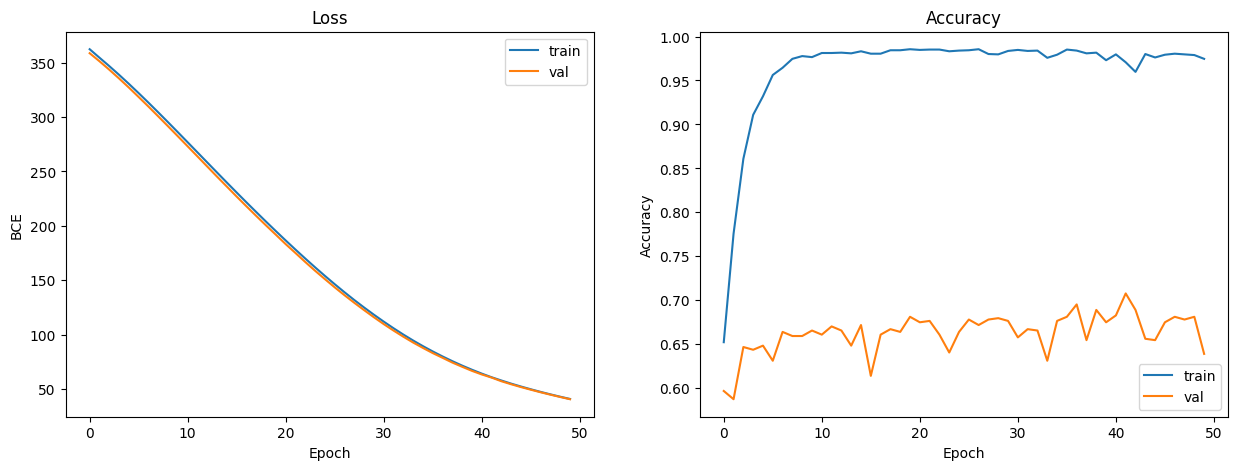

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_loss, label="train")
ax[0].plot(val_loss, label="val")
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("BCE")
ax[0].legend()

ax[1].plot(train_accuracy, label="train")
ax[1].plot(val_accuracy, label="val")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

But let's compare how the model does on the ship test set and on the planes test set **before** we apply LoRA. We see that our vgg16 finetuned on the ships, performs already almost similarly on the planes data. After LoRA, we should hopefully pull the accuracy on the planes data to the ship data.

In [15]:
custom_vgg16.evaluate(ship_test), custom_vgg16.evaluate(planes_test)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

## LoRA Finetuning
**Lo**w **R**ank **A**daption is a finetuning method that trains a lower rank representation $BA$ of the original weight matrix $W$. This works because the **rank** of the full weight matrix is usually lower than its **dimensions**, meaning that the information it carries can be encoded with fewer dimensions. Thanks to this, we can train much smaller weight matrices and be more efficient when it comes to large models. The VGG16 is not a particularly large model, but it will still be of benefit here because the largest portion of weights are in the later fully connected layers.

$$
W \in \mathbb{R}^{d \times k} \\
A \in \mathbb{R}^{r \times k} \\
B \in \mathbb{R}^{d \times r} \\
$$

I will apply LoRA to the final fully connected previously finetuned layers of the VGG16. The forward pass $h$ of the model is modified to use the lower rank representation of the matrix, so that we can propagate the loss back through them later.

$$
h = W_0x + \Delta Wx = W_0x + BAx
$$

Initially, we want $\Delta Wx$ to be $0$, hence, we initialise

$$
B = 0 \\
A \sim \mathcal{N}(0, 1)
$$

In [17]:
latest = tf.train.latest_checkpoint("checkpoints")

custom_vgg16.load_weights("vgg16_ships.ckpt.index")

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


AssertionError: Some objects had attributes which were not restored: 
    <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
          -9.43124294e-02, -5.05662560e-01, -3.83694321e-01],
         [-6.51455522e-02, -1.54351532e-01, -1.38038069e-01, ...,
          -1.29404560e-01, -4.62243795e-01, -3.23985279e-01]]],


       [[[ 2.74769872e-01,  1.48350164e-01,  1.61559835e-01, ...,
          -1.14316158e-01,  3.65494519e-01,  3.39938998e-01],
         [ 3.45739067e-01,  3.10493708e-02,  2.40750551e-01, ...,
          -6.93419054e-02,  4.37116861e-01,  4.13171440e-01],
         [ 3.10477257e-01, -1.87601492e-01,  1.66595340e-01, ...,
          -9.88388434e-02,  4.04058546e-01,  3.92561197e-01]],

        [[ 3.86807770e-02,  2.02298447e-01,  1.56414255e-01, ...,
          -5.20089604e-02,  2.57149011e-01,  3.71682674e-01],
         [ 4.06322069e-02,  6.58102185e-02,  2.20311403e-01, ...,
          -3.78979952e-03,  2.69412428e-01,  4.09505904e-01],
         [ 5.02023660e-02, -1.77571565e-01,  1.51188180e-01, ...,
          -1.40649760e-02,  2.59300828e-01,  4.23764467e-01]],

        [[-3.67223352e-01,  1.61688417e-01, -8.99365395e-02, ...,
          -1.45945460e-01, -2.71823555e-01, -2.39718184e-01],
         [-4.53501314e-01,  4.62574959e-02, -6.67438358e-02, ...,
          -1.03502415e-01, -3.45792353e-01, -2.92486250e-01],
         [-4.03383434e-01, -1.74399972e-01, -1.09849639e-01, ...,
          -1.25688612e-01, -3.14026326e-01, -2.32839763e-01]]],


       [[[-5.74681684e-02,  1.29344285e-01,  1.29030216e-02, ...,
          -1.41449392e-01,  2.41099641e-01,  4.55602147e-02],
         [-5.86349145e-02,  3.16787697e-02,  7.59588331e-02, ...,
          -1.05017252e-01,  3.39550197e-01,  9.86374393e-02],
         [-5.08716851e-02, -1.66002661e-01,  1.56279504e-02, ...,
          -1.49742723e-01,  3.06801915e-01,  8.82701725e-02]],

        [[-2.62249678e-01,  1.71572417e-01,  5.44555223e-05, ...,
          -1.22728683e-01,  2.44687453e-01,  5.32913655e-02],
         [-3.30669671e-01,  5.47101051e-02,  4.86797579e-02, ...,
          -8.29023942e-02,  2.95466095e-01,  7.44469985e-02],
         [-2.85227507e-01, -1.66666731e-01, -7.96697661e-03, ...,
          -1.09780088e-01,  2.79203743e-01,  9.46525261e-02]],

        [[-3.50096762e-01,  1.38710454e-01, -1.25339806e-01, ...,
          -1.53092295e-01, -1.39917329e-01, -2.65075237e-01],
         [-4.85030204e-01,  4.23195846e-02, -1.12076312e-01, ...,
          -1.18306056e-01, -1.67058021e-01, -3.22241962e-01],
         [-4.18516338e-01, -1.57048807e-01, -1.49133086e-01, ...,
          -1.56839803e-01, -1.42874300e-01, -2.69694626e-01]]]],
      dtype=float32)>: ['block1_conv1/kernel']
    <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32, numpy=
array([ 0.73429835,  0.09340367,  0.06775674,  0.8862966 ,  0.25994542,
        0.66426694, -0.01582893,  0.3249065 ,  0.68600726,  0.06247932,
        0.58156496,  0.2361475 ,  0.69694996,  0.19451167,  0.4858922 ,
        0.44571847,  0.5113422 ,  0.208576  ,  0.57557714,  0.33199573,
        0.4997983 ,  0.7117759 ,  0.30284074,  0.7082712 ,  0.04548979,
        0.7446502 ,  0.29845494,  0.48211655,  0.81658626,  0.62603897,
        0.3768093 ,  2.064037  ,  0.77311045,  0.3459577 ,  0.6130958 ,
        0.65459156,  0.39045632,  0.50869167,  0.2625384 ,  0.23669638,
        0.07971057,  1.1179353 ,  0.26129362,  0.8697589 ,  0.21543622,
        0.78007823,  0.37015367,  0.47993386,  0.4313978 ,  0.5084194 ,
        0.23049663,  0.7636527 ,  0.35419866,  0.45794216,  0.4662595 ,
        0.09850298,  0.3803252 ,  0.66880196,  0.4015123 ,  0.90510356,
        0.43166816,  1.302014  ,  0.5306885 ,  0.48993504], dtype=float32)>: ['block1_conv1/bias']
    <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[ 1.66219279e-01,  1.42701820e-01, -4.02113283e-03, ...,
           6.18828237e-02, -1.74057148e-02, -3.00644431e-02],
         [ 9.46945231e-03,  3.87477316e-03,  5.08365929e-02, ...,
          -2.77981739e-02,  1.71373668e-03,  6.82722731e-03],
         [ 6.32681847e-02,  2.12877709e-02, -1.63465310e-02, ...,
           8.80054955e-04,  6.68104272e-03, -1.41139806e-03],
         ...,
         [ 3.47490981e-03,  8.47019628e-02, -4.07223180e-02, ...,
          -1.13523193e-02, -7.48998486e-03,  3.19077494e-03],
         [ 5.97234145e-02,  4.97663505e-02, -3.23118735e-03, ...,
           1.43114366e-02,  3.03175431e-02, -4.23925705e-02],
         [ 1.33459672e-01,  4.95484173e-02, -1.78808011e-02, ...,
           2.25385167e-02,  3.02020740e-02, -2.17075031e-02]],

        [[ 2.12007999e-01,  2.10127644e-02, -1.47626130e-02, ...,
           2.29580477e-02,  1.23102348e-02, -3.08422819e-02],
         [-2.62175221e-03,  7.42094172e-03,  6.74030930e-02, ...,
          -3.06594316e-02,  1.80578313e-03,  4.27369215e-03],
         [ 2.27197763e-02, -1.07841045e-02, -1.31095545e-02, ...,
          -1.15751950e-02,  4.18359675e-02, -1.92268589e-03],
         ...,
         [-2.70304317e-03,  7.41161704e-02, -3.32262330e-02, ...,
          -1.10277236e-02,  1.39831286e-02,  5.34419343e-03],
         [-3.20506282e-02, -2.40584910e-02, -4.52397857e-03, ...,
          -6.04042644e-03,  2.01962605e-01, -5.04491515e-02],
         [ 1.68114193e-02, -2.33167298e-02, -1.40886130e-02, ...,
          -7.79278344e-03,  1.28428593e-01, -2.58184522e-02]],

        [[-5.91698708e-03, -2.26223674e-02,  4.88128467e-03, ...,
           4.13784146e-04, -4.84175496e-02,  1.63675251e-03],
         [-3.93767562e-03,  9.07397643e-03,  5.36517277e-02, ...,
          -2.56106984e-02, -4.17886395e-03,  2.47476017e-03],
         [-3.07008922e-02, -1.09781921e-02, -3.69096454e-03, ...,
          -1.19221993e-02, -1.39777903e-02,  8.52933805e-03],
         ...,
         [ 5.83332591e-03,  2.96198055e-02, -3.56571227e-02, ...,
          -1.01153394e-02,  5.06090466e-03, -2.86859111e-03],
         [-7.80934095e-02, -1.95693132e-02,  2.14814320e-02, ...,
           7.42452731e-03,  5.41617945e-02, -2.35790759e-02],
         [-7.82641992e-02, -2.47034207e-02,  1.36250593e-02, ...,
          -7.53259566e-03, -2.59861015e-02,  4.52143652e-03]]],


       [[[ 1.99202523e-01,  5.03257252e-02, -1.93236247e-02, ...,
           1.62308700e-02, -1.15369558e-02,  1.55777042e-03],
         [-1.38656620e-03,  4.52297740e-03,  6.65066689e-02, ...,
          -3.00004911e-02,  1.71904117e-04, -1.11898372e-03],
         [ 2.14257818e-02,  1.79782789e-03, -1.76792312e-02, ...,
          -6.09106943e-03, -3.21686491e-02, -1.07312342e-03],
         ...,
         [-1.47800148e-02,  7.77616128e-02, -2.67065037e-02, ...,
          -8.10234528e-03, -1.15585206e-02, -5.30505227e-03],
         [-1.39283072e-02,  1.69547591e-02, -1.20282415e-02, ...,
           1.25513040e-02, -8.44068080e-02, -4.48253192e-02],
         [ 2.55671684e-02,  7.02229328e-03, -2.82986648e-02, ...,
           1.17048556e-02, -7.34802186e-02, -2.06979234e-02]],

        [[-2.59410664e-02, -4.97468375e-02, -2.42083799e-02, ...,
          -2.39597876e-02,  2.09030695e-02,  1.69499479e-02],
         [-4.78290301e-03,  1.04173329e-02,  8.31823424e-02, ...,
          -3.18786576e-02,  3.48328054e-03, -3.56311840e-03],
         [-3.81173752e-02, -1.85197107e-02, -1.43900532e-02, ...,
          -1.41960718e-02,  3.14613059e-02,  4.11967095e-03],
         ...,
         [-1.79932006e-02,  7.17700496e-02, -1.99375115e-02, ...,
          -6.12784317e-03,  1.66521706e-02, -7.48346280e-03],
         [-8.91536921e-02, -4.69055325e-02, -1.37380632e-02, ...,
          -8.06835108e-03,  6.04359731e-02, -4.47445139e-02],
         [-1.00021079e-01, -3.55393849e-02, -2.46136412e-02, ...,
          -7.50665693e-03,  9.11064222e-02, -1.06519591e-02]],

        [[-9.84916389e-02, -5.77464141e-02, -4.49889433e-03, ...,
          -2.21592579e-02, -9.32130869e-03,  5.57853021e-02],
         [ 4.70533501e-03,  1.18583711e-02,  6.85855076e-02, ...,
          -2.62385849e-02, -2.82203127e-03, -4.67023626e-03],
         [-2.28894763e-02, -7.75412470e-03, -9.86886956e-03, ...,
          -1.22523597e-02,  4.30414118e-02,  1.28994938e-02],
         ...,
         [ 2.93275771e-05,  1.62800644e-02, -2.53228396e-02, ...,
          -8.11440870e-03,  9.42004658e-03, -1.69352964e-02],
         [-4.56118677e-03, -3.88334878e-02, -8.15101550e-04, ...,
          -7.37672672e-05,  2.05828294e-01, -1.84731018e-02],
         [-3.79626676e-02, -1.82646457e-02, -7.20302528e-03, ...,
          -1.28044421e-03,  1.40015617e-01,  1.13147246e-02]]],


       [[[-1.11585744e-02, -4.15539136e-03, -6.83113467e-03, ...,
           3.17358202e-03, -6.52846992e-02,  8.59456360e-02],
         [-6.14583818e-03,  4.85422462e-03,  5.14627509e-02, ...,
          -2.23777443e-02, -1.03412592e-03, -8.19014851e-03],
         [-1.00106997e-02, -1.59974187e-03, -1.14092128e-02, ...,
          -3.87838250e-03, -3.99293639e-02,  1.13589503e-02],
         ...,
         [-1.68860350e-02,  5.18255346e-02, -2.66014934e-02, ...,
          -1.99763244e-03,  4.35560057e-03, -4.49330434e-02],
         [-1.34146223e-02,  6.32185815e-03, -7.33473897e-03, ...,
           4.59014578e-03, -2.98611149e-02,  3.69221941e-02],
         [-2.88858525e-02, -4.22423892e-03, -1.42897591e-02, ...,
           1.11823296e-02, -7.52132908e-02,  1.67242344e-02]],

        [[-1.02114283e-01, -5.26558608e-02, -1.00238100e-02, ...,
          -1.37801170e-02, -4.94753271e-02,  1.25953421e-01],
         [ 2.65349774e-03,  1.04075735e-02,  6.73149154e-02, ...,
          -2.37589777e-02,  6.13968645e-04, -9.96601582e-03],
         [-1.50703192e-02, -1.28871305e-02, -8.77845287e-03, ...,
          -1.01640215e-02, -4.76290248e-02,  1.36717530e-02],
         ...,
         [-5.43789240e-03,  3.35888155e-02, -2.11151708e-02, ...,
          -3.83130647e-03, -1.02301398e-02, -5.32924160e-02],
         [-2.21891310e-02, -4.92077954e-02, -1.38867581e-02, ...,
          -1.28568839e-02, -9.37007815e-02,  5.59309907e-02],
         [-2.61166841e-02, -3.50148268e-02, -1.47816772e-02, ...,
          -2.86548026e-03, -1.01101905e-01,  1.94419883e-02]],

        [[ 2.73401570e-02, -3.54428887e-02,  1.18577422e-03, ...,
           5.02943760e-04,  4.51298095e-02,  1.23520821e-01],
         [ 9.48381796e-03,  1.12858564e-02,  5.32916747e-02, ...,
          -1.81195941e-02, -1.31687860e-03, -1.01092532e-02],
         [ 3.73495184e-02, -7.93821830e-03, -5.94039401e-03, ...,
          -7.96878152e-03,  1.53274648e-02,  9.63651482e-03],
         ...,
         [-2.60413792e-02, -2.53635142e-02, -2.81382054e-02, ...,
          -6.63971901e-03, -7.26283342e-03, -5.57855107e-02],
         [ 2.67488584e-02, -4.73727398e-02, -3.06198676e-03, ...,
          -4.82000969e-03,  4.08617556e-02,  6.99444860e-02],
         [ 7.98859298e-02, -2.87372041e-02,  6.38093508e-04, ...,
           9.73386108e-04,  4.21557203e-02,  1.60824433e-02]]]],
      dtype=float32)>: ['block1_conv2/kernel']
    <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32, numpy=
array([-0.30912212,  0.36397225,  0.13737613,  0.07717966,  0.9052184 ,
        0.08885256,  0.10789118, -0.23106739, -0.6318097 ,  0.18161367,
       -0.33391494,  0.1961724 ,  0.43838617,  0.1938708 ,  0.10894354,
        0.10315038, -1.0271513 ,  0.05252688,  0.13118458,  0.22851577,
       -0.71377224,  0.2154155 , -0.6981962 ,  0.04061132,  0.13955347,
        0.28767544,  0.35358745,  0.3937295 ,  0.43452853, -0.48259264,
        0.02631121,  0.09220165,  0.05196398,  0.550705  ,  0.32368094,
        0.07263482, -0.17745508,  0.3761972 ,  0.39344102,  0.17673127,
       -0.15784228,  0.26051855,  0.08342359,  0.08603705, -0.09131282,
        0.22932515,  0.2998315 ,  0.13511261, -0.3835829 ,  0.10912544,
       -0.53432876,  0.4741787 , -0.0740848 ,  0.30046257,  0.12590808,
        0.16480374,  0.2403943 ,  0.23401979, -0.19334187,  0.01663565,
        0.27144948,  0.03385786,  0.06076292, -0.5825159 ], dtype=float32)>: ['block1_conv2/bias']
    <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32, numpy=
array([[[[-8.90296325e-03,  3.78169715e-02,  1.39756575e-02, ...,
          -6.35457635e-02,  2.83470433e-02, -5.54975234e-02],
         [-5.66543266e-03, -1.05560187e-03, -2.29203496e-02, ...,
          -1.30956469e-03,  2.52478309e-02, -2.95403805e-02],
         [-7.85139855e-03, -4.38382570e-03, -1.29586197e-02, ...,
           1.22073088e-02,  4.46309976e-04, -2.49174051e-02],
         ...,
         [-5.82487276e-03,  3.78986611e-03, -1.48562957e-02, ...,
           1.27910008e-03,  1.27594778e-02, -1.33825615e-02],
         [-1.54342148e-02,  5.62145375e-03,  3.05225104e-02, ...,
           1.61413271e-02, -4.20058556e-02, -3.35679092e-02],
         [-4.21814434e-03,  2.95577031e-02,  2.57514068e-03, ...,
          -2.59456299e-02, -1.35917868e-03, -5.85189313e-02]],

        [[-1.03394873e-02,  3.75955850e-02,  6.87777717e-03, ...,
          -5.84545359e-02,  3.90824042e-02,  3.70086096e-02],
         [ 4.86768410e-03,  4.54719039e-03, -1.62224416e-02, ...,
          -2.55017504e-02,  1.88396666e-02, -6.24489179e-03],
         [-5.31206699e-03, -1.19874987e-03, -1.11892410e-02, ...,
           1.98805016e-02, -1.90202110e-02, -3.79090838e-04],
         ...,
         [-6.00387994e-03,  7.28632743e-03, -1.53944585e-02, ...,
          -5.26854116e-03,  1.68532860e-02,  3.76290455e-03],
         [-1.78998355e-02,  1.46924695e-02,  9.51688085e-03, ...,
           1.07260697e-01,  2.80233864e-02, -1.89538375e-02],
         [-3.70884268e-03,  3.08528487e-02, -5.70769282e-03, ...,
          -3.34496573e-02, -4.65932442e-03,  1.17018344e-02]],

        [[-1.01951612e-02,  1.21747078e-02,  1.11724688e-02, ...,
           2.69737188e-02, -2.22921986e-02,  6.45900667e-02],
         [ 1.22869862e-02,  6.45142654e-03, -3.07416776e-03, ...,
          -1.61525756e-02, -2.23605409e-02,  1.09485257e-02],
         [-7.09734391e-03, -5.40411752e-03, -9.43870191e-03, ...,
          -1.52021297e-03, -2.17991360e-02, -3.77143058e-03],
         ...,
         [-5.21149486e-03,  1.03359867e-03, -7.52882753e-03, ...,
          -1.92244481e-02, -6.39424520e-03,  3.69722745e-03],
         [-1.53886806e-02, -1.34543087e-02,  5.72274020e-03, ...,
           5.47401682e-02, -6.08180426e-02, -2.23444626e-02],
         [-3.45917395e-03,  2.13373415e-02, -2.14421172e-02, ...,
          -6.91150427e-02, -1.54741071e-02,  4.44306619e-02]]],


       [[[-1.23298699e-02, -1.91225596e-02,  1.29218930e-02, ...,
           4.33554836e-02,  1.26128104e-02, -5.96396960e-02],
         [-1.31860480e-03, -9.51261446e-03, -1.85527243e-02, ...,
           2.88356710e-02,  2.38556787e-02, -4.06758748e-02],
         [-4.25214088e-03, -6.78345608e-03, -1.38743157e-02, ...,
           2.22070217e-02,  1.34524666e-02, -2.03017425e-02],
         ...,
         [-7.83586409e-03, -2.57805572e-03, -1.08931847e-02, ...,
           1.92594435e-02,  1.59353893e-02, -1.89792961e-02],
         [-1.94495711e-02, -3.60343307e-02,  6.04022592e-02, ...,
          -2.22710613e-02, -5.43530397e-02, -4.17403802e-02],
         [-4.36492451e-03, -1.08945146e-02, -3.35957273e-03, ...,
           1.72520187e-02, -1.28518986e-02, -4.72729132e-02]],

        [[-1.45433825e-02, -3.68030928e-02,  3.51226889e-02, ...,
           5.09550609e-03, -8.08145478e-02,  1.02682762e-01],
         [ 7.81208277e-03, -1.63471382e-02, -8.99212994e-03, ...,
          -3.65188569e-02, -8.37247167e-03, -7.34759448e-03],
         [-1.76124368e-03, -4.82094986e-03, -1.33856600e-02, ...,
           1.97411682e-02, -6.24130992e-03,  2.11908761e-03],
         ...,
         [-8.09418783e-03, -5.44183236e-03, -9.95591376e-03, ...,
           1.03512814e-03, -1.01502263e-03,  9.89024434e-03],
         [-2.14152560e-02, -1.22487647e-02,  4.47364189e-02, ...,
           1.18361183e-01, -1.86819024e-02,  5.11289574e-02],
         [-3.61343310e-03, -1.55030079e-02, -1.55327516e-02, ...,
           2.49069761e-02, -6.95429044e-03,  1.30494153e-02]],

        [[-1.17718522e-02, -2.43640933e-02,  2.16566566e-02, ...,
           1.52593330e-01, -1.00578181e-02,  8.74510705e-02],
         [ 1.56845041e-02, -1.70876738e-02, -1.32727087e-03, ...,
           3.55747603e-02, -4.06013057e-02,  2.82184500e-02],
         [-3.66246584e-03, -9.08438675e-03, -8.76258500e-03, ...,
          -7.32058019e-04, -1.63256414e-02,  8.90959927e-04],
         ...,
         [-6.92374213e-03, -1.25479233e-02, -7.42880348e-03, ...,
           3.50585720e-03, -2.07631718e-02,  1.39397075e-02],
         [-1.86536163e-02, -9.74296406e-03, -1.49605959e-03, ...,
          -1.41743785e-02, -1.41348932e-02,  5.55095226e-02],
         [-1.87194371e-03, -7.81994499e-03, -1.14830295e-02, ...,
          -5.49505465e-02, -8.39654077e-03,  3.37504521e-02]]],


       [[[-7.51168234e-03, -1.57704763e-02,  4.40593623e-03, ...,
           8.08628425e-02,  1.54139521e-02, -3.71525325e-02],
         [ 3.67319165e-03, -4.84256167e-03, -9.42679588e-03, ...,
           1.78013276e-02,  1.10012209e-02, -3.05487644e-02],
         [-5.12040500e-03, -2.92832567e-03, -1.70742609e-02, ...,
          -1.19602494e-03,  2.55921856e-02, -2.38123816e-02],
         ...,
         [-6.98121730e-03, -5.92697598e-03, -4.53395769e-03, ...,
           1.43473689e-02,  1.32299559e-02, -1.86933577e-02],
         [-1.64366160e-02, -2.88906470e-02,  5.16189029e-03, ...,
           6.27482450e-03,  3.09459344e-02, -3.86791453e-02],
         [ 7.87568372e-03,  3.53289805e-02, -8.80536530e-03, ...,
           1.03661101e-02,  1.50152808e-02, -2.25142129e-02]],

        [[-8.03535990e-03, -6.21744758e-03,  3.11630405e-02, ...,
           1.99134022e-01, -6.17154641e-03,  1.39599340e-02],
         [ 1.37082441e-02, -4.04076884e-03, -9.80419107e-03, ...,
           5.20565063e-02,  6.79946598e-03, -1.67599937e-04],
         [-2.68182647e-03,  9.37074132e-04, -1.77672971e-02, ...,
           7.02630170e-03,  1.19604953e-02, -2.38061114e-03],
         ...,
         [-6.67789765e-03, -8.06673337e-03, -4.78939526e-03, ...,
           2.99814232e-02,  3.63594829e-03,  6.42562099e-03],
         [-2.00417619e-02, -5.05231880e-02,  2.04375144e-02, ...,
          -9.16022658e-02, -2.39189416e-02,  5.67581393e-02],
         [ 9.37450770e-03,  4.14647050e-02, -1.89982001e-02, ...,
           9.74066462e-03,  2.91863047e-02, -2.41922438e-02]],

        [[-7.34003959e-03,  7.00018462e-03,  1.78023316e-02, ...,
           4.10795175e-02,  1.60309300e-02, -6.50887610e-03],
         [ 1.98623370e-02, -4.18649800e-03, -1.23496391e-02, ...,
          -1.08256517e-03, -6.54376950e-03,  1.12769182e-03],
         [-4.14572377e-03, -3.37855937e-03, -1.22076506e-02, ...,
          -1.23778330e-02,  1.39588572e-03, -7.97146652e-03],
         ...,
         [-5.31869614e-03, -1.09051373e-02, -5.76505670e-03, ...,
          -1.08993258e-02, -4.60993918e-03, -3.81152914e-03],
         [-1.69911478e-02, -3.15449387e-02,  8.09636060e-03, ...,
          -1.06819831e-02, -2.92898342e-02,  7.60448575e-02],
         [ 9.20531712e-03,  3.90281789e-02, -1.15968632e-02, ...,
          -2.66397055e-02,  2.04669069e-02, -8.92718323e-03]]]],
      dtype=float32)>: ['block2_conv1/kernel']
    <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32, numpy=
array([-4.5777660e-02,  6.4407811e-02, -3.1368658e-02,  8.6917542e-02,
        1.2785070e-01,  2.4616894e-01,  1.6408961e-01,  2.3979376e-01,
        2.2164847e-01,  1.4246197e-01,  3.3131771e-02,  1.4955571e-01,
        1.1550413e-02, -1.8516029e-04,  2.7014315e-01,  2.4461022e-01,
        2.7350754e-01,  2.7142024e-01,  2.7011135e-01,  2.7027962e-01,
        2.2164130e-01,  1.8953906e-01,  3.9793090e-03,  6.1518628e-02,
        3.6547425e-01,  2.1779412e-01,  1.4007972e-01,  2.2691796e-02,
       -1.4714201e-02,  6.5621443e-02,  3.1406230e-01, -7.7050015e-02,
        1.0462435e-01,  2.0993298e-01, -7.4100301e-02, -8.5880190e-02,
        1.3652268e-01,  2.3663981e-01,  3.0105148e-02, -3.6816043e-03,
        7.6591093e-03,  3.0664349e-01,  1.3023020e-01,  4.1607008e-03,
        2.7055809e-01,  2.5207508e-01,  2.8904697e-01,  1.2730265e-01,
        2.8076398e-01, -4.4764560e-02, -4.2357225e-02,  6.2559925e-02,
        1.0018661e-01, -9.9623539e-02,  1.0176195e-01,  2.3699294e-01,
        7.8422479e-02,  1.2831993e-01,  1.1392979e-01, -1.3174531e-02,
       -1.0383477e-01,  2.2861110e-01,  9.1953836e-02,  6.5147914e-02,
        1.9676815e-01,  7.1536556e-02,  2.6198325e-01, -6.4189523e-02,
        4.9607549e-02, -6.1662562e-02,  1.3248019e-01,  9.0231813e-02,
        1.0324936e-01,  2.2680637e-01, -3.3503436e-02, -1.7922063e-01,
        2.0180932e-01,  5.2303892e-02,  1.7740984e-01,  2.1679863e-01,
        1.2819616e-01,  1.6143866e-01,  1.6376132e-01,  3.5884404e-01,
       -5.2223109e-02,  2.1117201e-01,  1.4626507e-01,  1.0392818e-01,
        2.3689806e-01, -1.7589157e-02,  1.4187863e-01, -1.5676373e-01,
        5.5077035e-02,  1.7919958e-01,  1.9530067e-01,  4.9757544e-02,
        1.4647865e-01,  1.5057972e-01,  4.9321059e-02,  2.2425601e-01,
        2.8004406e-02,  4.6344060e-02,  5.4642409e-02,  3.2176018e-01,
       -2.3094574e-02,  5.1442902e-03,  2.2401743e-02,  1.9448744e-01,
       -9.5472252e-03,  2.5650701e-01,  1.3772449e-01,  2.8766793e-01,
       -9.4692776e-04, -8.9352727e-03,  7.2267972e-02,  1.9602686e-02,
        2.5652054e-01, -3.6785334e-02,  3.2890160e-02,  2.6736060e-01,
       -1.0560317e-01,  3.7151142e-03,  2.8068131e-01, -8.9383557e-02,
        6.6791281e-02,  3.1667921e-01,  9.5985740e-02,  1.3152032e-01],
      dtype=float32)>: ['block2_conv1/bias']
    <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-2.30123661e-03, -5.89181297e-03,  3.96523578e-03, ...,
           8.69934738e-04,  4.31257114e-03,  2.39815353e-03],
         [ 6.93455897e-03,  1.77669781e-03,  1.87194608e-02, ...,
          -3.17397565e-02, -4.21442185e-03, -1.76308881e-02],
         [-1.27900802e-02, -6.50780788e-03, -4.10286430e-03, ...,
           2.31482647e-03, -4.67822663e-02, -3.75668402e-03],
         ...,
         [-4.75286070e-04, -2.96283532e-02,  3.03538516e-02, ...,
           1.51648500e-03, -2.71695852e-02, -1.84430566e-03],
         [ 1.41743217e-02, -3.64480889e-04, -2.33754283e-03, ...,
          -2.28237733e-02, -1.60014853e-02,  2.46631019e-02],
         [ 1.18608214e-02, -2.77200472e-02, -2.48606838e-02, ...,
           4.10957001e-02,  5.57063818e-02, -2.19316985e-02]],

        [[-1.38294604e-03, -5.54690696e-03, -1.06138433e-03, ...,
           1.82250992e-03, -3.59015947e-04,  9.99924168e-03],
         [ 6.75601466e-03,  1.10390119e-03,  2.18637586e-02, ...,
          -3.56409214e-02, -2.45026941e-03, -6.04407070e-03],
         [-1.35804852e-02, -8.60609580e-03,  1.28111104e-02, ...,
          -1.01041503e-03, -3.83789763e-02,  1.18479142e-02],
         ...,
         [-3.61973490e-03,  4.19556797e-02,  5.89246452e-02, ...,
           3.10248807e-02, -1.03577944e-02, -2.23138258e-02],
         [ 1.48718422e-02,  1.86822154e-02, -3.46057713e-02, ...,
          -2.32062247e-02, -1.91165209e-02,  8.65985733e-03],
         [-5.93924429e-03,  1.08361673e-02,  2.81376876e-02, ...,
           1.17414417e-02,  8.40279087e-02, -6.45612031e-02]],

        [[-9.91582056e-04,  4.55033936e-04, -9.36682150e-03, ...,
           3.41384741e-03, -5.51316887e-03,  1.24911871e-02],
         [ 1.07221371e-02, -3.19505017e-03,  2.47716717e-02, ...,
          -1.63276494e-02,  8.99969228e-03, -3.90315428e-03],
         [ 4.23295191e-03,  1.27883134e-02,  1.17508639e-02, ...,
          -1.22649251e-02,  2.91934842e-03,  1.42700337e-02],
         ...,
         [ 2.98261386e-03,  4.09221351e-02,  2.68427730e-02, ...,
           9.12894122e-03,  2.94868927e-02, -3.27900308e-03],
         [ 8.43982119e-03, -1.85558088e-02,  1.26812793e-02, ...,
          -9.75666288e-03,  6.52654376e-03, -5.94963925e-03],
         [-3.94721312e-04,  6.81950822e-02,  8.70230980e-03, ...,
           1.19850151e-02,  9.72716659e-02, -2.87150545e-03]]],


       [[[-6.72967779e-03, -6.32101856e-03,  1.24791730e-03, ...,
          -5.51869674e-03,  5.54611022e-03,  2.74169119e-03],
         [-1.90283672e-03,  2.39737774e-03,  7.45097920e-03, ...,
          -6.27250373e-02, -1.16790943e-02,  1.36177419e-02],
         [-2.43349690e-02, -9.58706811e-03,  5.12539688e-03, ...,
           2.03479634e-04, -5.18149063e-02, -1.06236124e-02],
         ...,
         [-8.23690323e-04, -4.52437773e-02,  4.49064933e-02, ...,
          -1.48973670e-02, -3.74213159e-02, -2.50751078e-02],
         [ 1.20533947e-02, -4.14178381e-03, -2.23253462e-02, ...,
          -8.56044441e-02, -2.15003770e-02,  5.37014790e-02],
         [ 1.72066651e-02, -2.44826339e-02, -1.10037383e-02, ...,
           4.80076745e-02,  3.21536772e-02, -2.96083037e-02]],

        [[-4.56147827e-03, -4.65280237e-03, -8.31684005e-03, ...,
          -5.54831931e-03,  1.18862418e-03,  9.64665227e-03],
         [ 2.62077316e-03,  5.77449473e-03,  1.19720455e-02, ...,
          -6.83966503e-02,  1.35026115e-03,  5.91752259e-03],
         [-2.97386330e-02, -3.90352937e-03,  1.28964186e-02, ...,
           6.27378060e-04, -4.46732230e-02,  1.30419582e-02],
         ...,
         [-2.97931256e-03,  7.04262778e-02,  4.67705168e-02, ...,
          -2.63439678e-02, -2.75591165e-02, -3.54478620e-02],
         [ 9.99665074e-03,  1.62281040e-02,  8.01674929e-03, ...,
          -7.52160326e-02, -1.95330698e-02,  7.38804974e-03],
         [ 9.53063485e-04,  5.06784841e-02,  2.04059742e-02, ...,
           4.51842928e-03,  4.47761454e-02, -7.42928088e-02]],

        [[-2.81608710e-03, -3.68988403e-04, -9.52884182e-03, ...,
          -1.62106077e-03, -4.23267297e-03,  1.35960653e-02],
         [ 7.26349046e-03,  3.17442766e-03,  2.06175316e-02, ...,
          -3.99732366e-02,  2.22933367e-02, -7.41374539e-03],
         [-1.37994336e-02,  2.29467135e-02, -6.29038131e-03, ...,
          -5.79428207e-03, -1.50836250e-02,  1.31318215e-02],
         ...,
         [ 2.00410513e-03,  3.91520634e-02, -3.18683162e-02, ...,
          -3.54397879e-03, -8.54784995e-03,  1.36236998e-03],
         [ 5.49011305e-03, -1.51369004e-02,  2.77213678e-02, ...,
          -2.81145964e-02,  9.72870039e-04, -6.28185738e-03],
         [ 7.10674515e-03,  8.02865252e-02,  6.19208254e-03, ...,
           1.03570186e-02,  7.63423666e-02, -7.15952739e-03]]],


       [[[-1.08065400e-02, -7.45501043e-03, -5.10151871e-03, ...,
          -4.49332688e-03,  7.89736584e-03, -3.35464210e-05],
         [-6.12053089e-03, -1.79325249e-02, -1.11700445e-02, ...,
          -4.62095961e-02, -4.28734301e-03,  2.02734675e-03],
         [-2.64673289e-02, -1.31910611e-02,  1.76633168e-02, ...,
          -6.08402630e-03, -3.14402916e-02, -1.81844179e-02],
         ...,
         [ 1.37444083e-02, -2.84396205e-02,  1.88047513e-02, ...,
          -1.93887874e-02, -3.75849679e-02, -2.45505963e-02],
         [ 7.21093081e-03, -1.23673957e-02, -5.60066104e-03, ...,
          -4.09601741e-02, -1.16450675e-02,  3.63268666e-02],
         [ 1.34990485e-02, -1.55054999e-03,  5.54364361e-03, ...,
           3.92058305e-02,  2.16900297e-02, -1.13665536e-02]],

        [[-8.32169224e-03, -6.18967554e-03, -1.13438964e-02, ...,
          -3.40542640e-03,  3.85991205e-03,  7.26305228e-03],
         [-2.55200220e-03, -1.41635584e-02, -3.80055211e-03, ...,
          -5.45916855e-02,  2.17752811e-03, -5.23553835e-03],
         [-3.21345851e-02, -2.83276942e-03, -2.20403913e-03, ...,
          -1.67740230e-02, -3.22663859e-02,  2.23135133e-03],
         ...,
         [ 3.27714277e-03,  8.55310634e-02, -2.84323972e-02, ...,
           2.72681676e-02, -3.39798741e-02, -1.60314962e-02],
         [ 3.99958156e-03,  1.23148263e-02,  3.01949140e-02, ...,
          -5.21975756e-02, -1.14355180e-02, -7.70385157e-07],
         [-1.03606293e-02,  7.14352727e-02,  1.61257926e-02, ...,
          -1.47721104e-04,  9.00403503e-03, -3.94313596e-02]],

        [[-5.75947622e-03,  4.07667161e-04, -5.18753566e-03, ...,
           8.14088504e-04, -4.34151705e-04,  1.14657767e-02],
         [ 4.41048900e-03, -3.57159856e-03,  3.01857502e-03, ...,
          -3.98184508e-02,  1.49278138e-02, -8.20163079e-03],
         [-2.44483184e-02,  2.32945569e-02, -2.34904625e-02, ...,
          -1.79554094e-02, -3.21781076e-02,  1.07798241e-02],
         ...,
         [ 5.12963720e-03,  2.35215593e-02, -3.53378877e-02, ...,
           3.48278917e-02, -2.01826524e-02,  2.35197158e-03],
         [ 3.45730968e-03, -1.26461498e-02,  1.03930170e-02, ...,
          -3.20292413e-02, -6.37839548e-04, -7.48459855e-03],
         [ 3.67492763e-03,  6.75461590e-02,  9.46969260e-03, ...,
           4.72220499e-03,  4.39464301e-02,  6.21765293e-03]]]],
      dtype=float32)>: ['block2_conv2/kernel']
    <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32, numpy=
array([-0.06418542, -0.11568324, -0.13206749,  0.0608536 ,  0.2689488 ,
       -0.10177708,  0.05753241, -0.0253701 ,  0.02453307, -0.16847736,
        0.1316739 , -0.01181007, -0.27968737, -0.01710657,  0.14509922,
       -0.2100034 ,  0.09921633, -0.01273028, -0.10428324,  0.11836739,
       -0.21125603, -0.22762309,  0.44482312,  0.04079875, -0.30996218,
       -0.03813913, -0.2617242 ,  0.04896495,  0.14684829, -0.09759409,
       -0.16100882, -0.08115347,  0.2567695 ,  0.09040406,  0.03538936,
        0.23496653, -0.59533477,  0.280156  ,  0.02269722,  0.15407647,
        0.10761564,  0.15549968, -0.27726585,  0.14555272, -0.07341251,
        0.0086478 , -0.08294716,  0.16158143, -0.17374775, -0.00751741,
       -0.2599541 ,  0.0932769 ,  0.35911047, -0.09218857,  0.08189061,
       -0.24053718, -0.12922512, -0.01862046, -0.11662732, -0.11673097,
       -0.1816601 ,  0.16486758, -0.04786587, -0.04397993,  0.14281501,
        0.26927033,  0.3568714 ,  0.03537106, -0.17966093,  0.04918984,
        0.63375777, -0.20748404, -0.06041681,  0.12094544, -0.08843092,
       -0.30141872,  0.28632042,  0.10882995,  0.14509913, -0.04585594,
       -0.08846492,  0.13556598,  0.16782367,  0.07018866, -0.10737082,
        0.44746682, -0.08115204, -0.04683498,  0.18236732, -0.01913908,
       -0.0207867 ,  0.37967235,  0.07472062, -0.09300313,  0.3070309 ,
        0.01550341,  0.15720516, -0.18576111,  0.07595339, -0.28695267,
        0.20711343, -0.22942008,  0.17479539,  0.2029741 , -0.44217134,
        0.04695964, -0.14719886, -0.02473967,  0.14871362,  0.00526441,
        0.00490166, -0.17585608, -0.00920897, -0.25866592, -0.01254782,
        0.04957367,  0.173761  , -0.01913427, -0.1067858 ,  0.01878852,
       -0.08317517,  0.06669547,  0.01067064,  0.37834755,  0.11717828,
        0.20528455,  0.2403423 ,  0.27507326], dtype=float32)>: ['block2_conv2/bias']
    <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32, numpy=
array([[[[ 2.48631509e-03,  3.29096033e-03, -3.13071609e-02, ...,
           4.71851649e-03,  6.10046380e-04,  1.08059337e-02],
         [ 1.36040282e-02,  3.80906137e-03, -3.50438058e-02, ...,
           8.50365497e-03,  4.99894470e-03,  2.45373725e-04],
         [-1.02960337e-02,  1.11045251e-02, -1.05560301e-02, ...,
           1.18119251e-02,  4.14630165e-03,  1.04994141e-02],
         ...,
         [ 2.14050314e-03,  2.17348989e-03, -4.09283377e-02, ...,
          -8.34189355e-03,  2.35738587e-02, -1.85471829e-02],
         [ 1.61261633e-02,  8.04742594e-05, -3.95269990e-02, ...,
          -3.94453527e-03,  8.42030905e-03, -6.98040065e-04],
         [-3.51465750e-03,  1.08316056e-02, -2.23830044e-02, ...,
           1.92155335e-02,  4.21972945e-03, -1.55707300e-02]],

        [[ 6.11093594e-03,  5.44822821e-03,  1.57541838e-02, ...,
           5.60781872e-03,  1.93978904e-03,  1.49202365e-02],
         [-3.13426033e-02,  1.45718846e-02,  1.18744513e-02, ...,
           1.21863568e-02,  1.49443159e-02,  2.60730181e-03],
         [-2.32275911e-02,  2.08911151e-02,  1.11537259e-02, ...,
           2.36150771e-02,  1.06090466e-02,  4.31246823e-03],
         ...,
         [ 2.83093913e-03,  5.63543057e-03,  1.72611587e-02, ...,
          -2.76210159e-03,  3.27554196e-02, -1.73731633e-02],
         [ 4.87203449e-02,  1.24137765e-02,  3.64911221e-02, ...,
           9.30428132e-03,  5.34809241e-03,  6.80550281e-03],
         [-2.03473382e-02,  1.38210657e-03, -2.35674269e-02, ...,
           3.24176252e-02,  2.19412390e-02, -3.02630980e-02]],

        [[ 1.05408970e-02,  7.44795799e-03, -3.36561389e-02, ...,
           2.62853602e-04, -6.13683043e-03,  1.33312661e-02],
         [-3.32584940e-02,  1.55691411e-02, -2.89147953e-04, ...,
          -3.60562908e-03,  1.49507467e-02,  7.65243312e-03],
         [ 3.94205609e-03,  1.48937441e-02, -1.59246754e-02, ...,
           1.39236227e-02,  3.22588254e-03,  6.02472946e-03],
         ...,
         [ 9.61219659e-04, -2.27980153e-03, -4.54332307e-02, ...,
          -8.10870901e-03,  3.84118455e-03, -1.65238492e-02],
         [ 2.77294349e-02,  1.70650017e-02,  2.01114286e-02, ...,
           8.16452038e-03,  4.37149359e-03,  8.13044887e-03],
         [-1.77335721e-02,  1.02985008e-02, -3.90648767e-02, ...,
           2.65211053e-02,  1.88891459e-02, -1.68677885e-02]]],


       [[[ 4.49297950e-03, -3.98075627e-03,  1.72210410e-02, ...,
           8.42886325e-03, -1.04969469e-04,  5.74578904e-03],
         [-4.00591874e-03, -2.41769738e-02, -1.10928714e-02, ...,
          -1.52679645e-02,  6.81134174e-03, -3.05488333e-03],
         [-1.56376939e-02, -5.00010047e-03,  4.81709233e-03, ...,
           5.51846065e-03,  4.62341262e-03,  5.28823584e-03],
         ...,
         [ 3.78267164e-03, -7.20065041e-03,  2.24571675e-02, ...,
           1.21734152e-02,  1.66180804e-02, -2.85227131e-02],
         [ 3.54970875e-03, -7.91174546e-03,  6.50567329e-03, ...,
           5.75853884e-03, -5.25432348e-04, -3.29109584e-03],
         [ 2.42216233e-03, -1.42111657e-02,  3.40532698e-02, ...,
          -8.09886493e-03,  6.40509045e-03, -2.32355390e-02]],

        [[ 6.58771209e-03, -3.84311262e-03,  6.62338808e-02, ...,
           5.46263764e-03,  2.69173388e-03,  9.38945077e-03],
         [-5.54355457e-02, -2.00809669e-02,  3.39177996e-02, ...,
          -2.65794396e-02,  7.77757354e-03,  1.45330857e-02],
         [-5.56085445e-03, -1.38856005e-02,  3.95981222e-02, ...,
          -7.25830847e-04,  4.43886919e-03,  2.62149167e-03],
         ...,
         [ 2.70528113e-03, -5.45389997e-03,  8.94473717e-02, ...,
           2.45114118e-02,  5.10585234e-02, -3.43545228e-02],
         [ 5.07756323e-02,  1.51661120e-03,  8.18592831e-02, ...,
           2.16385573e-02,  1.26126707e-02,  1.81507389e-03],
         [-2.27336828e-02, -3.00953630e-02,  3.85253243e-02, ...,
          -9.51036997e-03,  8.18072818e-03, -3.70927304e-02]],

        [[ 5.95341111e-03,  8.94323515e-04,  1.05835460e-02, ...,
           4.89834580e-04,  5.24436589e-04,  9.38476902e-03],
         [-4.07811590e-02,  4.78578452e-03,  1.44789219e-02, ...,
          -5.62724238e-03, -4.85808152e-04,  1.29066659e-02],
         [ 1.34129170e-02, -1.18021872e-02,  4.19147732e-03, ...,
          -8.13282002e-03, -4.46207495e-03,  8.42996407e-03],
         ...,
         [ 1.52341533e-03, -6.47965074e-03,  1.00679537e-02, ...,
           1.56302936e-02,  3.72295864e-02, -3.21733207e-02],
         [ 3.96381617e-02,  1.58769619e-02,  3.92291285e-02, ...,
           1.72687024e-02,  2.41979603e-02,  5.91078307e-03],
         [-1.79783162e-02, -2.94427648e-02,  1.28269298e-02, ...,
          -1.60066597e-02, -5.16920770e-03, -2.00248957e-02]]],


       [[[ 4.85232845e-03, -2.46043317e-03, -9.62745398e-03, ...,
           1.07441526e-02, -2.84585054e-03, -1.90984423e-03],
         [-1.19528649e-02, -1.80358142e-02, -3.36395353e-02, ...,
          -1.47682996e-02,  1.02861486e-02, -3.36993136e-03],
         [ 4.98365518e-03, -1.66885350e-02, -1.20581677e-02, ...,
          -1.59126818e-02,  1.31858326e-02,  2.94562749e-04],
         ...,
         [-5.69525547e-03, -1.74089391e-02, -3.64525653e-02, ...,
           7.06359418e-03, -1.58607736e-02, -2.61105206e-02],
         [-3.87686165e-03, -2.40983404e-02, -5.60978092e-02, ...,
          -1.22877983e-02, -3.04629817e-03, -1.03539054e-03],
         [ 1.35685736e-02, -2.09947508e-02, -1.52395582e-02, ...,
          -2.87993886e-02,  1.74087044e-02, -1.86969731e-02]],

        [[ 1.45290594e-03, -6.42601680e-03,  1.14819771e-02, ...,
           1.17859095e-02,  8.51634599e-04, -2.82667065e-03],
         [-2.43061744e-02, -1.82640739e-02,  1.50347399e-02, ...,
          -2.63812207e-02,  2.30616182e-02,  4.71212249e-03],
         [ 1.60123650e-02, -1.25727728e-02,  1.22705530e-02, ...,
          -1.90321188e-02,  1.43274162e-02, -9.16460936e-04],
         ...,
         [ 2.31739320e-03, -1.62090212e-02,  1.71782896e-02, ...,
           1.23864021e-02,  7.53226131e-03, -2.98976954e-02],
         [ 1.98312830e-02, -1.12192128e-02,  1.70756541e-02, ...,
          -1.62761565e-02, -2.72694766e-03, -1.83170743e-03],
         [-3.89542966e-03, -3.53942066e-02, -1.64013300e-02, ...,
          -4.73240092e-02,  1.97671168e-02, -2.87492648e-02]],

        [[ 1.00636412e-03, -5.19909943e-03, -3.75667326e-02, ...,
           7.44984252e-03,  4.31809276e-05, -3.22302600e-04],
         [-1.04536200e-02, -9.70086199e-04,  1.94423497e-02, ...,
          -1.29293650e-04,  9.82195791e-03, -1.07756234e-03],
         [ 5.58500132e-03, -1.86028529e-03, -8.09577946e-03, ...,
          -6.18272461e-03,  1.71643522e-04,  7.06695300e-03],
         ...,
         [-3.72283580e-03, -1.86357144e-02, -4.54351157e-02, ...,
           1.30783571e-02,  3.22722102e-04, -3.35289426e-02],
         [ 1.59978885e-02,  8.11644178e-03, -1.23626338e-02, ...,
           2.87816068e-03,  2.04773736e-03, -6.40190148e-04],
         [-4.09534993e-03, -3.75131555e-02, -3.33721489e-02, ...,
          -4.82492335e-02,  3.41874664e-03, -1.31510263e-02]]]],
      dtype=float32)>: ['block3_conv1/kernel']
    <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32, numpy=
array([-7.43588656e-02, -7.82142300e-03,  1.99858069e-01,  5.86250983e-02,
        2.52379458e-02,  1.12540629e-02,  1.31672308e-01,  9.02242810e-02,
        1.49592683e-01, -3.50398421e-02,  6.14030147e-03, -8.11117887e-03,
       -5.05330227e-03, -1.01226144e-01, -5.19916452e-02,  1.39830606e-02,
        1.07287608e-01,  1.85816567e-02, -8.91413689e-02,  9.85322371e-02,
        1.40273839e-01, -2.21021902e-02,  2.16904543e-02, -8.71320534e-03,
        4.80595827e-02,  4.82086278e-02,  1.46308407e-01,  1.21595077e-02,
       -3.28533053e-02,  8.22634995e-02, -7.40040168e-02,  7.76286274e-02,
        3.04200482e-02, -2.72025205e-02,  1.55593306e-02,  1.18354801e-03,
       -9.05257389e-02, -1.03295766e-01, -3.65283228e-02, -5.99550568e-02,
        1.17646568e-01,  2.00315118e-02, -1.71818864e-02,  3.41015868e-02,
       -6.83562905e-02,  3.90349738e-02,  1.33812602e-03, -5.84527552e-02,
       -1.86945014e-02, -3.10241263e-02, -5.08952476e-02,  1.03504502e-03,
        1.68015808e-02,  6.09565713e-02, -5.96898086e-02,  7.87034333e-02,
        1.27807269e-02,  8.19958001e-02, -3.29079060e-03,  1.05128504e-01,
       -1.42537421e-02,  5.01402766e-02,  3.35593562e-04,  7.92880729e-02,
       -4.18967754e-02,  8.43806267e-02, -2.04840805e-02, -5.14604710e-03,
        5.63466437e-02,  4.63298373e-02,  4.95597087e-02, -6.12193942e-02,
        1.22491747e-01,  6.75263703e-02,  4.25784215e-02,  1.58944473e-01,
        3.33125927e-02, -3.51674929e-02,  2.65883021e-02,  1.72785539e-02,
       -1.55145142e-04, -2.77894381e-02, -5.92041761e-02,  7.75184184e-02,
        1.10869654e-01,  5.67513518e-02,  2.83265803e-02, -1.53156728e-01,
       -4.65256162e-02, -2.83089001e-02, -2.22908221e-02,  1.96909793e-02,
        5.58021385e-03,  4.27054390e-02, -1.02149777e-01,  1.14883122e-03,
       -9.66805816e-02, -8.41323435e-02,  6.23559691e-02,  1.09561108e-01,
        7.00691808e-03, -5.50029874e-02, -4.91849408e-02, -1.76147781e-02,
       -2.40004361e-02,  8.58763605e-02,  5.70180900e-02,  1.39770836e-01,
       -9.41964015e-02,  1.72558725e-01,  1.54925585e-02, -2.44386829e-02,
        5.99474199e-02,  8.23580176e-02,  1.26813375e-03, -6.25416916e-03,
        1.58674151e-01,  5.76364733e-02,  1.74609572e-02,  1.49641156e-01,
       -8.72500893e-03, -2.41600052e-02,  4.93557611e-03,  7.58234710e-02,
       -1.68748066e-01, -4.25629057e-02, -5.20474203e-02, -1.54869869e-01,
       -6.91577718e-02, -7.06267878e-02,  4.56875004e-02, -3.20760012e-02,
       -2.00978965e-01, -1.41668320e-01,  7.83928782e-02,  3.81931625e-02,
       -8.14075861e-03, -3.03441286e-02, -2.73723528e-03,  1.04369465e-02,
        3.72486524e-02, -7.18454318e-03,  7.87754655e-02,  2.32973583e-02,
        4.12695780e-02,  1.18990578e-01,  7.35382959e-02,  5.69657655e-03,
        9.87366810e-02,  1.87426712e-02,  1.03674002e-01, -6.63928641e-03,
       -2.62002982e-02,  3.02988961e-02,  1.46475844e-02,  9.10094008e-02,
       -7.52718672e-02,  2.63437424e-02,  1.66083038e-01, -4.93965335e-02,
       -9.30522976e-04,  3.64395380e-02, -4.38934527e-02,  6.48857951e-02,
       -2.94738077e-02,  9.18932706e-02, -3.09058055e-02,  2.83562243e-02,
        2.82770721e-03, -3.29918638e-02,  5.85343279e-02, -5.04371524e-02,
       -3.62766236e-02, -4.32307646e-02, -6.57807514e-02, -3.66672277e-02,
       -2.41919458e-02, -6.04458451e-02,  5.60694151e-02,  3.48671922e-03,
        1.31377563e-01, -5.67615330e-02, -3.71594913e-02,  3.77775840e-02,
        1.12982266e-01,  4.22195755e-02,  6.63153529e-02, -4.67135347e-02,
       -9.42966118e-02, -9.68727842e-03, -1.33719174e-02,  1.70798182e-01,
       -2.22101770e-02, -1.39698302e-02,  9.83864516e-02,  4.94368449e-02,
        7.70076737e-02,  1.01149976e-02, -9.57828313e-02,  4.99044210e-02,
       -1.55091844e-02,  8.29517245e-02,  1.27148554e-02, -2.46906392e-02,
        6.82564229e-02,  9.56533104e-02,  2.05127731e-01, -1.88522916e-02,
       -6.21608971e-03,  3.39489020e-02, -1.58346687e-02,  6.97900355e-02,
        9.69509557e-02,  1.38234586e-01,  4.95215319e-03,  5.39944358e-02,
       -9.61965974e-03,  4.53798585e-02,  1.25275165e-01,  6.28290139e-03,
        1.96305774e-02, -1.46517288e-02, -4.26939204e-02, -5.98763116e-02,
       -4.93083969e-02, -9.13676899e-03,  7.50048086e-02,  1.19404271e-01,
        4.21564467e-02, -3.56978104e-02,  6.22963049e-02, -5.56988753e-02,
       -8.98351986e-03,  4.67670858e-02,  1.15553811e-01,  1.54885754e-03,
       -6.53147623e-02, -2.76188087e-03, -2.88737379e-02,  3.49496126e-01,
        1.32759318e-01,  7.41247907e-02,  9.06468648e-03,  8.58006533e-04,
        2.35754419e-02, -3.43079567e-02,  5.42532057e-02,  3.14495265e-02,
        3.93943256e-03,  6.62599280e-02,  8.03745165e-02, -2.91163549e-02,
       -1.98691040e-02,  5.25035225e-02, -4.46449406e-02, -2.78639924e-02],
      dtype=float32)>: ['block3_conv1/bias']
    <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-1.03266295e-02, -2.57659331e-03,  2.39167653e-04, ...,
          -1.18998659e-03, -9.75547917e-03, -2.47324049e-03],
         [-9.87034664e-03, -1.88852882e-03,  2.75667437e-04, ...,
          -9.98693518e-03, -5.98258805e-03,  4.40906314e-03],
         [ 1.61835626e-02, -9.38057806e-03, -6.73405966e-03, ...,
          -2.42401171e-03,  1.09589035e-02,  1.39167206e-02],
         ...,
         [-1.40176648e-02, -3.08811688e-03,  3.41502228e-03, ...,
           5.33248903e-03, -1.70355793e-02, -1.36359241e-02],
         [ 1.74193655e-03, -9.95234400e-03, -4.35903465e-04, ...,
          -2.41840957e-03, -1.68555733e-02,  1.05463974e-02],
         [-4.77309758e-03, -6.66776532e-03,  5.07126655e-03, ...,
          -1.20526762e-03,  3.55557725e-03,  1.17330160e-03]],

        [[-6.64285664e-03, -3.47881275e-03,  2.39190087e-03, ...,
          -7.53906369e-03, -5.72045427e-03, -9.24838521e-03],
         [-2.97287968e-03,  3.34521150e-03, -3.18630366e-03, ...,
          -1.15623679e-02, -7.90791214e-03,  5.92658529e-03],
         [ 2.53777411e-02,  2.53286422e-03,  2.17707790e-02, ...,
           2.15302818e-02,  1.67279467e-02,  2.45583057e-02],
         ...,
         [-7.73527799e-03,  6.76160492e-03, -1.16094667e-03, ...,
           4.41490719e-03, -1.44865643e-02, -1.29020950e-02],
         [ 1.03217484e-02, -7.36614782e-03, -5.86766237e-03, ...,
          -4.04950976e-03, -1.98591519e-02,  1.01560345e-02],
         [-1.55079812e-02,  1.91596281e-02,  2.70862889e-04, ...,
          -6.27748622e-03,  4.34006471e-03,  1.73485430e-04]],

        [[ 4.12674667e-03, -4.57745697e-03,  6.64306013e-03, ...,
          -2.34278967e-03, -9.18853935e-03, -1.25898141e-03],
         [-3.07818851e-03,  7.09499512e-03, -1.60038937e-03, ...,
          -6.78885821e-03, -1.09325945e-02,  7.65817193e-03],
         [ 2.55893916e-02, -1.47064438e-03,  9.20196623e-03, ...,
          -5.94317727e-03,  2.50070821e-03,  6.69544796e-03],
         ...,
         [-9.56582557e-03,  7.91247934e-03, -5.33100963e-03, ...,
           4.76566935e-03, -1.49843339e-02, -6.69805566e-03],
         [ 1.19609423e-02, -3.48291663e-03,  1.67369528e-03, ...,
           8.51548160e-04, -1.82969198e-02,  8.18597153e-03],
         [-1.66008994e-02,  1.42412046e-02, -3.94398719e-03, ...,
          -3.43332323e-03,  2.92040431e-03,  3.60240089e-03]]],


       [[[-1.50715457e-02,  3.58128431e-03,  1.96502986e-03, ...,
           1.93002622e-03,  1.64739266e-02, -1.30437613e-02],
         [-1.05031207e-02, -1.34232629e-03,  8.39629397e-03, ...,
          -6.13174262e-03, -7.77114695e-03, -7.34500634e-03],
         [ 1.59280524e-02, -4.93563304e-04,  2.06456911e-02, ...,
           3.44217420e-02,  2.81744432e-02,  4.31641713e-02],
         ...,
         [-2.63509643e-03, -1.55394357e-02,  1.79553684e-02, ...,
           5.62341791e-03,  7.54640112e-03, -1.32122431e-02],
         [-8.40738416e-03, -1.08226598e-03, -8.15254636e-03, ...,
           7.50581920e-03, -2.10973900e-02,  4.46510874e-03],
         [ 3.56538873e-03, -1.49670860e-03,  3.90027976e-03, ...,
           2.24968046e-03, -1.23405561e-03, -5.28686540e-03]],

        [[-1.69400852e-02,  2.77157854e-02, -1.96665525e-03, ...,
          -1.36413379e-02,  1.78107675e-02, -1.66987181e-02],
         [-7.62252975e-03,  2.68657506e-03,  5.14760846e-03, ...,
          -1.13447458e-02, -9.81413107e-03, -6.15228107e-03],
         [ 2.45921463e-02,  1.22981239e-02,  4.96367253e-02, ...,
           5.45314848e-02,  3.91974635e-02,  5.24803512e-02],
         ...,
         [ 4.61020367e-03, -1.76493190e-02,  1.43087450e-02, ...,
           5.83570963e-03,  8.79333634e-03, -1.14443125e-02],
         [ 6.86999364e-03, -9.89954080e-03, -1.38055198e-02, ...,
           3.88898421e-03, -2.33089775e-02,  5.92778437e-03],
         [-1.12817856e-02,  2.83943769e-02,  8.38675944e-04, ...,
          -4.76626121e-03, -4.87527344e-03, -6.83464762e-03]],

        [[-6.74894638e-03,  4.08497546e-03,  1.99278723e-03, ...,
          -1.32070435e-02,  6.80110930e-03, -1.38106188e-02],
         [-5.74127119e-03,  3.86035186e-03, -2.07123021e-03, ...,
          -1.55830057e-02, -9.33692232e-03, -3.36189335e-03],
         [ 2.10623369e-02,  6.44711405e-03,  3.90940160e-02, ...,
           2.81947572e-02,  2.81029381e-02,  2.58975681e-02],
         ...,
         [ 2.77161086e-03, -9.33946855e-03, -3.96435941e-03, ...,
           3.31284921e-03,  4.68998821e-03, -8.24241433e-03],
         [ 9.93933622e-03, -1.26227587e-02, -5.30784763e-03, ...,
           3.16704577e-03, -2.50813738e-02,  6.99498504e-03],
         [-1.09259533e-02,  2.50802208e-02, -4.98637464e-03, ...,
          -5.42974379e-03, -2.79875263e-03, -1.12388714e-03]]],


       [[[-1.05695715e-02, -6.65004551e-03,  1.14270793e-02, ...,
           1.13982856e-02,  2.48910710e-02, -2.01158524e-02],
         [ 3.46275163e-03,  5.79921063e-03, -1.63540186e-03, ...,
          -6.75595738e-03, -5.29716769e-03, -1.25067402e-02],
         [-4.70241671e-03, -3.87823209e-03,  2.08221911e-03, ...,
           3.55734415e-02,  1.33386767e-02,  4.47410196e-02],
         ...,
         [ 1.49224093e-02, -1.12200771e-02,  1.46477595e-02, ...,
           7.56622152e-03,  3.02859787e-02, -3.93884303e-03],
         [-5.07909758e-03,  1.31783877e-02, -1.02952961e-02, ...,
           7.72063248e-03, -2.13399660e-02,  2.11469270e-03],
         [ 1.11438399e-02, -1.19275544e-02,  3.20557575e-03, ...,
           3.00401030e-03, -1.19526843e-02, -8.13317019e-03]],

        [[-1.70508623e-02,  8.58010631e-03, -1.14486006e-03, ...,
          -5.15660597e-03,  1.45966867e-02, -2.28679758e-02],
         [-3.17657227e-03,  5.48885623e-03, -6.66785199e-05, ...,
          -9.54495370e-03, -5.38741006e-03, -1.21885082e-02],
         [ 1.06314057e-02,  3.72430380e-03,  2.05148254e-02, ...,
           4.78186421e-02,  2.96977889e-02,  5.15434667e-02],
         ...,
         [ 3.04241665e-02, -1.32622952e-02,  8.83379206e-03, ...,
           1.04780542e-03,  2.52286401e-02, -4.45278827e-03],
         [-1.25949143e-03,  3.22387321e-03, -2.05024239e-02, ...,
           5.14487643e-03, -2.70085242e-02,  2.27415795e-03],
         [ 3.74635536e-04,  1.97586371e-03, -2.43942440e-03, ...,
          -5.21882903e-03, -1.60979982e-02, -1.23087317e-02]],

        [[-1.17229745e-02, -4.97850310e-03, -1.49952564e-02, ...,
          -2.01662164e-02, -6.41265698e-03, -1.63828563e-02],
         [-4.89720202e-04,  3.05005093e-03, -2.13698624e-03, ...,
          -1.25116957e-02, -7.37623428e-04, -9.91498586e-03],
         [ 3.77920503e-03,  4.25475789e-03,  4.48718248e-03, ...,
           1.36323832e-02,  2.40158159e-02,  2.37192456e-02],
         ...,
         [ 2.55739931e-02, -8.89623910e-03, -4.37693624e-03, ...,
          -1.07840088e-03,  1.47468811e-02, -7.86467455e-03],
         [-2.09070556e-03, -6.24532858e-03, -2.55214944e-02, ...,
          -1.60773040e-03, -2.46536992e-02,  2.47029914e-03],
         [-9.88541869e-04,  3.25043732e-03, -7.95861613e-03, ...,
          -6.07489794e-03, -1.01532796e-02, -7.52132060e-03]]]],
      dtype=float32)>: ['block3_conv2/kernel']
    <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32, numpy=
array([ 1.96750183e-02, -1.37529126e-03,  9.24313217e-02,  1.27414614e-01,
        1.92912251e-01,  9.04280916e-02,  6.80206418e-02, -1.09257409e-02,
       -5.11011407e-02,  3.73470113e-02, -1.46845924e-02,  3.61276455e-02,
        4.47974689e-02,  1.14233188e-01,  3.96334603e-02,  3.30968201e-02,
       -4.14270945e-02,  1.26172557e-01,  9.16754156e-02,  1.18464626e-01,
       -1.31671187e-02,  7.50441104e-02,  1.28335312e-01,  8.00440181e-03,
       -1.07573196e-01,  1.32133102e-03, -3.40635329e-02,  1.16940521e-01,
        2.87493374e-02,  3.08547784e-02,  3.87796462e-02, -6.80996701e-02,
       -7.13176187e-03,  1.05054155e-02,  2.06267424e-02,  3.34174782e-02,
        4.57665790e-03, -5.27579226e-02,  4.83131185e-02, -5.47899045e-02,
        1.68360040e-01,  1.15788290e-02,  2.01778896e-02,  1.68149248e-02,
        7.08065927e-02,  2.17223540e-01,  1.53843046e-03,  1.64112911e-01,
        3.06196604e-03,  1.16954986e-02, -5.86124463e-03,  5.19056506e-02,
       -5.61557151e-02,  8.73392746e-02,  1.58808101e-02,  8.77240673e-02,
        1.32318228e-01,  3.81806754e-02, -1.87280662e-02, -6.92762062e-02,
        5.70531711e-02,  9.26729850e-03,  4.84045595e-02,  2.37994827e-03,
        3.50837666e-03,  2.03800365e-01,  1.20056927e-01,  1.70883879e-01,
        2.25789636e-01,  8.34129192e-03,  4.15678285e-02,  8.81546885e-02,
       -2.30569169e-02,  5.50335534e-02,  4.86409804e-03, -4.03119810e-03,
        2.39200722e-02,  7.44936839e-02, -1.64328683e-02, -1.47285322e-02,
        2.35676393e-01,  1.22408867e-01,  1.46704437e-02, -1.77873492e-01,
       -1.29345879e-01, -3.14137377e-02,  2.27468424e-02,  9.65398178e-03,
       -3.20120193e-02, -2.52930503e-02, -8.79025236e-02,  1.34076819e-01,
        1.59370661e-01,  8.77960846e-02, -3.43334638e-02,  5.45805022e-02,
       -4.89804074e-02,  3.54287066e-02, -1.97445303e-02,  4.43372093e-02,
        1.45251527e-01,  7.77085498e-02,  1.02961650e-02, -2.59530023e-02,
       -4.75013483e-04, -8.74524266e-02, -7.51014277e-02,  5.91358207e-02,
        6.15935996e-02,  9.37355682e-02, -1.49535025e-02,  1.78817362e-02,
        2.74845004e-01,  1.53017521e-01,  7.27292001e-02, -1.04169786e-01,
        4.42982130e-02,  1.73191041e-01, -6.08791672e-02,  1.77203849e-01,
        8.40698332e-02,  6.98892819e-03, -3.18103135e-02,  2.10375153e-02,
        4.22864854e-02,  6.35605901e-02,  4.04434502e-02,  3.76647301e-02,
        3.59471031e-02,  1.02083944e-01,  8.73470417e-05,  9.38471332e-02,
        4.68499288e-02,  6.32981807e-02, -3.78860421e-02,  7.93554038e-02,
        1.13128021e-01, -3.96006666e-02, -5.83097935e-02, -8.02249536e-02,
       -4.65227999e-02, -2.61594597e-02, -3.32310535e-02,  3.17427353e-03,
       -7.52109811e-02,  2.36260928e-02, -7.63228387e-02,  7.11988732e-02,
        6.62565529e-02,  1.73571974e-01,  2.45762110e-01, -8.00079331e-02,
        1.99536737e-02,  1.06031880e-01,  5.98321632e-02,  3.33041959e-02,
        9.50865969e-02,  4.98257298e-03,  8.89858678e-02,  2.47590989e-02,
        1.48124650e-01,  1.98556110e-01,  7.35398382e-02,  1.08685516e-01,
        2.04420015e-01,  2.04963032e-02,  4.57405373e-02,  4.20015566e-02,
        1.85964089e-02, -2.58497410e-02, -6.26892224e-02,  1.17059596e-01,
       -2.29490604e-02,  3.40300016e-02,  5.02955355e-02,  1.62097052e-01,
       -2.05496908e-04,  1.18654802e-01,  9.64896977e-02,  6.90344572e-02,
       -1.41159356e-01,  3.72017443e-04, -7.38080963e-02, -2.61590891e-02,
        7.57541806e-02, -7.59534352e-03,  7.93360546e-02,  1.25323590e-02,
        1.25249624e-01,  4.01754351e-03,  2.97375340e-02,  2.78345328e-02,
       -2.80193053e-02, -2.40374007e-03,  1.14893205e-02,  3.83159034e-02,
        3.55407484e-02, -6.24656267e-02,  1.68975070e-01,  6.55031577e-02,
       -7.11620823e-02,  1.10839553e-01,  4.87981783e-03,  3.38754095e-02,
        1.01495132e-01,  3.48226465e-02,  5.01782522e-02,  4.26199585e-02,
        6.07496174e-03, -1.44697577e-02,  6.88180104e-02, -2.36204937e-02,
       -5.09823486e-03, -3.54031064e-02, -1.53827097e-03, -1.58810578e-02,
        4.25821505e-02, -5.80020947e-03,  1.18461207e-01, -1.95797547e-04,
        2.66481228e-02,  6.76563978e-02, -1.81248754e-01, -5.80569245e-02,
        2.94329431e-02,  5.82340583e-02,  3.74395847e-02,  1.62397213e-02,
        2.10489873e-02,  8.41620490e-02, -3.63396388e-03,  1.31090730e-02,
       -2.61265058e-02,  2.01664791e-02,  3.85067798e-02, -1.50281250e-01,
        6.60450682e-02, -7.15182498e-02, -4.00999747e-02, -2.08548680e-02,
        1.32243648e-01, -1.70564819e-02,  1.42355695e-01,  1.68773502e-01,
       -1.45762125e-02,  1.76661983e-02,  1.47060126e-01,  3.11568659e-02,
       -8.82530883e-02,  2.04308227e-01,  4.66664173e-02,  2.81380210e-02,
       -8.83346796e-03,  7.88244158e-02,  9.81942266e-02,  1.63116872e-01],
      dtype=float32)>: ['block3_conv2/bias']
    <tf.Variable 'block3_conv3/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 2.49182852e-03, -8.25067237e-03, -1.34461222e-03, ...,
           8.61167070e-03, -3.73780821e-03,  6.45499909e-04],
         [-4.42567188e-03, -1.88350787e-05, -1.74789131e-02, ...,
          -1.74075942e-02, -2.41387892e-03, -2.45446875e-03],
         [-1.45422723e-02,  6.53489307e-03,  4.29056808e-02, ...,
           2.32872367e-03, -8.22560862e-03, -1.34951407e-02],
         ...,
         [ 8.14430788e-03,  4.64800792e-03,  1.78648401e-02, ...,
           1.30022259e-03, -1.02303829e-02, -8.59441701e-03],
         [-1.25717523e-03, -4.16684226e-04, -5.34598716e-03, ...,
          -1.43156825e-02, -5.26516093e-03, -1.92927010e-03],
         [ 7.58334296e-03,  3.03687761e-04,  1.76798610e-03, ...,
          -6.30416349e-03,  5.41360758e-04, -2.08757468e-03]],

        [[ 5.62601024e-04, -1.57458056e-02, -1.89978105e-03, ...,
           3.74664553e-03, -7.80931325e-04,  7.86909834e-03],
         [-9.07994434e-03, -1.88095204e-03, -1.08374842e-02, ...,
           3.25201056e-03, -8.60407297e-03, -1.06352521e-02],
         [-1.02429595e-02,  8.97591282e-03,  2.03796718e-02, ...,
          -1.58790015e-02, -3.18478863e-03, -1.46591766e-02],
         ...,
         [ 2.76015643e-02,  3.51342745e-02,  1.60577446e-02, ...,
          -3.92214302e-03, -3.94038716e-03, -1.28798457e-02],
         [-9.14710574e-03,  7.83217512e-03, -1.45204505e-03, ...,
          -2.50025140e-03,  4.37620515e-03, -2.92862463e-03],
         [ 1.53262382e-02,  3.19609744e-03, -3.10626184e-03, ...,
          -1.26120343e-03,  1.93217583e-03, -4.34497744e-03]],

        [[ 1.19078634e-02,  1.22632412e-02,  1.10837901e-02, ...,
          -7.12652551e-03, -4.51076403e-03, -1.80176343e-04],
         [ 1.09123939e-04, -2.57430226e-03,  5.92016324e-04, ...,
           1.00612864e-02, -6.97242282e-03, -1.89536007e-03],
         [-3.65449372e-03, -5.48841013e-03,  2.82002846e-03, ...,
          -9.52219777e-03,  1.63100380e-03, -9.41131264e-03],
         ...,
         [ 2.27532778e-02,  2.56275944e-02,  1.38883954e-02, ...,
          -3.09439981e-03,  8.96250270e-03, -1.08324187e-02],
         [-1.14783114e-02, -4.79689304e-04, -5.75645873e-03, ...,
           5.71634853e-03,  1.44765461e-02, -3.67933162e-03],
         [ 1.40898814e-02, -3.01762018e-03, -1.16279358e-02, ...,
          -3.89153371e-03,  4.75310662e-04, -1.12566911e-02]]],


       [[[-9.41542629e-03, -9.80154704e-03, -3.69167840e-03, ...,
           8.45058262e-03, -1.11409568e-03,  1.57259796e-02],
         [-2.05228683e-02,  3.40567291e-04, -1.74381770e-02, ...,
          -1.73003264e-02, -4.24027769e-03, -1.03721013e-02],
         [-8.17882922e-03,  4.71192319e-03,  5.10138553e-03, ...,
           2.30808929e-03, -3.67084774e-03, -6.74672890e-03],
         ...,
         [ 8.09922162e-03, -6.36649085e-03,  7.09572807e-03, ...,
           1.55610824e-02, -4.00183955e-03,  8.52918660e-04],
         [ 9.46240834e-06, -4.80348710e-03,  6.38567237e-03, ...,
          -1.66918933e-02,  7.42614502e-03, -5.22509357e-03],
         [ 6.23346865e-03, -8.45635124e-03,  1.28625380e-02, ...,
           7.55864847e-03,  3.60822654e-03,  1.02037117e-02]],

        [[-9.66143794e-03, -1.66031346e-02, -3.75456340e-03, ...,
           3.77679267e-03,  8.85611749e-04,  3.90423387e-02],
         [-2.29902640e-02, -5.48137818e-04,  6.26104232e-03, ...,
           3.09622195e-03, -1.12797739e-02, -2.21406780e-02],
         [-7.34363217e-03,  9.97547805e-03, -1.59962792e-02, ...,
          -2.01132614e-02,  4.04101564e-03, -1.30811296e-02],
         ...,
         [ 2.91116592e-02,  2.56295223e-02, -5.18021779e-03, ...,
           1.64482743e-02,  9.89971100e-04, -5.71119506e-03],
         [-3.59656615e-03,  3.92737426e-03,  1.15985656e-02, ...,
          -4.35973983e-03,  1.28727686e-02, -3.06857913e-03],
         [ 1.48936510e-02, -2.79081590e-03,  1.20031787e-02, ...,
           1.37832770e-02,  1.05134724e-02,  2.34108530e-02]],

        [[ 4.74231754e-04,  3.63741280e-03,  2.15365533e-02, ...,
          -1.89999817e-03, -5.15478104e-03,  1.31619368e-02],
         [-9.18400660e-03,  1.93454546e-03,  1.09110810e-02, ...,
           9.14575998e-03, -8.21557175e-03, -8.30788538e-03],
         [-1.69444911e-03, -4.36456734e-03, -2.26653703e-02, ...,
          -1.38805434e-02,  1.06112342e-02, -1.10037765e-02],
         ...,
         [ 2.16357969e-02,  1.74818505e-02, -4.67658462e-03, ...,
          -9.58664925e-04,  1.37514127e-02, -7.61160767e-03],
         [-1.90485851e-03, -4.57544671e-03,  5.04404213e-03, ...,
           7.49490084e-03,  2.18671728e-02, -5.64512424e-03],
         [ 1.06539074e-02, -6.43269531e-03, -5.04566648e-04, ...,
           8.10153224e-03,  1.10825021e-02,  1.70141142e-02]]],


       [[[-4.50136606e-03, -6.02411199e-03,  3.11873481e-03, ...,
          -5.44655835e-04,  2.41484423e-03,  2.56585758e-02],
         [-1.60623565e-02,  2.61958572e-03, -4.11093468e-03, ...,
          -1.52113223e-02, -2.44396157e-03, -9.40611679e-03],
         [ 1.03867343e-02,  9.93811246e-03, -6.63214130e-03, ...,
           4.57423186e-04, -1.41171238e-03,  1.74400141e-03],
         ...,
         [-3.64836096e-03, -3.09328665e-03, -1.06807053e-02, ...,
           1.12805534e-02, -2.41819987e-04,  9.97136254e-03],
         [ 2.19470632e-04, -1.80030242e-03,  4.31476161e-03, ...,
          -1.55662363e-02,  1.01363128e-02, -5.82250673e-03],
         [-1.94603333e-03, -1.33034596e-02,  1.00488653e-02, ...,
           1.57581102e-02,  6.38718856e-03,  9.57524404e-03]],

        [[-1.47843594e-03, -1.02676339e-02,  1.72790524e-03, ...,
          -7.44713098e-03,  7.77076697e-03,  6.32125139e-02],
         [-1.55830020e-02, -9.06818022e-04,  1.38317700e-02, ...,
           1.86586718e-03, -1.31476419e-02, -2.01811269e-02],
         [ 4.06060950e-04,  1.30023547e-02, -2.33655237e-02, ...,
          -2.13477034e-02,  1.25812916e-02, -6.86774962e-03],
         ...,
         [ 8.52249004e-03,  2.30366867e-02, -2.14423127e-02, ...,
           2.31715962e-02,  7.81933870e-03,  9.37404856e-03],
         [ 3.03807063e-03,  3.03328532e-04,  1.46860117e-02, ...,
          -4.26525855e-03,  1.57574061e-02, -4.55228426e-03],
         [-1.30841765e-03, -5.18516358e-03,  4.14379733e-03, ...,
           2.45135967e-02,  1.46029377e-02,  2.09346768e-02]],

        [[ 1.05792219e-02,  7.71222962e-03,  1.60458777e-02, ...,
          -1.14335474e-02,  1.80619667e-04,  3.85264903e-02],
         [-3.40054696e-03,  3.24828108e-03, -2.46915198e-03, ...,
           1.20599633e-02, -8.42132140e-03, -9.39693395e-03],
         [-6.27992442e-03,  5.48810531e-05, -3.39485556e-02, ...,
          -1.67110953e-02,  2.01697182e-02, -9.91834793e-03],
         ...,
         [ 6.44019945e-03,  1.73932556e-02, -1.23419259e-02, ...,
           4.06535063e-03,  1.56269483e-02,  4.64981329e-03],
         [ 4.31994861e-03, -6.28653821e-03,  1.34719890e-02, ...,
           1.59082916e-02,  2.07160246e-02, -4.53479309e-03],
         [-8.85906070e-03, -5.81115717e-03, -5.50442899e-04, ...,
           1.17796622e-02,  1.62397400e-02,  2.18943544e-02]]]],
      dtype=float32)>: ['block3_conv3/kernel']
    <tf.Variable 'block3_conv3/bias:0' shape=(256,) dtype=float32, numpy=
array([ 3.54152434e-02,  1.07918017e-01, -1.80004574e-02,  4.33173068e-02,
       -5.59721142e-02,  3.76750678e-02,  7.40262270e-02,  1.16711902e-02,
       -4.17180508e-02, -1.17407888e-01,  6.78363219e-02,  1.22183353e-01,
        2.05125120e-02,  3.72891687e-02, -1.76102147e-02, -5.29137291e-02,
        1.31046280e-01, -2.64913682e-02, -3.43576743e-04, -1.73489619e-02,
       -4.91021085e-04, -2.93992013e-02, -1.80223621e-02,  3.43877301e-02,
        1.05296724e-01, -3.09039615e-02, -5.63405044e-02, -2.91478150e-02,
       -5.64637184e-02,  1.73687801e-01,  2.17615440e-02,  2.04272568e-01,
        1.78167019e-02, -2.08299085e-02,  3.57796438e-02, -3.39595117e-02,
        4.13637934e-03,  5.32299802e-02,  6.11784309e-02, -2.24591643e-02,
        2.53849160e-02,  7.26907048e-03,  1.39820218e-01,  1.36458054e-01,
       -4.59598787e-02,  1.15342690e-02,  3.22952569e-02, -1.42887920e-01,
       -1.28008483e-03, -2.50399150e-02,  9.68392193e-02, -8.88353959e-02,
        4.10740227e-02, -3.00087966e-02,  2.81882793e-01,  5.05600125e-02,
       -1.34811839e-02,  5.92962280e-02, -2.92030107e-02,  9.09703039e-03,
        2.90436903e-03,  7.35089853e-02, -6.01027114e-03, -4.77841496e-02,
        7.36456318e-03, -6.64260387e-02, -6.09310083e-02,  3.67748976e-01,
       -1.16953542e-02,  4.41312604e-02,  1.32252788e-02,  2.26632342e-01,
        9.52477679e-02, -2.39434820e-02, -5.79178929e-02, -5.94564974e-02,
       -8.09515342e-02,  4.82652113e-02,  7.17421249e-03,  2.41490360e-02,
       -1.98139753e-02,  2.84963101e-02, -8.00397545e-02,  2.38018021e-01,
       -3.05617340e-02,  1.00589961e-01,  1.44958310e-02,  3.77400517e-02,
        7.74130449e-02,  1.30725756e-01,  7.96947032e-02, -1.45637768e-03,
       -3.19442749e-02, -1.51081849e-02,  3.52219008e-02, -4.26961035e-02,
        1.68760002e-01,  2.80141309e-02,  1.78513229e-01, -4.34451364e-02,
       -2.37757768e-02, -3.47408876e-02, -1.49866249e-02,  5.66772446e-02,
        1.29111171e-01,  6.48782328e-02, -1.44754872e-02, -2.24494301e-02,
       -2.54037064e-02,  3.96308079e-02, -2.56226268e-02, -5.03154919e-02,
       -4.97624055e-02,  2.23401305e-03, -2.17827000e-02, -2.89310124e-02,
       -2.45345235e-02, -1.02057420e-02, -5.17127523e-03,  1.35025755e-01,
        9.88981575e-02, -1.56548005e-02, -9.30538997e-02, -7.71050751e-02,
       -1.69187840e-02, -4.97867577e-02, -2.05100849e-02, -2.40226332e-02,
        1.10174127e-01,  6.45432994e-03, -6.35399818e-02, -1.00426357e-02,
        6.12853579e-02,  6.90499842e-02,  5.01222908e-03,  3.43363807e-02,
        7.83027411e-02, -5.07733002e-02,  1.40164588e-02, -6.67239502e-02,
        4.06932011e-02,  2.68647261e-02, -6.07886091e-02, -9.31503717e-03,
       -2.62611974e-02,  3.05419695e-03, -1.34765180e-02,  9.73728299e-02,
        1.78622589e-01,  4.50597964e-02,  5.42690158e-02,  7.46591017e-02,
       -8.95660184e-03,  7.22454041e-02, -3.68183441e-02, -2.30303593e-02,
        7.66965896e-02,  1.46697029e-01,  2.13573244e-03,  7.85259679e-02,
        3.42821283e-03,  1.11104727e-01,  4.24453318e-02,  1.09375820e-01,
       -6.04121909e-02, -8.60929023e-03,  4.85750735e-02,  2.85593793e-02,
        1.59954399e-01, -3.05411941e-03,  3.45985368e-02, -4.95158508e-02,
        1.74595189e-05, -9.63191688e-02, -4.78641056e-02, -3.91172655e-02,
       -4.34033386e-02,  4.52988893e-02,  6.55773655e-02, -2.72106268e-02,
       -2.12168340e-02,  1.46709710e-01,  3.16328891e-02,  8.86552259e-02,
        2.89379451e-02,  2.73449346e-02, -2.53844894e-02, -1.90591477e-02,
       -3.78769357e-03, -5.86589575e-02,  6.94475025e-02,  9.80708972e-02,
       -5.76754995e-02,  5.84980808e-02,  2.11332172e-01,  3.06425267e-03,
       -2.66177114e-02,  8.75359029e-02,  1.38149649e-01,  2.33814374e-01,
        2.02122167e-01, -5.10597089e-03, -2.80219093e-02,  5.77546321e-02,
       -5.45554142e-03,  1.32973596e-01, -6.44019470e-02,  1.02306986e-02,
        2.11395919e-02, -8.47095437e-03, -1.46873491e-02, -8.90242215e-03,
        1.57834932e-01,  1.07433885e-01,  7.52661005e-02, -6.60077631e-02,
       -2.63087489e-02, -2.50031222e-02, -5.58990352e-02,  1.49529558e-02,
        1.06838427e-01,  2.11164802e-01,  1.23072572e-01, -2.98848525e-02,
       -1.59130655e-02, -4.41072173e-02, -3.21661904e-02, -1.79614685e-02,
        2.25747688e-04, -7.31781572e-02,  9.49809700e-02, -4.98221256e-02,
        5.14554046e-03, -5.61895669e-02,  7.96963274e-02,  1.39233992e-01,
        5.66332527e-02,  3.33853289e-02, -5.52441776e-02, -1.10003902e-02,
        1.32760391e-01,  1.08468086e-01, -9.70453620e-02,  4.95204031e-02,
       -2.47506332e-02, -1.51634403e-02,  5.94771743e-01,  6.86122477e-02,
        1.20992266e-01,  4.66077290e-02, -3.62980738e-02, -1.40720494e-02,
        1.71003804e-01, -6.05119439e-03,  5.99404657e-03, -2.67574973e-02],
      dtype=float32)>: ['block3_conv3/bias']
    <tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32, numpy=
array([[[[-1.24538150e-02,  8.40655994e-03, -5.28845051e-03, ...,
          -2.04581907e-03, -3.92359449e-03,  1.30683812e-03],
         [ 1.15566896e-02,  2.46055960e-03, -4.09082584e-02, ...,
          -4.92062652e-03, -1.63423386e-03,  8.94230697e-03],
         [-1.43469922e-04, -5.65873180e-03,  1.84066985e-02, ...,
          -2.08840682e-03,  2.63321817e-06, -2.50728261e-02],
         ...,
         [ 1.37888230e-02, -6.58180192e-03,  9.65370331e-03, ...,
           7.17610447e-03,  3.45725450e-03,  5.33173978e-03],
         [ 2.65833316e-03,  7.77704641e-04,  2.86239345e-04, ...,
          -5.40583069e-03,  8.93119723e-03,  1.40043022e-02],
         [-8.53933115e-03,  1.43394794e-03, -2.91879033e-03, ...,
           3.77660524e-03,  2.05454584e-02, -1.35868033e-02]],

        [[-1.20176468e-02,  1.51250837e-03,  3.43130133e-03, ...,
          -1.57830697e-02, -2.39501009e-03,  2.93573504e-03],
         [ 1.07167801e-02, -1.72885903e-03, -1.83217339e-02, ...,
          -3.87932011e-03, -1.74722821e-02,  3.09405895e-03],
         [-2.78812763e-03,  1.09002152e-02,  7.31469830e-03, ...,
           1.32350891e-03,  5.71234105e-03, -2.06499193e-02],
         ...,
         [ 5.34640905e-03, -7.61074666e-03, -2.95266091e-05, ...,
           1.06462219e-03,  7.16414442e-03,  5.50952321e-03],
         [-1.97489071e-03, -5.18740201e-03, -3.50479130e-03, ...,
          -7.65207084e-03,  6.48583705e-03,  7.29372769e-05],
         [-8.13952927e-03, -1.72344397e-03, -1.71952751e-02, ...,
           6.51383121e-03,  2.62788888e-02, -7.40201725e-03]],

        [[-1.13097280e-02, -2.71398202e-03,  5.21831634e-03, ...,
           3.75532242e-03, -4.37350944e-03, -1.71778537e-03],
         [ 9.51003470e-03,  2.10385933e-03, -6.23627566e-03, ...,
           9.84872226e-04, -1.22357579e-02, -5.77230006e-03],
         [ 1.09487341e-03,  2.16768365e-02, -1.11458432e-02, ...,
          -1.15952350e-03,  7.16441032e-03, -6.74266228e-03],
         ...,
         [ 3.84493452e-03,  6.50770171e-03, -3.08423012e-04, ...,
           7.76557205e-03,  4.50123427e-03,  2.94768345e-03],
         [-5.20469574e-03,  2.53336993e-03, -2.00857781e-03, ...,
           6.74798503e-04,  1.27291884e-02, -5.95079921e-03],
         [-4.31006867e-03, -4.26639896e-03, -1.50389588e-02, ...,
          -6.62087603e-03,  1.03521571e-02,  2.33515655e-03]]],


       [[[-1.66037567e-02,  2.41671409e-02, -1.76821016e-02, ...,
          -8.38128850e-03, -3.02293082e-03,  3.58365453e-03],
         [ 9.80825536e-03,  1.05249183e-02, -4.66881320e-02, ...,
          -7.78164901e-03, -3.83233977e-03,  2.94483802e-03],
         [ 1.34947952e-02, -1.25661753e-02,  1.29038952e-02, ...,
           1.43833098e-03, -5.72983874e-03, -1.78362131e-02],
         ...,
         [ 9.57040023e-03,  1.17314365e-02,  1.55258663e-02, ...,
           2.69203974e-05,  2.30762083e-03,  7.98452704e-04],
         [-2.26363889e-03, -2.44599045e-03,  5.42335818e-03, ...,
          -7.61786243e-04,  7.27130566e-03,  2.00658664e-02],
         [-6.25453144e-03,  8.70768726e-03,  5.96766314e-03, ...,
           2.25311015e-02,  1.17731886e-02, -8.07471387e-03]],

        [[-2.05247719e-02,  9.02097579e-03, -1.39437476e-03, ...,
          -1.84835698e-02,  1.36483200e-02,  1.48000638e-03],
         [ 8.35212879e-03, -3.76963033e-03, -2.36531124e-02, ...,
          -4.67878534e-03, -1.02635678e-02, -9.82333149e-05],
         [ 1.35796964e-02, -1.72847509e-02,  9.88537073e-03, ...,
           7.85652269e-03,  1.02855563e-02, -2.21692659e-02],
         ...,
         [ 4.50371159e-03,  7.92721228e-04,  8.28000717e-03, ...,
          -1.25710340e-03,  2.60498724e-03,  6.89739687e-03],
         [-4.07085335e-03, -4.51655919e-03, -2.78022187e-03, ...,
           1.75143685e-03,  7.57344998e-03,  1.27716700e-03],
         [-4.38698288e-03,  1.11662695e-04, -1.52793936e-02, ...,
           3.82050462e-02,  3.65496846e-03, -6.30834652e-03]],

        [[-1.67291705e-02, -7.51205778e-04,  8.62288661e-03, ...,
          -4.92068566e-03,  2.60210619e-03, -8.31924565e-03],
         [ 7.60383205e-03, -2.44896696e-03, -9.95151792e-03, ...,
           2.84005492e-03,  1.40986012e-04, -7.82902353e-03],
         [ 2.45916261e-03, -6.49120752e-03, -8.32979660e-03, ...,
           7.72433681e-03,  1.30170006e-02, -1.23488028e-02],
         ...,
         [ 1.33765105e-03,  7.21688429e-03,  1.26626331e-03, ...,
           3.94847291e-03,  5.32880379e-03, -2.07663863e-03],
         [-2.70236470e-03,  1.28381781e-03, -6.93748286e-03, ...,
           8.98882467e-03,  1.46908136e-02, -4.21756599e-03],
         [-2.33115349e-03, -6.12587482e-03, -2.12312099e-02, ...,
           9.15342360e-04,  3.17362952e-04,  1.23123394e-03]]],


       [[[-1.45651354e-02,  9.64931585e-03, -1.16087059e-02, ...,
           2.59297341e-03, -8.05760548e-03,  2.21103709e-03],
         [ 6.19267486e-03,  8.93716048e-03, -4.51339036e-02, ...,
          -6.12378679e-03, -4.00708383e-03,  6.47111796e-03],
         [ 1.43068740e-02, -2.66728899e-03,  3.41038289e-03, ...,
           3.44638783e-03, -8.62873974e-04, -1.33675877e-02],
         ...,
         [ 1.29059236e-02,  9.14617069e-03,  8.28087237e-03, ...,
          -4.39318595e-03, -8.14242568e-03, -2.26692040e-03],
         [-1.31062279e-03, -5.64920157e-03,  6.37932634e-03, ...,
           6.66187890e-03,  4.44209296e-03,  4.41963132e-03],
         [-6.42832462e-03,  4.18221578e-03,  7.65334209e-03, ...,
           1.20814089e-02, -6.66856999e-03,  3.25094647e-04]],

        [[-1.66320223e-02,  4.54504183e-03, -6.67143054e-03, ...,
           2.28197756e-03, -6.31665680e-05, -4.71796095e-03],
         [ 2.97540380e-03, -6.40762178e-03, -2.85963546e-02, ...,
          -2.35724798e-03,  4.74322308e-03,  4.67349339e-04],
         [ 2.36185007e-02, -1.89911220e-02,  4.60000196e-03, ...,
           1.08400211e-02, -9.18388832e-03, -2.74709109e-02],
         ...,
         [ 8.74977279e-03,  1.61244010e-03,  3.06530995e-03, ...,
           4.53018304e-03, -7.39837857e-03,  4.47823061e-03],
         [-1.20457367e-03, -2.87331175e-03, -5.18758828e-03, ...,
           1.17142722e-02,  7.62202404e-03, -5.77956159e-03],
         [-4.07704106e-03,  5.63840521e-03, -1.10617159e-02, ...,
           2.38051061e-02, -1.34268589e-02, -2.97562080e-03]],

        [[-8.99161492e-03,  5.84716024e-03,  5.29400352e-03, ...,
           3.04830913e-03, -1.18276821e-02, -8.41523055e-03],
         [ 3.12718400e-03, -5.05524641e-03, -1.94435567e-02, ...,
           3.33701703e-03,  1.45587865e-02, -4.61388379e-03],
         [ 1.11383200e-02, -2.28672028e-02,  2.00467315e-04, ...,
          -3.49199137e-04, -8.52558948e-03, -1.46135921e-02],
         ...,
         [ 4.12542978e-03,  1.88087288e-03, -2.15299334e-03, ...,
           3.59076308e-03, -1.91574858e-03, -3.53228627e-03],
         [-2.84922371e-05,  9.47301451e-04, -8.46835505e-03, ...,
           1.27441790e-02,  1.32457484e-02, -2.80284905e-03],
         [-6.17068168e-03, -5.06139966e-03, -1.87711921e-02, ...,
          -2.79223267e-03, -1.10712685e-02,  4.57540294e-03]]]],
      dtype=float32)>: ['block4_conv1/kernel']
    <tf.Variable 'block4_conv1/bias:0' shape=(512,) dtype=float32, numpy=
array([ 0.01348567,  0.00756114,  0.06701895,  0.04177905,  0.00131124,
        0.19431135, -0.04237143,  0.02754786,  0.07195634,  0.0540045 ,
        0.05481127,  0.00045339,  0.01170474,  0.07333044,  0.06471756,
       -0.01727704,  0.0117172 , -0.00914959,  0.05935393,  0.00778987,
        0.19473521, -0.03160755,  0.08230364,  0.00812414, -0.01093625,
        0.11831848, -0.00162986, -0.03104967,  0.10524632,  0.08911344,
       -0.01753394,  0.01114011,  0.0273301 ,  0.03628114,  0.11654162,
        0.0065666 ,  0.05314495, -0.07114487,  0.02403423,  0.05467438,
        0.01867165, -0.01507242,  0.06879217,  0.01969217, -0.01445228,
        0.10442033,  0.0295262 ,  0.01075144,  0.12457283,  0.00351205,
       -0.0739503 , -0.01016993,  0.01367457,  0.05722002, -0.01053831,
        0.06229207,  0.04473517,  0.05864166,  0.04295328,  0.03258709,
       -0.04706465,  0.01346881, -0.00432716,  0.01531392, -0.01141861,
        0.07937651,  0.07459345,  0.04317596,  0.0418528 , -0.00830521,
        0.12413809,  0.02634931,  0.01499857, -0.01562519,  0.13549338,
       -0.02361966,  0.10109243,  0.02215822,  0.04679871, -0.02305423,
       -0.00035752,  0.00886868,  0.01744638,  0.00717962, -0.00932838,
        0.01467725,  0.03773836, -0.01804588, -0.01379897,  0.03704951,
       -0.05143043,  0.02446899,  0.02469411,  0.04909822,  0.05199512,
        0.1023118 ,  0.05641348, -0.01583332, -0.03320146, -0.05584373,
        0.00470411, -0.14548235, -0.03380134,  0.03405067,  0.05419153,
       -0.00342409,  0.02665846, -0.01147734,  0.00723815,  0.02606396,
        0.05343403,  0.06094407,  0.10145702,  0.02285037,  0.0050243 ,
        0.00643407,  0.07472897, -0.02839745, -0.02860967, -0.05288227,
       -0.04451503, -0.02369499, -0.04215489,  0.09184299, -0.03788895,
       -0.01263917,  0.01668115,  0.07473072, -0.03339927,  0.09063061,
        0.08986019,  0.01870072,  0.03427459,  0.01882564,  0.0362142 ,
        0.02372144, -0.01470978,  0.02087447,  0.03057157,  0.14249216,
        0.03813924, -0.06163649, -0.0136106 ,  0.01268591,  0.0237574 ,
        0.00188927, -0.03021016, -0.02962662, -0.01139644,  0.07387836,
       -0.02347502,  0.04443461, -0.0061994 ,  0.02155864, -0.06407253,
       -0.02514911, -0.06183469,  0.09569915, -0.00980667, -0.01131836,
        0.08887472,  0.06592884,  0.01114294, -0.03150102,  0.02841251,
        0.01129664,  0.02996553, -0.07221939,  0.00725339,  0.00594673,
       -0.01459754,  0.05204234, -0.02142872,  0.1504253 , -0.01999968,
        0.12134195,  0.04612613, -0.01188883, -0.00529259, -0.02203224,
        0.04083564,  0.00939796, -0.03749346,  0.13649143,  0.0641688 ,
       -0.00701836,  0.00902929, -0.00858151,  0.11478466,  0.01996962,
        0.01550458, -0.01010027,  0.00470255, -0.00364825,  0.08448643,
        0.0163641 ,  0.06599426, -0.01890062, -0.00969238, -0.05405046,
        0.04458565,  0.06576306, -0.02386773, -0.03610412,  0.00980019,
       -0.09455095,  0.00291193,  0.0237151 ,  0.01857767, -0.02965006,
       -0.01155117,  0.11206248, -0.01298213,  0.00983512, -0.0407909 ,
        0.03063179,  0.14880319,  0.03121548, -0.03412959,  0.00541294,
        0.03908843, -0.04607837,  0.05219414,  0.05060191, -0.05693981,
        0.02740915, -0.01628359,  0.18281287,  0.03640307,  0.06375421,
       -0.00875941, -0.0144028 ,  0.01180603, -0.00780482,  0.12496937,
        0.03204761, -0.04198339,  0.00742837,  0.00188249, -0.0122803 ,
       -0.05174524,  0.03891598,  0.09401204,  0.02095588,  0.05364544,
        0.02157122, -0.0223824 , -0.05735386, -0.03900814,  0.0450025 ,
       -0.0018383 ,  0.01242615, -0.00938961,  0.00032437,  0.06582566,
        0.02123269, -0.01413163, -0.03544443, -0.00126603,  0.00080917,
        0.09520332,  0.01864311, -0.01185386, -0.04681906,  0.04993291,
       -0.01657778, -0.04607387,  0.03666889,  0.08055599,  0.1407983 ,
       -0.05214395, -0.00461419,  0.01410781, -0.02427171,  0.00154092,
        0.126334  ,  0.01971441,  0.01302725,  0.03932913,  0.03358722,
        0.00090988, -0.02318616,  0.0212261 , -0.0188354 ,  0.03896225,
        0.04033942,  0.00431076, -0.05325833,  0.03454122, -0.00824694,
       -0.02183646, -0.04885524,  0.0934401 ,  0.01431899, -0.01373951,
       -0.01864055,  0.01714154,  0.02857943, -0.00934389,  0.11435111,
        0.16847515,  0.14865492,  0.06036819,  0.10966414, -0.00876428,
       -0.00182351, -0.0097525 ,  0.10607314,  0.05854449, -0.05090364,
        0.03826505,  0.01531792,  0.1413483 ,  0.1375193 ,  0.13819131,
       -0.03390937,  0.03122845,  0.07244698,  0.01329123,  0.0786965 ,
       -0.01342774, -0.01067122,  0.04975825,  0.060603  , -0.04138377,
        0.2900992 ,  0.09210091,  0.04867851, -0.0245617 ,  0.04394877,
       -0.01570157, -0.01720707,  0.01999883, -0.06262601,  0.04849933,
        0.17290471, -0.01396008,  0.01316997, -0.01597587,  0.2017592 ,
       -0.01904629,  0.03416235,  0.0256703 , -0.02117538,  0.08179075,
        0.02009195,  0.01043306,  0.03629194, -0.05558422, -0.01445823,
        0.01679071,  0.01544859,  0.3148451 , -0.01249089, -0.03043203,
       -0.02117118,  0.00314888,  0.01473002,  0.05949752, -0.0103932 ,
        0.05455083, -0.03988231,  0.01832076, -0.07607763, -0.06348411,
        0.04249362,  0.01351619,  0.10402187, -0.00215642,  0.01042758,
       -0.06371963,  0.13125049, -0.00413846, -0.01627147, -0.00981681,
       -0.04110023,  0.00102312, -0.02674357, -0.01093246, -0.02083088,
        0.02330049,  0.06305598, -0.02870597, -0.06720389,  0.05937791,
       -0.02225667,  0.07693806,  0.01540439,  0.03038635,  0.00505839,
       -0.02343038, -0.03993971,  0.06336603,  0.00374609, -0.00875121,
        0.04515095, -0.01071331,  0.02696336,  0.0318309 , -0.04767392,
        0.01778279, -0.0170456 ,  0.12305465, -0.06846349, -0.03814644,
        0.07269525,  0.06233151,  0.14082748,  0.03557994,  0.04744978,
        0.05929145, -0.00076887,  0.08290517,  0.01969881, -0.00040537,
       -0.03909905,  0.01344012, -0.0103886 , -0.01689904, -0.05682559,
       -0.01224083,  0.03786673, -0.0409046 ,  0.01133572,  0.02511554,
       -0.01610163, -0.01083341,  0.08275371, -0.02322658, -0.02001276,
       -0.02932116,  0.11604706, -0.01643755, -0.05238251,  0.02983823,
        0.00451954,  0.04716583,  0.01829614,  0.03937242,  0.0603151 ,
        0.02920038, -0.02627408, -0.01419285,  0.14424483, -0.02115806,
       -0.03981708,  0.08781821,  0.00357609,  0.01189661, -0.00536245,
        0.00421988,  0.01712015, -0.03556567,  0.00546586,  0.0413718 ,
        0.02160333,  0.00648857,  0.08955134, -0.01836678, -0.05678857,
        0.06376465,  0.07066101,  0.00479759,  0.04906932,  0.00496414,
        0.00224556,  0.01189737, -0.00762232,  0.03490169,  0.06040287,
        0.04139943, -0.00251852,  0.00871861, -0.04251447, -0.00289279,
        0.00944588, -0.01643149,  0.01481972,  0.08260825,  0.06986772,
        0.0169169 ,  0.08311743,  0.00420612,  0.13570775, -0.01252192,
       -0.0481341 , -0.00103277,  0.05884005,  0.01856414,  0.0359413 ,
        0.05466994,  0.06611989, -0.03170012, -0.00673592, -0.07229806,
        0.07541752, -0.06429004,  0.08279631, -0.03808228,  0.03377485,
       -0.02604658, -0.06577716,  0.07294629,  0.04258815,  0.01734693,
        0.03642308,  0.05075784, -0.00875437,  0.06135759,  0.03979362,
       -0.00413027,  0.0101658 ], dtype=float32)>: ['block4_conv1/bias']
    <tf.Variable 'block4_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 7.11654220e-03,  7.00819055e-06,  9.24700499e-03, ...,
           4.03929735e-03,  8.05561524e-03, -3.74245713e-03],
         [ 1.12781115e-03,  1.61532906e-03, -9.08267568e-04, ...,
          -7.93790072e-03, -4.59095975e-03, -8.13464867e-04],
         [-4.63789236e-03, -1.18727237e-02,  6.58529717e-03, ...,
           7.42091658e-03, -6.53812988e-03, -2.42086244e-03],
         ...,
         [ 1.28063676e-03,  1.49819313e-03,  7.28668272e-03, ...,
          -5.99841867e-03, -2.01151473e-03, -1.18386478e-03],
         [-4.89709014e-03, -6.26946846e-03, -5.09714335e-03, ...,
           1.26905064e-03,  1.07506765e-02, -2.44210777e-03],
         [ 2.12570513e-03, -3.61318327e-03, -7.26481713e-03, ...,
           3.64817417e-04,  1.50787262e-02,  4.10703570e-03]],

        [[ 6.64269971e-03, -6.01840531e-03,  9.42177977e-03, ...,
           4.53453884e-03,  4.71206789e-04,  3.50896595e-03],
         [-1.24128824e-02,  1.62265194e-03,  2.18410187e-05, ...,
          -9.26828291e-03, -1.32720219e-02,  7.84974638e-03],
         [-2.27750093e-03, -1.37851508e-02,  6.04773080e-03, ...,
           5.82123734e-03, -4.03309939e-03, -3.08526703e-03],
         ...,
         [ 9.42836609e-03, -7.80543603e-04,  1.71435010e-02, ...,
          -7.94082507e-03, -7.73798907e-04,  3.02146119e-03],
         [-3.22291674e-03, -2.85354297e-04, -2.08436535e-03, ...,
          -4.60813055e-03, -5.56954136e-03,  6.86109858e-03],
         [ 9.59297060e-04,  7.38721387e-03, -8.91729910e-03, ...,
          -1.65850704e-03,  7.24582188e-03,  6.19835919e-03]],

        [[ 2.34439736e-03, -9.28215683e-03, -3.19302635e-04, ...,
           8.40835925e-03,  4.12485213e-04,  3.09582963e-03],
         [-1.55776711e-02, -1.08954648e-03, -4.28956561e-03, ...,
          -1.46012632e-02, -1.17095094e-03, -1.09702547e-03],
         [-7.46384822e-03, -6.07428560e-03,  1.01981256e-02, ...,
          -3.00147524e-03,  6.63558196e-04, -6.11750875e-03],
         ...,
         [ 4.24216688e-03,  4.56949836e-03,  8.23827088e-03, ...,
          -5.40188514e-03, -8.07413179e-03,  1.09999124e-02],
         [-7.86238699e-04,  1.90356933e-03,  1.71771063e-03, ...,
          -2.16562231e-03, -1.10405972e-02,  9.30893887e-03],
         [ 6.02629362e-03,  1.86428446e-02, -1.34665128e-02, ...,
          -8.40879139e-03,  7.48337386e-03, -4.10805363e-03]]],


       [[[ 5.44611085e-03, -9.18421778e-04,  9.77920461e-03, ...,
          -1.19165263e-04, -3.40916682e-03, -6.98734634e-03],
         [ 2.51410692e-03,  4.60237265e-03, -2.46173400e-03, ...,
          -5.48852608e-03, -7.09898863e-03,  5.42021822e-03],
         [-9.05828271e-03, -1.00242114e-02,  2.94465595e-03, ...,
           9.01548378e-03,  6.37277029e-04, -2.18915544e-03],
         ...,
         [-3.00789997e-03, -9.66227599e-05,  1.85708259e-03, ...,
          -2.42409506e-03,  2.34206222e-04, -3.27465497e-03],
         [-5.01462910e-03, -3.50114633e-03, -6.08791783e-03, ...,
          -7.96810200e-04,  2.84676291e-02, -1.13302022e-02],
         [-8.52283556e-03, -1.07422760e-02, -2.84677697e-03, ...,
           6.36414066e-03,  1.55793177e-02,  2.62972061e-03]],

        [[ 6.34042593e-03, -5.55177638e-03,  1.12122018e-02, ...,
           3.84862011e-04, -7.39399204e-03, -2.59233406e-03],
         [ 1.83797081e-03,  4.37067216e-03, -2.16640974e-03, ...,
          -9.72099602e-03, -4.33123438e-03,  6.84785657e-03],
         [-2.52128625e-03, -9.25008021e-03,  5.38919820e-03, ...,
           6.01652497e-03,  7.39997532e-03, -3.47864232e-03],
         ...,
         [ 6.54197996e-03, -1.80534972e-03,  6.87478622e-03, ...,
          -2.96625658e-03,  7.19870348e-03, -3.49612092e-03],
         [-1.20014576e-02, -9.55184049e-04,  3.21550784e-03, ...,
          -6.86675077e-03,  3.81029584e-03, -1.35953142e-03],
         [-1.33076878e-02, -5.95784932e-03,  2.00847466e-03, ...,
           3.71311558e-03, -4.85057989e-03,  6.59804884e-03]],

        [[ 2.90424004e-03, -9.89661831e-03,  1.91741413e-03, ...,
           5.65523747e-03, -6.10089628e-03, -2.42118305e-03],
         [-3.49682709e-03,  1.72886357e-04, -5.87909436e-03, ...,
          -1.28070693e-02,  4.43585636e-03,  6.80614915e-03],
         [-1.09087434e-02, -7.73155596e-03,  1.13571603e-02, ...,
          -1.85778399e-03,  4.53320518e-03, -6.28825603e-03],
         ...,
         [ 4.70118131e-03,  1.73194357e-03,  2.63497210e-03, ...,
           2.44574575e-03, -1.33330061e-03, -3.43957436e-06],
         [-8.93086009e-03,  3.52435117e-03,  3.11156409e-03, ...,
          -6.06179424e-03, -1.80058610e-02,  1.25560276e-02],
         [-1.18324636e-02,  8.83054268e-03,  3.15376674e-03, ...,
          -1.96965900e-03, -5.68017829e-03,  7.08003854e-03]]],


       [[[ 8.75416305e-03, -4.36640298e-03,  4.88167582e-03, ...,
           8.39018787e-04, -5.99739561e-03, -1.24212792e-02],
         [ 4.01801849e-03,  3.51571711e-04,  3.97934671e-03, ...,
           1.03333630e-02, -1.19119482e-02,  1.45259704e-02],
         [-1.23062739e-02, -7.49821402e-03, -1.16881379e-03, ...,
           1.00372350e-02,  3.78591637e-03, -3.27527802e-03],
         ...,
         [ 3.92382033e-04, -5.11869090e-03, -5.72134461e-03, ...,
          -5.19906683e-03,  2.44495110e-03, -2.64277123e-03],
         [ 3.15165427e-03,  4.59999545e-03, -4.49594622e-03, ...,
          -7.07745692e-03,  2.20317803e-02, -9.98178683e-03],
         [ 2.48351321e-03, -4.45801299e-03, -1.41727342e-03, ...,
           1.14606246e-02,  2.31800862e-02,  1.90563314e-03]],

        [[ 9.47191007e-03, -3.94198066e-03,  3.83984810e-03, ...,
           2.04855483e-03, -3.98352416e-03, -9.07041319e-03],
         [ 4.09901841e-03, -5.52556419e-04,  9.95470490e-03, ...,
           6.61444664e-03,  1.68336404e-03,  5.98631799e-03],
         [-5.33673773e-03, -3.10067786e-03, -2.68109678e-03, ...,
           6.30002609e-03,  9.23030172e-03, -1.12451822e-03],
         ...,
         [ 3.42691923e-03, -3.57319019e-03, -3.67652508e-03, ...,
          -2.96659744e-03,  2.97217467e-03, -5.51824691e-03],
         [-6.08776370e-03, -3.16021242e-03, -3.34903644e-03, ...,
          -1.02244793e-02,  5.09558059e-03, -7.77694955e-03],
         [-6.22821553e-03, -5.55740483e-03,  1.33099854e-02, ...,
           1.53019335e-02, -1.71303935e-03,  3.84857692e-03]],

        [[ 6.73177093e-03, -7.76051125e-03, -1.60716416e-03, ...,
           3.37521662e-03, -3.43736820e-03, -7.08474452e-03],
         [-1.92464353e-03, -1.43057271e-03,  1.68074947e-03, ...,
           1.18604672e-04,  4.35965555e-03,  5.03915455e-03],
         [-4.46902961e-03, -7.52293598e-03, -3.74621828e-03, ...,
          -2.28520279e-04,  2.16215150e-04, -1.52036909e-03],
         ...,
         [ 4.53559542e-03, -1.34184927e-04, -9.41309205e-04, ...,
           1.11481512e-03, -4.47113672e-03, -4.62406827e-03],
         [ 9.73428891e-04, -9.99093894e-03, -3.64008895e-03, ...,
          -7.60031957e-03, -1.03551112e-02,  3.14689800e-03],
         [-8.02905019e-03,  7.79318798e-04,  2.27084830e-02, ...,
           1.30782668e-02,  1.38504582e-03,  7.73181953e-03]]]],
      dtype=float32)>: ['block4_conv2/kernel']
    <tf.Variable 'block4_conv2/bias:0' shape=(512,) dtype=float32, numpy=
array([ 2.36804616e-02,  4.58608419e-02,  9.30080377e-03, -1.76745132e-02,
        5.61465882e-02, -3.86770591e-02, -2.51645874e-02, -4.41752784e-02,
        1.51768718e-02, -3.16961072e-02,  8.50665495e-02,  7.12005869e-02,
        7.06173340e-03,  2.40633171e-03, -4.92551364e-04,  4.08053398e-02,
       -9.15167946e-03,  2.95944735e-02,  5.72967753e-02,  7.18083829e-02,
        4.05868217e-02,  1.59624778e-02, -4.80147712e-02,  8.60013366e-02,
        1.49936572e-01,  5.72768301e-02,  2.15365668e-03,  9.44054965e-03,
        4.17007990e-02,  5.99614047e-02,  3.43391895e-02,  6.58695325e-02,
        2.11896710e-02,  8.31157863e-02,  5.43225817e-02, -5.79251582e-03,
        3.20369564e-02, -8.30057659e-04, -4.15707454e-02,  9.22825262e-02,
        6.68698847e-02, -6.84389696e-02,  9.47043598e-02, -1.12843735e-03,
       -2.23761816e-02,  2.50922889e-02, -2.84489598e-02,  5.39898127e-02,
        7.43930340e-02,  3.20168249e-02,  8.59978795e-03, -5.32773882e-02,
        4.53467518e-02,  3.28817107e-02,  5.67115955e-02,  7.34080523e-02,
        3.73719223e-02,  3.60966846e-02,  3.43550667e-02,  5.64249307e-02,
        2.54807081e-02,  6.70317188e-02,  1.28744515e-02,  9.89226550e-02,
        6.96597947e-03, -3.15162614e-02,  4.48129922e-02,  8.75441507e-02,
        6.66466355e-02,  4.87044863e-02,  6.54821023e-02,  1.99410841e-02,
        5.62615953e-02,  3.89720760e-02,  1.39327748e-02,  1.10009555e-02,
        6.95480630e-02,  3.56875435e-02, -1.68426204e-02,  2.98396703e-02,
        2.90730037e-02,  6.01015538e-02,  2.66220719e-02, -3.43452133e-02,
        7.85440952e-02,  3.76850516e-02,  4.77634035e-02, -1.97641533e-02,
       -4.85963747e-02,  4.12238836e-02, -5.63965291e-02,  7.81174526e-02,
       -7.17336386e-02, -4.26510349e-02,  1.49284765e-01,  2.79012583e-02,
        7.29890093e-02,  8.44665095e-02,  1.24374516e-02,  3.11371125e-02,
        3.95305417e-02,  8.57612863e-03,  3.95121984e-02,  5.59164956e-02,
        1.30104106e-02,  8.03536028e-02, -2.42298953e-02, -8.33528489e-02,
        3.14368680e-02,  7.11350963e-02,  4.30872925e-02,  7.73343956e-04,
        8.30505490e-02,  7.94098452e-02, -7.20322924e-03, -3.55564989e-02,
        5.22524863e-02,  5.55702783e-02,  8.56031999e-02,  5.28425612e-02,
       -3.70398574e-02,  8.51874650e-02,  6.22633323e-02,  3.93357947e-02,
       -1.28750065e-02,  4.44916598e-02, -2.21009292e-02,  5.60100749e-02,
       -2.78310552e-02,  1.34631293e-02, -9.32684354e-03,  6.18774630e-02,
        4.95636985e-02, -1.75742130e-03, -6.44769073e-02, -1.18143186e-02,
        1.88705772e-02, -1.64837334e-02, -2.21495563e-03,  5.64453267e-02,
        9.39463228e-02, -5.49071236e-03,  1.04334205e-01, -1.40368156e-02,
        3.51246423e-03,  2.20790058e-02, -9.24790557e-03,  3.40608843e-02,
        8.49933252e-02,  1.35613550e-02,  7.09332302e-02,  7.53967017e-02,
        2.47984054e-03,  2.75810179e-03,  2.61413254e-04, -3.28828371e-03,
        6.55157939e-02,  6.88281208e-02, -1.43462196e-02, -4.51357253e-02,
        9.97304320e-02,  1.88522600e-02,  5.81260659e-02, -4.68679285e-03,
        5.57830883e-03, -1.78299807e-02, -3.54016311e-02,  6.53371587e-02,
        1.66017213e-03,  1.20751202e-01,  1.06749490e-01,  6.68219179e-02,
       -1.23153459e-02, -1.70852672e-02,  6.34886473e-02, -1.96746569e-02,
        3.80039997e-02,  5.81620410e-02,  7.67944083e-02, -3.60054709e-02,
        1.79855078e-01,  1.34394066e-02,  4.39099148e-02,  1.57692712e-02,
        1.69655830e-02,  2.86468342e-02,  1.62922195e-03,  3.54323685e-02,
       -6.61849082e-02,  6.75174445e-02,  2.82581467e-02,  6.62062168e-02,
       -1.12029212e-02, -1.03414077e-02,  9.13238619e-03,  1.23161366e-02,
        2.86449417e-02,  3.96534093e-02,  4.21681348e-03,  4.30835858e-02,
        2.70667262e-02,  6.36299849e-02, -3.28771397e-02, -3.93768884e-02,
       -3.95091139e-02,  3.15880030e-02,  3.39579359e-02,  1.45476088e-01,
        1.81212425e-02, -1.29203789e-03,  4.00362015e-02,  6.00088015e-02,
       -3.58503722e-02,  3.18499692e-02,  2.06580404e-02,  7.16133118e-02,
        5.03218733e-02, -1.84153430e-02, -5.64385876e-02,  1.77689474e-02,
        4.27779555e-02,  5.53759374e-03,  8.75296220e-02,  7.26943687e-02,
       -1.46048391e-04, -3.86572555e-02,  8.42765160e-03, -2.44882749e-03,
        9.77501273e-02,  5.97970672e-02,  2.38099266e-02,  6.74851984e-02,
        6.92723393e-02, -2.47257901e-03, -1.88391749e-02,  7.13638812e-02,
       -2.04261877e-02,  1.72214035e-03, -1.22058857e-02,  5.31939827e-02,
        7.06707910e-02,  3.33899781e-02,  2.76175775e-02, -3.17915380e-02,
       -3.35121602e-02,  6.86854348e-02,  6.27762377e-02,  1.82375818e-01,
        2.08962727e-02,  2.71611679e-02,  7.87345693e-02,  1.27381524e-02,
        4.10160795e-02,  8.34491253e-02,  3.96295004e-02, -3.02669052e-02,
        2.91156285e-02,  5.06780371e-02,  7.99330138e-03,  4.92900796e-02,
        6.86231107e-02, -4.09106277e-02,  4.41469885e-02,  3.64646725e-02,
        5.65120801e-02,  3.60980742e-02, -6.79135090e-04, -1.23290103e-02,
        5.94152361e-02,  6.77347705e-02,  3.31165828e-02,  8.35942701e-02,
        8.64599496e-02,  1.75043959e-02,  5.81907071e-02,  4.46802489e-02,
        3.51500278e-03,  5.20365909e-02,  4.39204052e-02, -2.08746772e-02,
       -2.65764166e-03, -2.51777451e-02, -1.43754883e-02,  1.98809154e-04,
       -3.50387505e-04,  7.73703633e-03,  1.29311699e-02,  1.20962057e-02,
        9.34748948e-02,  3.94030213e-02,  7.13626072e-02, -1.41413277e-02,
        1.30935848e-01,  5.73753752e-02,  4.46959585e-02, -2.83598644e-03,
        7.10531026e-02,  5.70916161e-02,  3.74317057e-02,  1.44724911e-02,
       -3.37322205e-02,  8.81157368e-02,  1.48834094e-01,  3.28580663e-02,
        7.96187371e-02,  1.93439052e-02, -2.61149053e-02,  3.17374878e-02,
       -5.79251535e-03,  4.70720194e-02,  9.29550678e-02, -1.25735486e-03,
        6.31417558e-02,  2.10241545e-02,  7.46275783e-02,  3.79877761e-02,
        8.13457370e-03,  1.80716086e-02, -8.13563913e-02,  8.72360542e-02,
        3.88438925e-02,  3.85152847e-02, -5.04073105e-04,  6.49840385e-02,
       -3.43470611e-02,  3.77040654e-02,  1.06859244e-02,  4.20840010e-02,
       -1.40292663e-02,  1.56042529e-02, -5.81686664e-03,  9.35967714e-02,
       -3.35334591e-03,  9.38937068e-03,  5.93062770e-03,  6.13242537e-02,
        3.53276427e-03,  2.86255982e-02,  1.81747284e-02,  2.83325668e-02,
        3.06540430e-02,  3.95519510e-02, -5.09557687e-02,  1.71096679e-02,
        3.50877829e-02,  2.47029122e-02,  2.00173520e-02,  1.35433283e-02,
       -2.70954855e-02,  3.94329019e-02,  5.53422607e-02,  4.07129750e-02,
       -3.68579365e-02,  3.36302258e-02,  1.04768693e-01,  9.88726839e-02,
       -4.80895909e-03,  4.32820879e-02, -2.89156623e-02, -2.33092438e-02,
        1.11722033e-02,  8.99728853e-03,  4.12003621e-02,  4.24312092e-02,
        3.04449759e-02,  1.79922655e-02,  3.36466879e-02,  3.25002447e-02,
        2.52752118e-02,  3.15993875e-02,  8.63030627e-02,  8.40602890e-02,
        1.13799475e-01,  1.04616433e-01,  9.19467285e-02,  5.76423779e-02,
        1.50477784e-02,  6.21597804e-02, -8.19574576e-03,  1.45130316e-02,
        6.93013240e-03, -1.41948294e-02,  9.23714042e-02,  2.28072926e-02,
        4.99698967e-02,  2.91759204e-02, -3.53789842e-03,  6.67891949e-02,
        8.36458728e-02,  6.09480292e-02, -1.20814377e-02,  5.52044734e-02,
        7.13785812e-02,  2.94296518e-02, -1.88638773e-02,  7.29193389e-02,
        6.74001798e-02,  3.02355215e-02, -7.86741672e-04,  1.45119922e-02,
        8.32995921e-02, -1.73066929e-02, -1.24155683e-02,  1.52539127e-02,
        1.04089398e-02,  5.72987050e-02, -4.07144874e-02,  3.56261283e-02,
        3.88583280e-02, -5.36897331e-02, -9.50060226e-03,  6.02441728e-02,
        4.38612467e-03,  8.26571807e-02,  3.73540111e-02,  4.33641709e-02,
        1.30440863e-02,  6.59309933e-03, -1.42299663e-02,  7.20351040e-02,
        2.15775855e-02, -4.12956886e-02,  1.52458809e-02,  7.83393085e-02,
        1.87031198e-02,  4.43611369e-02,  1.41580310e-02,  6.79276958e-02,
        7.30631500e-02,  2.71355044e-02,  4.56770025e-02,  1.13588129e-03,
       -3.38738561e-02,  6.33674264e-02,  2.99458709e-02,  3.39248106e-02,
        1.06991984e-01, -8.42845291e-02,  4.86224405e-02,  1.18488865e-03,
       -3.36305089e-02,  4.24424782e-02,  5.77495024e-02,  3.30150053e-02,
        8.73824283e-02, -4.48965207e-02, -5.31662896e-04,  5.03749959e-02,
       -4.53572124e-02, -6.34666234e-02,  2.32011992e-02,  5.11378534e-02,
       -6.63259625e-03, -7.29774730e-03,  1.05731055e-01,  4.01319265e-02,
        4.83435765e-02,  2.68024467e-02,  1.22054461e-02,  3.18117142e-02,
        1.63015239e-02,  9.50399265e-02,  4.35097888e-02,  7.05098733e-02,
        8.54057595e-02,  5.15690167e-03, -1.57226622e-02,  1.24573760e-01,
        9.91350785e-03,  1.01143122e-01,  7.39932582e-02, -8.41629207e-02,
        6.01060316e-02,  4.33958322e-02,  1.55565543e-02, -1.67539064e-02,
        4.74077426e-02,  1.56774074e-01,  2.07913518e-02, -2.10556053e-02,
       -3.02008906e-04,  6.85021579e-02, -6.47229934e-03, -2.29938451e-06,
        4.77778434e-04,  2.19754819e-02,  5.20597920e-02,  7.71911144e-02,
       -7.61257559e-02,  5.04526794e-02,  1.11279115e-02,  4.20127772e-02,
        9.41807628e-02,  5.82801849e-02,  7.23777413e-02,  2.26395763e-02,
       -6.38820156e-02,  1.67707615e-02, -7.39061274e-03,  1.33731205e-03,
        9.29854214e-02,  1.62864681e-02,  1.48589224e-01,  1.30760461e-01,
        5.62454313e-02,  1.43612195e-02,  6.42168671e-02,  4.83797006e-02,
        1.25911102e-01,  1.25651538e-01,  7.45308250e-02, -1.71924084e-02],
      dtype=float32)>: ['block4_conv2/bias']
    <tf.Variable 'block4_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[-4.13556537e-03,  7.47195398e-03, -3.50115891e-03, ...,
           4.89854301e-06, -2.53839465e-03, -5.25326468e-03],
         [-9.53834411e-03,  1.41056092e-03, -1.65442061e-02, ...,
          -1.52774970e-03,  1.11036829e-03, -1.79786165e-03],
         [-3.51967965e-03,  8.38233996e-03,  1.37014373e-03, ...,
          -2.04362301e-03, -3.33098392e-03, -3.59164621e-03],
         ...,
         [-4.51420387e-03, -9.90713015e-03, -7.90119357e-03, ...,
          -2.74181948e-04,  8.04592157e-04, -9.21490043e-03],
         [ 4.13362030e-03,  1.64503278e-03, -1.24853069e-03, ...,
          -4.80085961e-04,  1.43603736e-03, -2.37931171e-03],
         [-9.46063921e-03, -3.02881887e-03, -3.93793161e-04, ...,
          -8.37404653e-03, -8.49721371e-04,  2.19010212e-03]],

        [[-4.10446478e-03, -1.54824147e-03, -5.41875651e-03, ...,
          -2.24129972e-03, -2.28596875e-03, -3.34858289e-03],
         [-4.84787673e-03,  2.47201161e-03, -1.29879676e-02, ...,
           8.18996597e-03, -4.54588607e-03,  9.62644164e-03],
         [-3.10205529e-03,  3.47901974e-03,  2.52036308e-03, ...,
          -5.83003787e-03,  1.09997432e-04, -3.84454383e-03],
         ...,
         [-7.76591944e-03, -1.44146327e-02, -7.61551922e-03, ...,
          -3.92687973e-03, -6.16982626e-03, -5.35330735e-03],
         [ 1.01468374e-03,  1.67173836e-02, -6.25725277e-03, ...,
          -2.52300198e-03, -4.94909706e-03, -9.14588978e-04],
         [-7.97870383e-03, -4.20195796e-03,  1.45270012e-03, ...,
          -1.22739337e-02, -2.10561347e-03,  5.49114076e-03]],

        [[-2.88630649e-03,  2.41750688e-03,  1.50172273e-03, ...,
          -1.28930504e-03, -4.96551802e-04,  2.69375363e-04],
         [ 3.95747193e-05, -1.94887386e-03, -7.08143180e-03, ...,
           1.00128017e-02, -4.74765385e-03,  1.33702094e-02],
         [ 4.38523851e-03,  2.79099098e-03, -4.09206329e-03, ...,
          -2.73540127e-03, -3.12048779e-03, -2.88168900e-03],
         ...,
         [-4.95913485e-03, -1.23296445e-02, -5.42156352e-03, ...,
          -2.32423958e-03, -8.56377464e-03, -7.15223281e-03],
         [-6.16921112e-03,  1.57617237e-02, -4.47978219e-03, ...,
          -2.25248467e-03, -9.93228331e-03, -6.10898901e-03],
         [-4.50641429e-03, -5.51745854e-03, -2.20075878e-03, ...,
          -1.30875418e-02, -3.93497292e-03,  6.03448506e-03]]],


       [[[-4.41893004e-03,  1.37486542e-02, -8.45907908e-03, ...,
          -2.21222895e-03, -2.15952285e-03,  1.23409089e-02],
         [-6.33585500e-03, -4.42368211e-03, -3.91021417e-03, ...,
          -9.76585504e-03,  1.04509713e-02, -1.36236623e-02],
         [-4.40114317e-03,  7.94552453e-03,  2.42980407e-03, ...,
          -5.41694043e-03,  8.71099706e-04, -9.86627582e-03],
         ...,
         [-1.34519069e-02, -1.00430250e-02,  1.51449756e-04, ...,
           1.60089054e-04,  3.75668914e-03, -9.09452140e-03],
         [ 2.45954143e-03,  5.74873528e-03, -4.06519882e-03, ...,
           4.02215123e-03,  7.62883713e-03,  5.94564248e-03],
         [-9.32596903e-03, -1.13636081e-03, -6.24895329e-03, ...,
          -1.08463904e-02,  1.40982226e-03, -7.70578452e-04]],

        [[-5.51303476e-03,  5.81868412e-03, -1.07901720e-02, ...,
          -3.43920151e-03, -7.63218326e-04,  1.36730876e-02],
         [-1.67119992e-03, -3.32675921e-03,  7.43533950e-03, ...,
          -3.50478198e-03,  6.62456639e-03, -4.99307271e-03],
         [-5.86137315e-03,  6.13010547e-04,  8.30108393e-03, ...,
          -9.87416040e-03,  5.06723206e-03, -7.71902688e-03],
         ...,
         [-1.29670175e-02, -1.55268898e-02, -8.49602278e-04, ...,
           6.30461425e-03,  5.32882579e-04, -6.07468095e-03],
         [-1.12099759e-03,  2.91328244e-02, -4.23871959e-03, ...,
           2.93749222e-03,  3.47164372e-04,  8.26061238e-03],
         [-5.98738715e-03, -9.14713892e-04, -3.92263103e-03, ...,
          -1.36881256e-02, -8.12742568e-04,  7.36264093e-03]],

        [[-3.41959228e-03,  4.66367882e-03,  3.37764691e-03, ...,
          -2.56140856e-03, -1.21631820e-04,  1.15059484e-02],
         [ 2.40420690e-04, -3.77301918e-03,  6.58437563e-03, ...,
           9.60138626e-03,  2.05660984e-03,  9.79973841e-03],
         [ 1.32909336e-04,  1.90253675e-04,  6.17130077e-04, ...,
          -8.72793701e-03, -1.45053165e-03, -3.49612208e-03],
         ...,
         [-9.77272261e-03, -1.07788146e-02, -9.54640738e-04, ...,
           6.30754652e-03, -2.78572715e-03, -5.98356128e-03],
         [-1.03954598e-02,  2.61091348e-02, -5.07673249e-03, ...,
          -2.80671171e-03, -5.53699769e-03, -2.10620486e-03],
         [-3.11570894e-03, -3.08538810e-03, -3.10157356e-03, ...,
          -1.59878880e-02, -3.33151151e-03,  1.18652089e-02]]],


       [[[-4.26715612e-03,  8.63417238e-03,  1.76529714e-03, ...,
          -2.84227985e-03, -1.75439665e-04,  2.90537663e-02],
         [-6.29396923e-03, -1.76275475e-03, -6.42163330e-04, ...,
          -1.01052411e-02,  3.43423686e-03, -1.41305421e-02],
         [-3.68094444e-03,  6.39184844e-03,  7.07066664e-03, ...,
          -2.24087667e-03,  8.55041016e-03, -8.31523445e-03],
         ...,
         [-1.18850870e-02, -7.78572122e-03, -4.24755132e-03, ...,
          -1.43992031e-04,  2.01374627e-04, -2.33163615e-03],
         [ 2.30761128e-03, -9.47567285e-04, -1.79581740e-03, ...,
          -4.05802298e-03,  5.83436852e-03,  1.24853859e-02],
         [-7.39294710e-03,  6.41175592e-03, -1.01529667e-02, ...,
          -1.17332852e-02,  1.69780722e-03,  1.15358143e-03]],

        [[-4.61219344e-03, -3.59420269e-03, -8.21814407e-04, ...,
          -4.81084595e-03, -4.44865436e-04,  3.18669118e-02],
         [-1.15395896e-03, -5.12891915e-03,  9.74675361e-03, ...,
          -7.82980397e-03,  7.25134509e-03, -6.98588043e-03],
         [-5.98424906e-03,  1.12204099e-04,  9.43994615e-03, ...,
          -4.51271143e-03,  8.94110464e-03, -8.36270489e-03],
         ...,
         [-1.31882168e-02, -9.57226939e-03, -6.37137098e-03, ...,
           1.04999328e-02, -1.76120212e-03, -3.13745732e-05],
         [ 1.22509198e-03,  1.17349727e-02, -2.26895651e-03, ...,
          -6.69820094e-03,  4.28338209e-03,  1.29151903e-02],
         [-2.21199635e-03,  1.19306184e-02, -3.41698364e-03, ...,
          -1.32360598e-02, -4.97587898e-04,  1.26575744e-02]],

        [[-3.64933652e-03, -4.82958928e-03,  9.14632156e-03, ...,
          -4.02110023e-03, -1.57763090e-04,  1.70223936e-02],
         [ 6.29810616e-04, -2.43360968e-03,  6.34040590e-03, ...,
           3.36989964e-04,  6.95535308e-03,  1.70514290e-03],
         [-3.24976468e-03,  2.30040471e-03,  4.15086048e-03, ...,
          -4.70836135e-03, -1.04901823e-03, -6.13272097e-03],
         ...,
         [-1.13391438e-02, -4.96303104e-03, -2.09907000e-03, ...,
           9.20415949e-03, -3.33326217e-03, -1.52914249e-03],
         [-3.99327371e-03,  1.23460982e-02, -3.62788007e-04, ...,
          -9.96733084e-03, -2.58089555e-03,  4.87980247e-03],
         [-1.03235664e-03,  1.21477433e-03,  4.89632657e-04, ...,
          -1.49842957e-02, -3.02216387e-03,  1.48773128e-02]]]],
      dtype=float32)>: ['block4_conv3/kernel']
    <tf.Variable 'block4_conv3/bias:0' shape=(512,) dtype=float32, numpy=
array([ 3.75776812e-02,  2.33153161e-02,  4.87732068e-02, -1.31543912e-02,
        1.56386122e-01,  1.23117670e-01, -9.89586115e-03,  7.15063512e-02,
        6.51094466e-02, -4.66837473e-02,  1.08425960e-01,  7.74275884e-02,
        1.10251516e-01,  1.92952771e-02,  8.01710784e-02,  2.36119628e-02,
        7.75422528e-02,  5.69755211e-02,  4.56143469e-02,  1.09167516e-01,
        6.84632063e-02, -2.48736758e-02,  1.80764552e-02, -4.36790064e-02,
        2.33979343e-04,  3.46214063e-02,  6.20072754e-03,  3.63811068e-02,
       -1.55856647e-03, -4.96735498e-02,  3.23276311e-01, -1.96249466e-02,
        3.84185798e-02,  1.20205760e-01,  1.09417096e-01, -5.51194139e-02,
        1.10063709e-01, -7.15378523e-02, -4.00965102e-03, -5.51721174e-03,
        4.30769622e-02,  5.59166037e-02,  2.27040742e-02, -5.66086136e-02,
        3.19737196e-02,  5.85606098e-02, -3.15547064e-02,  7.50048980e-02,
        1.69006623e-02,  1.00639649e-01,  1.32110983e-01,  1.37882242e-02,
        6.91086054e-02,  8.38134661e-02,  9.01862830e-02,  1.04315668e-01,
        2.41040811e-02, -1.04453005e-02,  1.57044113e-01, -8.38551857e-03,
        4.52776887e-02,  2.68810600e-01,  4.62417714e-02,  1.61446109e-01,
       -8.97112023e-03,  7.49935722e-03,  5.90045098e-03, -2.37324424e-02,
        5.56173995e-02,  7.36198798e-02, -1.26277376e-02,  9.59626958e-02,
        6.56266604e-03,  2.39787474e-01, -7.63456523e-02,  5.05909026e-02,
       -1.48703540e-02, -1.69649515e-02,  6.16798475e-02,  8.90753344e-02,
       -1.60123035e-02,  6.03094324e-02,  9.99760032e-02,  9.37769562e-02,
        1.19709454e-01, -7.12951645e-03,  1.57594681e-01,  1.17099583e-01,
        4.32997309e-02,  3.10191326e-03,  4.34731580e-02, -1.44030163e-02,
        2.50148028e-02,  3.80369974e-03,  3.57966982e-02, -2.04993486e-02,
        4.41434085e-02,  1.19379260e-01, -7.77974278e-02,  8.29918310e-02,
       -1.09645920e-02,  6.94096508e-03,  9.36392620e-02,  2.11961791e-02,
        3.53810154e-02,  5.99042177e-02,  8.37488249e-02,  1.61172628e-01,
        3.94175723e-02,  4.38806564e-02, -4.46698554e-02,  7.57642016e-02,
        2.54059248e-02,  1.07697628e-01, -2.26416271e-02, -7.51747862e-02,
        1.16588682e-01,  4.07809131e-02,  6.54405504e-02, -7.98612386e-02,
       -5.34622893e-02,  1.35034159e-01, -8.23003519e-03,  8.71877298e-02,
        6.22871146e-02, -7.36035183e-02, -6.41531274e-02, -3.40898372e-02,
        4.07952182e-02, -1.76432151e-02,  1.54758960e-01,  4.22448628e-02,
        5.93631677e-02, -8.93671066e-02, -3.87337580e-02,  3.13355103e-02,
       -1.28580444e-02,  9.12920609e-02, -3.70050780e-02,  7.26855099e-02,
        1.26496330e-01,  6.18727617e-02,  7.48781580e-03,  2.12940797e-02,
        8.53048190e-02,  1.16060473e-01,  8.07167664e-02, -1.11688130e-01,
        7.46915489e-02, -4.41960469e-02,  3.92803811e-02, -2.14993507e-02,
       -2.69011334e-02,  1.03029246e-02,  8.14891532e-02, -9.10045579e-02,
        5.43500483e-02, -8.82004276e-02,  8.82978830e-03,  4.33639102e-02,
        7.13211223e-02, -4.12511006e-02,  3.98692861e-02, -6.19892590e-02,
       -6.01806827e-02,  2.01278832e-02, -3.58758192e-03,  3.78665552e-02,
        1.38902327e-03,  8.03192034e-02, -3.72954980e-02, -6.32626098e-03,
        8.30466226e-02,  4.92896251e-02,  1.26651511e-01,  7.76356179e-03,
       -2.94745415e-02, -7.80526432e-04,  6.92223758e-02,  1.30362123e-01,
        1.84790239e-01,  1.91820972e-02, -1.49902813e-02,  1.10085964e-01,
        6.89911991e-02, -3.02578788e-04, -1.15961619e-01,  5.62943071e-02,
        4.55947258e-02,  3.66118290e-02,  5.18099628e-02,  4.19007167e-02,
        3.45699228e-02, -2.12627202e-02,  2.03489400e-02, -3.77459219e-03,
       -7.30822235e-02,  3.36929522e-02,  9.80711281e-02,  7.44810402e-02,
       -1.37623236e-01,  9.87377837e-02,  7.38442093e-02,  5.82326315e-02,
       -4.73434590e-02, -2.95034284e-03,  7.63397291e-03,  3.93807627e-02,
        6.29925206e-02,  4.16261982e-03,  1.30529091e-01, -7.88602140e-03,
        9.76980031e-02,  1.15821004e-01,  1.81243010e-02, -7.63205364e-02,
        7.11237895e-04,  7.99729973e-02, -3.18900235e-02,  4.17382717e-02,
        1.13078449e-02,  3.89297232e-02, -1.72820743e-02, -5.58638088e-02,
       -4.65179211e-04, -1.73023494e-03, -7.81372562e-03, -5.39793679e-03,
        2.23870226e-03,  1.73662715e-02, -1.98377687e-02, -2.58054938e-02,
        1.09198786e-01,  7.00220047e-03,  1.10002654e-02, -6.27600923e-02,
       -3.32509121e-03,  2.23918274e-01,  1.01886550e-02, -2.82219443e-02,
        7.38132671e-02,  2.91661564e-02,  3.13512050e-02, -2.51422524e-02,
       -1.21693537e-02,  1.09122060e-01, -1.74833387e-02, -2.37340331e-02,
        1.10582992e-01,  6.28124774e-02,  6.17114380e-02,  2.62949709e-02,
        2.30104420e-02, -2.80443416e-03,  1.04754241e-02, -4.64987308e-02,
        1.21549122e-01,  3.67750637e-02,  2.87013669e-02, -1.27652809e-01,
       -1.33002065e-02,  1.30174324e-01,  1.72204357e-02,  1.41560405e-01,
       -1.06372379e-01,  6.09373860e-02,  3.22992653e-02,  3.37665468e-01,
        7.69582912e-02,  6.41081259e-02, -9.23939794e-02,  1.75577775e-01,
       -7.04026893e-02,  1.75782852e-02, -3.75610068e-02,  9.56635773e-02,
       -5.07870689e-02, -2.75258590e-02, -6.19521625e-02,  2.95777898e-03,
        1.06505699e-01, -7.43966773e-02,  3.04472782e-02, -1.99559182e-02,
        4.39408347e-02,  5.16868979e-02,  4.41786535e-02,  7.64883077e-03,
        8.63148868e-02,  9.03494209e-02,  5.30875959e-02,  5.55970967e-02,
        6.36413768e-02,  5.47764935e-02, -1.24607049e-02,  4.54404112e-03,
        2.73986440e-02, -4.45177443e-02,  1.14658087e-01,  1.37271164e-02,
        2.32506655e-02,  2.34096195e-03,  2.09581060e-03,  4.96438053e-03,
        4.18750420e-02,  2.29809508e-02,  2.97142528e-02,  3.22302803e-02,
        9.11867023e-02, -5.36765791e-02,  7.12390319e-02,  8.89192987e-03,
        7.42134005e-02,  1.41858786e-01, -8.39287117e-02,  9.21422243e-02,
        8.63370523e-02,  7.90292323e-02,  4.39192131e-02,  1.96809378e-02,
       -2.77533829e-02,  1.15503237e-01,  1.58360928e-01, -8.54258910e-02,
        8.24679807e-03,  5.85923018e-03,  9.32543650e-02, -4.55506667e-02,
        9.26764756e-02,  1.15752965e-01, -2.97578033e-02, -2.86657400e-02,
       -1.52926147e-02,  2.70879250e-02, -1.46033755e-02, -2.50229500e-02,
        3.27791199e-02,  8.65786448e-02,  2.88362987e-03,  4.49427143e-02,
        1.09195178e-02,  5.43190241e-02, -7.34395534e-03,  6.12054355e-02,
        9.58566293e-02,  9.73507762e-02,  1.42083680e-02, -1.69505030e-02,
       -1.49713429e-02, -5.62502677e-03,  4.46661711e-02,  7.96836764e-02,
       -1.16956914e-02,  8.77603516e-02, -4.11723927e-02,  5.75434640e-02,
        3.29620466e-02, -1.90446731e-02, -2.89780404e-02, -2.39247046e-02,
        9.70396772e-02,  4.75698523e-02,  7.76923820e-02, -2.59347353e-02,
        2.60097738e-02,  7.36013651e-02,  6.40694574e-02,  4.28020656e-02,
        1.26856104e-01,  1.59579590e-01,  8.83957446e-02, -5.42309927e-03,
        2.63387710e-02,  1.85682960e-02,  6.53882697e-02,  1.09975189e-02,
        6.88788518e-02,  5.74412979e-02,  5.93333468e-02,  5.48945591e-02,
        6.09451346e-02,  8.59644338e-02,  2.02770546e-01,  4.29083183e-02,
        7.97930509e-02,  9.53034610e-02, -1.28447879e-02, -1.04903094e-02,
        1.73322037e-02, -5.24674766e-02, -3.19139324e-02,  4.93030250e-02,
        2.71479483e-03,  1.62390828e-01,  1.20086335e-01,  1.26804143e-01,
       -5.88331409e-02,  1.53022245e-01,  5.09878583e-02, -1.86842903e-02,
        6.00987040e-02,  5.23871966e-02, -7.51864463e-02,  1.64992996e-02,
       -5.40164784e-02,  3.61461658e-04,  8.46449882e-02, -1.95790883e-02,
        5.58903217e-02,  4.40694839e-02, -4.93288301e-02,  6.25271946e-02,
        8.78013205e-03, -4.18124459e-04,  1.23570431e-02, -3.78970653e-02,
       -6.56176805e-02, -2.17026584e-02,  6.12869449e-02, -2.76663955e-02,
       -2.71973237e-02,  8.20611976e-03,  6.85504675e-02, -3.78268920e-02,
       -4.82786186e-02, -2.73993164e-02, -3.26478891e-02, -3.15340282e-03,
        8.87275264e-02,  1.06631555e-01,  3.64949666e-02,  1.62101001e-01,
       -4.19401079e-02, -1.07982382e-01,  4.45775203e-02,  5.77827320e-02,
        2.23185256e-01, -3.65598798e-02, -1.03740953e-02,  7.37543330e-02,
       -5.21152234e-03, -1.00183100e-01,  9.83282644e-03, -1.42585650e-01,
       -2.24055368e-02,  8.60606954e-02,  8.35221857e-02, -4.14283127e-02,
       -6.31701499e-02,  4.49785119e-04,  1.11907467e-01,  3.42719327e-03,
        4.70628962e-02, -6.42979667e-02,  6.84684664e-02, -4.96568903e-03,
       -7.05677737e-03,  9.94443987e-03,  1.10456072e-01,  6.95149153e-02,
        2.07045719e-01,  2.15834957e-02, -8.14040601e-02,  5.66582233e-02,
        3.21405888e-01,  1.33668007e-02,  4.54747789e-02,  3.44119929e-02,
        2.47866027e-02, -1.98359475e-01,  5.16267866e-02,  8.08398426e-02,
        3.98843661e-02, -6.38091052e-03,  1.49523010e-02,  8.16762224e-02,
        1.53234810e-01,  5.12944162e-02,  3.50128068e-03,  1.35419620e-02,
        4.13721949e-02,  1.52683899e-01, -3.00547630e-02,  3.43827270e-02,
        3.84746045e-02, -2.30445340e-02,  1.39713809e-01,  1.05473228e-01,
        1.98547374e-02,  9.14304703e-02,  7.07473198e-04, -8.16547126e-03,
        4.24766019e-02,  1.28319293e-01,  2.55543962e-02,  2.28070617e-02,
       -3.57526243e-02, -2.44863424e-02,  1.94404684e-02, -1.58098768e-02,
       -9.37856138e-02,  4.62724715e-02,  3.18735167e-02, -1.16503248e-02,
        1.63484275e-01,  5.40490299e-02, -9.96737741e-03,  2.60503963e-03,
       -7.91937932e-02,  7.22831637e-02, -1.29031166e-01,  5.37225716e-02],
      dtype=float32)>: ['block4_conv3/bias']
    <tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[-6.0689339e-04,  1.4231558e-03,  7.3316055e-03, ...,
           2.6178278e-03,  4.3357504e-04, -2.9434897e-03],
         [-4.8605306e-03,  4.9075234e-04, -1.2511463e-03, ...,
           1.1560039e-03, -1.2683710e-04, -1.5934335e-02],
         [ 8.2136225e-03,  7.4967248e-03,  4.4443067e-03, ...,
          -1.0573096e-02, -1.3803735e-02, -2.0028956e-03],
         ...,
         [ 2.0234480e-03, -5.8380342e-03, -2.3825851e-03, ...,
           1.3192679e-03, -8.6920448e-03, -8.2156417e-04],
         [ 7.9414165e-03, -8.0086980e-03,  7.7348115e-04, ...,
           9.1014095e-03,  6.8836473e-04, -9.8630879e-03],
         [ 7.3094536e-03, -1.1607672e-03,  5.1686643e-03, ...,
          -1.8046533e-03, -7.7111748e-05,  3.5778836e-03]],

        [[-1.5249068e-03, -3.1574788e-03,  4.5571220e-03, ...,
          -8.1634670e-03, -8.1500728e-03, -5.8323247e-03],
         [-1.2195857e-03, -5.4482273e-03, -8.4939813e-03, ...,
           1.3417795e-03, -1.3884302e-03, -1.6707450e-02],
         [-2.9635590e-03,  6.9369110e-03,  5.6030410e-03, ...,
          -1.8767575e-02, -4.3791626e-03, -7.9249451e-03],
         ...,
         [-6.8472535e-04, -2.8301261e-03,  1.2871494e-03, ...,
           1.8639782e-02, -1.4961872e-02, -1.3423259e-03],
         [-1.5397326e-02, -1.0199412e-03,  1.0786263e-02, ...,
           1.0112063e-02, -6.9852192e-03, -6.4757215e-03],
         [ 1.0720392e-02, -3.2282835e-03, -1.0194050e-04, ...,
          -4.7621364e-03,  1.0120733e-02,  5.2126674e-03]],

        [[ 4.6802587e-03, -1.5438132e-03,  9.8896343e-03, ...,
          -2.5150599e-03, -3.5095667e-03, -5.6064618e-03],
         [ 1.0596886e-02, -1.0044489e-02,  1.8063044e-03, ...,
          -2.9223200e-03,  8.0995419e-04, -2.0323446e-02],
         [-1.7607687e-03,  2.3017763e-03, -1.5706603e-03, ...,
          -1.1904801e-02, -5.6624818e-03, -2.7024033e-03],
         ...,
         [-8.9463210e-03, -7.5343349e-03,  7.4039923e-04, ...,
           1.2268053e-02, -1.3198548e-02, -3.2026084e-05],
         [-3.9164912e-02, -7.5820535e-03,  1.3907746e-03, ...,
          -6.6482779e-03, -1.0733108e-02, -9.9823792e-03],
         [ 6.8326667e-03, -2.0392942e-03,  4.8815343e-03, ...,
          -2.2594277e-03,  1.3842926e-03,  7.3076310e-03]]],


       [[[ 4.3825014e-03, -8.4557459e-03,  6.0976552e-05, ...,
          -1.5721424e-03, -6.2847957e-03, -6.0747643e-03],
         [-1.9328265e-02,  4.7232583e-03,  5.4184967e-03, ...,
          -7.3021773e-04,  5.4419693e-03, -1.3912930e-02],
         [ 5.5229296e-03,  4.6481588e-03, -7.7780159e-03, ...,
           2.7554642e-04, -1.3050669e-02, -3.9565605e-03],
         ...,
         [ 3.2179512e-04, -3.4885360e-03, -1.0874616e-02, ...,
           8.2677584e-03, -1.1178210e-02,  7.5714481e-03],
         [ 4.0616496e-03, -7.2419085e-03, -1.3705336e-03, ...,
           1.0747767e-02, -7.4744545e-04, -1.1671883e-02],
         [ 1.2030830e-03,  7.4582128e-04,  3.5220869e-03, ...,
          -1.7955588e-04,  2.9120417e-03,  6.2693246e-03]],

        [[-5.1713228e-04, -1.3903971e-02, -2.6596109e-03, ...,
          -8.2665663e-03, -1.9626400e-02, -7.4289762e-03],
         [-6.0759084e-03, -9.6884841e-04,  6.0364590e-03, ...,
          -9.3692346e-03,  4.3691956e-03, -1.3639066e-02],
         [-9.0519208e-03,  9.6781654e-03,  8.6934352e-03, ...,
           9.1049206e-03, -9.7425170e-03, -7.6264590e-03],
         ...,
         [-3.8311486e-03,  7.1369117e-04, -1.1714270e-02, ...,
           1.6859323e-02, -1.6344676e-02,  1.2910481e-02],
         [ 9.2128823e-03, -1.5336460e-03,  5.2924841e-03, ...,
           3.0931132e-03, -9.8296702e-03, -5.3623371e-04],
         [ 3.9525158e-03,  9.3688892e-04,  3.7328359e-03, ...,
          -5.5979183e-03,  1.0980255e-02,  1.2100901e-02]],

        [[-1.7740640e-03, -1.1662573e-02,  1.6112716e-03, ...,
           1.2962105e-04, -1.1654774e-02, -5.4892940e-03],
         [ 1.5333769e-02, -6.9049154e-03,  9.9986177e-03, ...,
          -1.2304787e-02,  1.6369390e-03, -1.8881094e-02],
         [-1.9262903e-04,  2.8037187e-03, -1.7493139e-03, ...,
           2.6137648e-02, -9.3979454e-03, -4.5618960e-03],
         ...,
         [-6.4418763e-03, -2.7641824e-03, -8.7552797e-03, ...,
           1.0848792e-02, -1.2664125e-02,  1.1188427e-02],
         [-1.4976529e-02, -8.0800392e-03,  1.1753010e-03, ...,
          -1.4212406e-02, -1.4587110e-02, -5.5110687e-04],
         [ 4.9651507e-03,  1.9658136e-03,  4.4132387e-03, ...,
          -3.2392361e-03,  3.2961257e-03,  1.0079567e-02]]],


       [[[-1.0813643e-02, -1.2109953e-03,  4.0739947e-03, ...,
          -3.7609618e-03, -8.4045194e-03, -4.1101421e-03],
         [-1.6155045e-02,  3.3042664e-04,  2.8314698e-03, ...,
           3.8799408e-03,  1.0882318e-02, -1.2172839e-02],
         [ 1.3959367e-02,  4.1269679e-03, -5.6302696e-03, ...,
           8.7758545e-03, -3.2438899e-03, -3.4345812e-03],
         ...,
         [ 9.1708098e-03, -6.2859273e-03, -1.2609004e-02, ...,
           1.6977531e-03, -9.6289860e-03,  5.1916544e-05],
         [-9.7496519e-03, -2.1479633e-03, -1.9520836e-02, ...,
          -9.5207070e-04,  6.3222921e-03, -1.7897552e-02],
         [ 3.9352821e-03,  4.7744825e-03,  2.0808049e-03, ...,
           9.7545320e-03, -1.2982457e-02,  4.6863281e-03]],

        [[-6.3140173e-03, -2.0006283e-03, -4.0322897e-04, ...,
           7.0220581e-03, -1.3161357e-02, -7.2546205e-03],
         [-7.1486277e-03,  7.5339980e-04,  1.3867128e-03, ...,
          -6.8810834e-03,  4.9706153e-03, -1.2716940e-02],
         [-1.4313880e-03,  7.5597558e-03, -2.7771997e-03, ...,
           3.3415109e-02, -3.9894031e-03, -6.9557610e-03],
         ...,
         [ 4.2238324e-03, -4.8141801e-03, -1.0185721e-02, ...,
          -6.8885856e-04, -1.6479922e-02, -1.7523849e-04],
         [-6.4725848e-03, -3.6925147e-03, -8.9367675e-03, ...,
          -5.6522340e-03, -8.0006220e-04, -1.0039192e-02],
         [ 5.7996372e-03,  3.7618543e-03,  1.6103454e-03, ...,
          -5.3754007e-04, -1.7849701e-02,  5.1220311e-03]],

        [[ 6.7127135e-04, -3.2391129e-03,  7.8760099e-04, ...,
           7.2297198e-03, -5.2612908e-03, -4.2801294e-03],
         [ 5.4616379e-03, -1.8265145e-03,  8.0440696e-03, ...,
          -5.5095245e-04, -1.2544187e-03, -1.7182948e-02],
         [ 4.7172702e-04,  6.6203335e-03, -5.3720833e-03, ...,
           4.0812425e-02, -3.6152611e-03, -5.1507959e-03],
         ...,
         [-1.1449282e-03, -6.4645633e-03, -1.2517356e-02, ...,
          -6.6413991e-03, -1.0809171e-02, -2.6953095e-03],
         [-1.4766367e-02, -5.9053781e-03, -8.8806386e-04, ...,
          -1.0663199e-02, -5.6493361e-03, -4.9214857e-03],
         [ 4.3073772e-03,  3.5157984e-03,  4.7004086e-04, ...,
          -2.4001813e-04, -1.6719183e-02,  4.8483759e-03]]]],
      dtype=float32)>: ['block5_conv1/kernel']
    <tf.Variable 'block5_conv1/bias:0' shape=(512,) dtype=float32, numpy=
array([ 9.72232521e-02, -7.32301399e-02,  1.51504159e-01,  1.07368380e-01,
       -7.87555948e-02, -2.41246987e-02,  8.48031044e-02,  6.24934174e-02,
        2.88872004e-01,  1.55830339e-01,  1.34004295e-01,  6.98199943e-02,
       -2.17193335e-01,  1.05869681e-01,  2.22256556e-01, -2.87815742e-02,
        6.47584051e-02, -1.38827130e-01,  2.05309093e-01,  1.19278319e-01,
       -4.18131426e-02, -1.11328689e-02, -8.71208981e-02,  7.55662546e-02,
        2.64069051e-01,  9.73907709e-02, -6.56019151e-02, -1.39584467e-01,
       -1.62646696e-01, -8.77466798e-03,  2.09752887e-01,  1.20625667e-01,
        2.33027115e-01,  1.42718498e-02,  1.27024665e-01,  4.33076657e-02,
        1.07562847e-01,  2.56101247e-02, -7.22438991e-02,  5.70154898e-02,
        3.50982435e-02, -4.41192165e-02, -7.65857995e-02,  1.81532875e-01,
        1.80326328e-01,  1.68747574e-01,  9.78041515e-02,  1.80262048e-02,
       -1.43519500e-02,  7.41873607e-02,  9.39584598e-02,  1.19459517e-01,
       -1.26094073e-01,  3.07464510e-01, -9.78475213e-02,  1.50838152e-01,
        1.11390026e-02, -1.34227380e-01, -1.33490497e-02,  1.45182744e-01,
        4.95087057e-02,  2.92521685e-01,  1.36722494e-02, -9.93172526e-02,
        2.24625063e-03,  1.12465046e-01,  1.66944731e-02,  1.58153400e-02,
       -2.61690557e-01, -5.42517416e-02,  8.32710341e-02, -8.74206871e-02,
       -1.08093813e-01, -1.34222642e-01,  8.93189833e-02,  1.58900097e-01,
        7.23217875e-02,  5.35155870e-02, -9.78990793e-02, -2.22737305e-02,
        1.66057318e-01,  1.46783590e-02,  4.88309897e-02, -6.18785433e-02,
       -2.42688484e-03, -3.50905024e-02, -5.70284128e-02,  2.11776167e-01,
       -5.87092265e-02, -4.17218693e-02,  1.87396958e-01, -8.78316686e-02,
        1.81572422e-01,  3.10360221e-03, -1.06422320e-01,  2.61189342e-01,
        7.73651451e-02,  2.53047198e-01,  6.77449033e-02,  6.99037164e-02,
       -1.21446617e-01,  3.27433422e-02, -7.32980669e-02, -1.29718170e-01,
       -1.93338841e-01, -1.47859663e-01, -7.92617872e-02,  8.76382142e-02,
        8.39660875e-03,  3.94587256e-02,  6.21666610e-02, -4.53170575e-03,
        1.29386917e-01, -5.56114456e-03,  1.52212933e-01,  1.17498152e-02,
        1.94093555e-01,  1.87042123e-03,  1.20573968e-01, -6.69639334e-02,
        9.79068875e-02, -4.42622863e-02, -1.39063355e-02,  8.04094896e-02,
        4.76720696e-03, -1.97302345e-02,  6.30021691e-02,  1.96513757e-01,
        2.64776796e-01, -2.85423905e-01,  5.21171093e-02,  1.59660056e-01,
        1.38520092e-01,  1.69852033e-01, -7.98163265e-02,  1.81670785e-01,
        1.28256023e-01,  4.19358723e-02,  4.15071874e-04, -8.13728198e-02,
        2.45410889e-01,  6.02891929e-02, -9.57015157e-02,  2.09470391e-02,
        3.80575983e-03,  9.27622095e-02,  2.49510258e-01,  1.26563221e-01,
       -3.85253169e-02,  3.05033624e-01, -5.89955784e-02, -2.51873839e-03,
        1.39833361e-01,  2.53028609e-03,  2.35346526e-01,  8.09649676e-02,
       -5.55666983e-02,  2.54182275e-02,  3.57310995e-02,  4.15629782e-02,
        1.82599664e-01,  1.36219010e-01,  5.86013608e-02, -1.21335210e-02,
        1.89356357e-02, -3.40443361e-03, -9.08635929e-02,  3.12733389e-02,
        2.38715827e-01, -6.42500892e-02,  1.45969167e-01,  2.76238956e-02,
       -8.74618143e-02,  7.40503967e-02, -3.93775478e-03,  2.25105122e-01,
       -4.39890362e-02,  4.22569476e-02, -1.67123273e-01,  1.04955435e-01,
        7.86387734e-03,  2.39473656e-01,  8.34665895e-02,  6.21325858e-02,
        1.67894647e-01,  1.11196324e-01,  1.74066991e-01,  1.51154652e-01,
        1.20348893e-01, -7.58293644e-03,  1.00768656e-01, -7.46568590e-02,
        7.41088763e-02,  7.29339570e-02, -7.33533353e-02, -3.00517529e-02,
        1.03525870e-01, -1.10795863e-01, -7.80599564e-02,  1.27777651e-01,
       -4.17723134e-02,  1.30707458e-01,  5.09697646e-02, -9.98334959e-02,
        2.53053069e-01, -6.56349882e-02,  2.10435748e-01,  9.95820090e-02,
       -8.78535807e-02,  2.11530685e-01,  5.90504613e-03,  1.75386027e-01,
        1.16541289e-01,  6.41804785e-02,  2.31669009e-01,  7.78236287e-03,
       -1.32983744e-01,  2.63812905e-03,  2.08072722e-01,  7.67128775e-03,
       -5.03700264e-02,  2.54232138e-02,  9.41740945e-02,  8.43535885e-02,
       -2.45006084e-02,  3.12013805e-01,  4.90255244e-02,  2.03415439e-01,
       -1.84839759e-02,  1.43999279e-01,  6.25193343e-02,  4.50861268e-02,
       -2.16302112e-01,  5.03829300e-01,  7.39305988e-02, -1.63852684e-02,
        5.60812131e-02, -6.62712678e-02, -2.29798537e-02, -1.23708293e-01,
        3.37800831e-01,  1.37842536e-01,  9.20393169e-02, -3.44086215e-02,
       -1.37066379e-01,  4.82112378e-01,  1.31646454e-01,  9.09326151e-02,
       -1.06240317e-01,  1.95967779e-01, -1.06115602e-01, -1.98599119e-02,
       -1.66443273e-01, -1.14921972e-01,  8.88420790e-02,  6.68230057e-02,
        2.21923590e-01, -4.26545478e-02,  8.01347718e-02,  1.99960604e-01,
       -1.43557638e-01, -3.83671336e-02,  1.82051972e-01,  1.25957280e-01,
        2.93219537e-01, -5.74299358e-02, -1.57354832e-01,  5.85990511e-02,
        2.97562450e-01,  2.89446954e-02,  4.40704599e-02, -1.35887312e-02,
        9.70638841e-02, -8.05276707e-02, -2.61094987e-01,  2.56522536e-01,
       -2.07009956e-01, -8.21785703e-02,  4.49509859e-01, -4.25433461e-03,
        4.78458256e-02,  9.33266059e-02,  2.19508559e-01,  1.06764831e-01,
       -5.11930324e-02,  7.28791952e-02, -9.17416811e-02,  5.22106476e-02,
       -5.28104231e-02,  1.62669525e-01,  5.91234155e-02,  1.96272805e-01,
       -7.36410916e-02, -8.18443149e-02,  1.54231995e-01,  3.45540904e-02,
        7.77417421e-02,  3.94710861e-02, -1.87491804e-01,  9.31138769e-02,
        8.36969912e-02,  5.33706583e-02,  5.67062795e-02,  2.17190430e-01,
       -1.05187416e-01,  2.08498254e-01,  1.04223259e-01, -1.85986385e-01,
       -9.21867788e-02,  6.70548007e-02, -5.55852577e-02,  1.85056180e-01,
        8.37340429e-02,  4.81872410e-02,  1.02761738e-01, -1.27836660e-01,
       -1.25223845e-01, -7.84098506e-02,  3.93300280e-02, -1.70610026e-01,
        4.39143926e-02,  1.45399451e-01,  1.83793366e-01, -4.63268310e-02,
       -9.10706446e-02,  1.30470559e-01,  3.45735438e-03, -9.39716399e-02,
        2.15176061e-01, -2.00502500e-01, -6.55688122e-02, -1.82779312e-01,
        7.54564404e-02,  2.45926872e-01,  9.01386812e-02,  4.41717096e-02,
        9.59510636e-03,  2.99080610e-02, -3.50802809e-01,  1.49108902e-01,
       -6.89550117e-02,  2.92768590e-02, -2.59770513e-01, -7.68297017e-02,
       -1.77641049e-01,  4.57492262e-01,  1.85859293e-01, -1.14464037e-01,
       -3.51907238e-02,  1.69105232e-01, -1.92702394e-02, -5.00965156e-02,
        6.37099263e-04,  2.93955747e-02,  2.19126306e-02, -1.08865000e-01,
        3.13707888e-02, -1.31874785e-01,  1.34321097e-02,  1.25567932e-02,
        1.07721753e-01, -1.53308257e-01, -7.10092187e-02, -7.27935582e-02,
        2.85641074e-01,  4.47935127e-02, -5.52070104e-02, -1.30422609e-02,
        1.23817161e-01, -1.74044929e-02, -1.99130312e-01,  7.32331499e-02,
        7.54711181e-02, -1.73574343e-01,  6.64412277e-03,  3.79290991e-02,
       -1.63129531e-02, -1.05556346e-01,  5.55862300e-02, -1.77324861e-02,
        3.48688327e-02,  5.44465706e-02, -7.10303709e-02, -7.02253059e-02,
       -5.71787693e-02,  4.69734930e-02, -8.38443041e-02,  4.36032638e-02,
        1.34468764e-01,  1.42802104e-01, -9.68526676e-02, -3.62464488e-02,
       -3.52542698e-02, -1.72721241e-02, -9.06758308e-02, -9.79517773e-02,
        7.56007954e-02,  1.20084636e-01, -1.15540870e-01, -1.40418530e-01,
        1.22560948e-01,  2.40212176e-02,  9.04814005e-02, -1.91712096e-01,
       -3.55947725e-02, -2.78878361e-02, -1.06624737e-01, -8.56165662e-02,
       -1.23428777e-01,  1.16616353e-01,  2.84349471e-01,  6.05120044e-03,
        1.65983543e-01, -9.34971347e-02,  1.19639456e-01, -1.85345355e-02,
       -6.61099553e-02, -7.99963158e-03,  4.71975878e-02, -7.14084134e-02,
        7.11026741e-03,  2.66952932e-01,  1.45430416e-01,  8.56207535e-02,
        3.38725746e-01,  3.96331958e-02, -1.45800680e-01,  1.66975930e-01,
       -1.08074434e-01,  1.59030661e-01,  2.25047082e-01,  1.42287627e-01,
       -1.36478236e-02,  7.06764534e-02,  2.60705262e-01,  1.15524724e-01,
        2.21833289e-01,  5.80034144e-02, -1.56820610e-01,  3.02231193e-01,
        2.71723896e-01, -5.04713785e-03,  7.28831291e-02,  8.91094729e-02,
        1.82268739e-01,  8.79880041e-02,  3.89606878e-02, -1.72649994e-02,
        1.50122255e-01,  4.28993702e-02,  5.88023104e-02, -9.18406695e-02,
        7.47657269e-02,  4.44494486e-01,  1.49463758e-01, -4.35398147e-02,
       -2.31067967e-02,  3.25366631e-02,  2.95995384e-01,  1.08001344e-01,
        1.26205295e-01,  3.68891031e-01,  1.21568717e-01,  1.12235777e-01,
        1.88650295e-01, -3.62094343e-02, -5.28821200e-02,  1.80033222e-01,
        7.66739175e-02,  1.70229360e-01,  1.44137412e-01,  9.78369042e-02,
       -1.48568690e-01,  7.30241612e-02,  2.60537237e-01,  8.17443207e-02,
        9.07354206e-02, -1.46276236e-01,  3.93006764e-02,  1.46489998e-04,
       -1.17084712e-01, -5.83123378e-02, -5.44318892e-02,  7.57218078e-02,
        2.11517498e-01,  1.14996850e-01,  1.53895184e-01, -4.45573479e-02,
       -1.30707353e-01,  5.69508709e-02,  3.54849011e-01,  4.87805624e-03,
        3.44373435e-02,  1.65210336e-01,  2.33957656e-02,  1.49531543e-01,
        7.07088113e-02,  2.92125288e-02,  2.49673471e-01,  9.26863849e-02,
        6.01426139e-02,  8.50257501e-02,  4.29810844e-02,  3.52593660e-01,
       -1.15543187e-01,  2.04325944e-01,  1.29647478e-01, -8.82687271e-02,
       -4.20641303e-02,  3.08955684e-02,  1.20931409e-01,  6.39748514e-01],
      dtype=float32)>: ['block5_conv1/bias']
    <tf.Variable 'block5_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[-1.12610648e-03, -1.39102731e-02, -4.15291899e-04, ...,
          -2.39090272e-03,  5.59418183e-03, -1.67810004e-02],
         [ 1.13813886e-02, -6.83033955e-04, -8.76976922e-03, ...,
          -8.44151899e-03, -3.70610040e-03,  1.24894250e-02],
         [ 2.18971120e-03,  1.76711346e-03,  1.23967733e-02, ...,
           1.34555586e-02,  1.07239345e-02,  5.72480168e-03],
         ...,
         [-8.70769471e-03,  4.26163105e-03, -7.06244586e-03, ...,
           1.54851489e-02,  4.63837199e-03,  7.84500409e-03],
         [-6.56485325e-04,  7.68889068e-03, -1.45298289e-03, ...,
          -7.35005224e-03, -3.10419098e-04,  8.47741403e-03],
         [ 5.95664885e-03, -3.27580003e-03, -5.32116368e-03, ...,
          -2.03936966e-03,  1.35865889e-03,  5.91904763e-03]],

        [[ 2.12769513e-03, -5.14811045e-03, -5.62243350e-03, ...,
          -1.31134260e-02,  4.88865655e-03, -1.01500070e-02],
         [ 1.17016789e-02, -7.15120370e-03, -8.39244854e-03, ...,
          -6.67586317e-03, -5.10410266e-03,  1.43477311e-02],
         [ 1.43261172e-03,  2.12484729e-02,  9.50200390e-03, ...,
          -1.57885591e-03,  1.82978567e-02,  3.79953301e-03],
         ...,
         [-7.53166946e-03,  2.99661653e-03, -4.78781341e-03, ...,
           9.03842878e-03,  4.02625185e-03,  9.22073331e-03],
         [-3.35529796e-03,  3.79348244e-03,  1.26775482e-03, ...,
          -5.82869118e-03, -8.80411360e-03,  7.26862065e-03],
         [ 1.36666895e-05, -3.68203758e-03, -3.14675691e-03, ...,
           2.22825771e-03,  7.57493125e-03,  1.02467118e-02]],

        [[-8.14719591e-03, -2.00505066e-03, -8.80919211e-03, ...,
          -1.66545529e-02,  1.98264781e-04, -3.52188433e-03],
         [ 7.94519577e-03, -3.68036679e-03, -8.26357119e-03, ...,
          -2.82117142e-03, -4.27439064e-03,  1.01640765e-02],
         [ 4.09189891e-03,  1.91902220e-02,  1.09405918e-02, ...,
          -2.29260847e-02,  2.60341149e-02,  7.29925465e-03],
         ...,
         [-2.73322989e-03,  3.00269900e-03, -9.70353652e-03, ...,
          -1.42436460e-04,  9.75819398e-03,  2.72412854e-03],
         [-4.47429763e-03, -3.83435097e-03,  7.17543124e-04, ...,
           3.04877380e-04, -2.06050486e-03,  9.71180678e-04],
         [ 2.62887310e-03,  1.30386110e-02, -6.04727073e-03, ...,
           2.77841953e-03,  1.50414938e-02,  9.90516134e-03]]],


       [[[-8.03796295e-03, -1.13971503e-02,  6.58952724e-03, ...,
          -4.81049181e-04,  6.43613422e-03, -1.79823674e-02],
         [ 1.67138800e-02, -7.45473197e-03, -8.19350593e-03, ...,
          -6.07861159e-03,  3.93439055e-04,  1.27271740e-02],
         [ 8.36025982e-04, -4.70938452e-04,  1.17752301e-02, ...,
           1.79414582e-02,  3.75301763e-03,  1.27263891e-04],
         ...,
         [-8.50693882e-03,  6.07048161e-03, -2.66443216e-03, ...,
           1.42896026e-02,  2.49904767e-03,  1.79498718e-04],
         [-2.46597454e-03,  7.29254400e-03,  2.94409954e-04, ...,
          -3.63253732e-03, -3.63337738e-03,  5.07437345e-03],
         [-1.16811926e-03, -3.15029873e-03, -8.24172632e-04, ...,
          -8.88785627e-03, -5.48729068e-03,  3.78749473e-03]],

        [[-4.39948402e-03, -3.47739854e-03,  2.43245202e-04, ...,
          -9.84785520e-03,  5.21054072e-03, -1.97509974e-02],
         [ 1.85958110e-02, -1.33645898e-02, -1.02767739e-02, ...,
          -2.41490663e-03,  4.60673073e-05,  1.20157907e-02],
         [-5.91966091e-03,  9.24645830e-03,  1.21005550e-02, ...,
          -1.05297462e-04,  1.10596651e-02,  2.63926852e-03],
         ...,
         [-9.06946044e-03, -1.54343119e-03, -6.10274205e-04, ...,
           1.09442594e-02,  3.13927210e-03, -3.25301266e-03],
         [-5.20819006e-03,  5.09213936e-03,  3.94632714e-03, ...,
          -4.01240168e-03, -9.69846640e-03,  7.10429577e-03],
         [-6.86919549e-03, -2.47165700e-03,  1.92192208e-03, ...,
          -4.51413356e-03,  1.72176212e-03,  4.92478209e-03]],

        [[-6.22658757e-03, -3.43090994e-03, -8.35243613e-03, ...,
          -1.15216067e-02,  1.53592986e-03, -3.64543474e-03],
         [ 1.28823500e-02, -6.69739628e-03, -8.30523577e-03, ...,
           3.48634925e-03,  1.83020544e-03,  8.27968866e-03],
         [-1.76686270e-03,  9.79864504e-03,  1.12368744e-02, ...,
          -2.05144864e-02,  1.31868133e-02,  1.41431252e-02],
         ...,
         [ 1.68414356e-03, -3.16251907e-03, -4.50956682e-03, ...,
           1.08172344e-02,  8.38247407e-03,  9.00894694e-04],
         [-8.00926052e-03, -5.72536979e-03,  1.28548976e-03, ...,
           2.47490546e-03, -3.73221375e-03,  2.54621520e-03],
         [-4.48723370e-03,  1.57816298e-02, -3.63634876e-03, ...,
           3.34846694e-03,  1.33423917e-02,  4.46979143e-03]]],


       [[[-3.98385944e-03, -7.72264041e-03,  5.79379732e-03, ...,
           4.73350612e-03,  8.24284181e-03, -9.89352167e-03],
         [ 8.95213708e-03, -1.56957563e-03, -2.67244899e-03, ...,
          -4.31917328e-03, -7.22031249e-03,  7.08149793e-03],
         [-6.78315479e-03,  7.97655899e-03,  1.22533282e-02, ...,
           1.35311754e-02,  1.13436170e-02,  1.00916745e-02],
         ...,
         [-5.42715983e-03,  6.82500936e-03,  2.06867745e-03, ...,
           1.15423445e-02,  1.35911524e-03, -5.60511416e-03],
         [ 4.61982097e-03,  8.86386912e-03, -5.09008206e-03, ...,
           2.30618101e-03, -2.10025930e-03, -1.28205456e-02],
         [-1.71301316e-03, -1.08229686e-02, -6.23088004e-03, ...,
          -9.36139748e-03,  4.23580030e-04,  6.02343772e-03]],

        [[-7.84571003e-03, -7.72077264e-03, -4.10368491e-04, ...,
          -4.64761769e-03,  4.84151114e-03, -8.10108799e-03],
         [ 7.03802519e-03, -6.14652690e-03, -3.35389609e-03, ...,
          -7.66926736e-04, -4.10724850e-03,  3.30237439e-03],
         [-1.26976296e-02,  4.06949688e-03,  1.57761611e-02, ...,
           2.05063750e-03,  1.35973999e-02,  2.45495401e-02],
         ...,
         [-4.94020339e-03, -6.04472240e-04,  3.70768807e-03, ...,
           5.28301718e-03,  5.77830663e-03, -5.73270582e-03],
         [ 6.47951430e-03,  5.04286960e-03, -5.76301245e-03, ...,
          -3.84971802e-03, -1.53160375e-02, -1.36713414e-02],
         [-6.13218453e-03, -7.85352290e-03, -2.66636047e-03, ...,
          -2.86623905e-03,  8.13857932e-03,  3.23665445e-03]],

        [[-1.03016887e-02, -7.32906163e-03, -1.26632303e-02, ...,
          -1.51485833e-03, -4.73790773e-04, -1.50191726e-03],
         [ 2.47099600e-03, -3.58005147e-03, -8.92815471e-04, ...,
           2.19221620e-04, -5.89206407e-04,  1.02671504e-03],
         [-7.04030367e-03,  2.31858669e-03,  1.17366202e-02, ...,
          -1.00303544e-02,  9.60416254e-03,  3.07981335e-02],
         ...,
         [ 1.02732638e-02, -4.61639231e-03, -3.90697533e-04, ...,
           5.76351210e-03,  5.99978026e-03, -6.46614050e-03],
         [ 1.79310958e-03, -1.10877156e-02, -4.39016009e-03, ...,
          -3.89495096e-03, -1.43652763e-02, -1.33516490e-02],
         [-4.76273848e-03,  9.76819452e-03, -6.88574556e-03, ...,
           7.87178893e-03,  2.10002940e-02,  2.46465113e-03]]]],
      dtype=float32)>: ['block5_conv2/kernel']
    <tf.Variable 'block5_conv2/bias:0' shape=(512,) dtype=float32, numpy=
array([ 2.13278726e-01,  2.32329801e-01,  1.57151520e-02, -6.70147175e-03,
        2.54097760e-01, -1.00149654e-01, -8.36583301e-02,  2.02481151e-01,
       -1.42848700e-01,  1.77087430e-02, -2.12744266e-01, -2.57271100e-02,
       -1.41537204e-01,  1.14469334e-01,  6.01538382e-02,  3.76103938e-01,
       -3.72519553e-01,  1.40026376e-01, -4.37423550e-02, -1.54562220e-01,
        1.70293525e-01,  4.88189682e-02, -2.26634011e-01,  2.06878632e-02,
       -1.39044002e-01,  2.94346511e-01,  6.97177928e-03, -9.19279605e-02,
        1.69544652e-01, -3.45243275e-01,  2.24639952e-01,  2.49377400e-01,
        1.09288786e-02,  2.59293765e-01,  3.07276517e-01, -7.85489976e-02,
       -1.98504012e-02,  3.29028279e-01, -1.72007695e-01, -8.32872316e-02,
        4.12283033e-01,  4.27057028e-01, -6.69640023e-04, -1.90807786e-02,
        1.99608058e-02,  1.33982033e-01,  6.11348823e-02, -1.53467342e-01,
       -4.02507395e-01, -5.18702641e-02,  2.81949788e-01, -9.81014594e-03,
        3.08913160e-02,  6.16866648e-02, -1.52534977e-01,  3.53446037e-01,
        2.12723255e-01, -5.65962374e-01,  2.13322058e-01,  3.33331265e-02,
        2.18498871e-01, -3.64092626e-02,  6.26419559e-02,  2.63942719e-01,
        6.76808506e-02,  1.76065147e-01,  1.32455960e-01,  8.09534490e-02,
        4.20970976e-01,  2.45447010e-01,  9.40517634e-02,  2.62030274e-01,
        2.07859039e-01, -1.26895547e-01, -7.72396773e-02,  6.01348840e-02,
       -4.77694571e-02,  6.82831630e-02,  1.21956528e-03,  1.36679605e-01,
        2.72098005e-01,  3.63185108e-02,  3.45317125e-01,  1.09104455e-01,
        1.36538848e-01,  1.74370810e-01, -5.80689192e-01, -1.29161194e-01,
       -2.64734268e-01,  7.22823024e-01,  5.51068932e-02,  6.82976171e-02,
       -2.05691177e-02,  6.75572380e-02, -1.18106611e-01,  1.66148528e-01,
        2.65065789e-01, -1.40838578e-01, -1.13926053e-01, -7.64771700e-01,
        2.43444085e-01, -5.57120815e-02, -2.55624652e-01,  3.85610074e-01,
       -1.44879567e-02,  1.63364053e-01,  1.00237662e-02,  3.97323340e-01,
       -7.04556704e-01, -2.19556034e-01,  2.09620565e-01,  2.83576787e-01,
        6.42748699e-02,  3.93527038e-02,  8.13223980e-03, -1.37996048e-01,
        9.31574106e-02,  6.41047806e-02,  9.02974159e-02, -4.22395229e-01,
       -4.66141850e-02,  2.09921628e-01,  2.69864768e-01,  1.75364614e-01,
        3.92805934e-01,  2.61148997e-02,  3.43184263e-01, -1.36680976e-01,
        7.66678825e-02, -7.67129511e-02,  1.39000401e-01, -6.38619214e-02,
        7.51705691e-02,  1.81327790e-01, -7.02414438e-02, -1.87789407e-02,
       -3.80455293e-02,  1.47579476e-01,  1.84434429e-02, -5.12089878e-02,
        2.01663211e-01, -7.26428106e-02,  1.55012429e-01,  1.10663034e-01,
       -1.65615901e-01,  2.40110960e-02,  4.79917049e-01,  2.09958673e-01,
        4.97291982e-02,  2.68139869e-01,  1.82850733e-01,  3.03464174e-01,
       -4.91772629e-02,  1.32150194e-02,  2.09124073e-01,  1.07672758e-01,
        2.45396182e-01,  8.34394395e-02,  8.05274025e-02,  7.64415264e-02,
        8.56247693e-02,  4.96439356e-03,  1.25398323e-01,  2.49067828e-01,
        1.94723964e-01,  4.58731391e-02, -8.88940915e-02,  4.20743972e-01,
       -8.21111277e-02, -1.45499691e-01,  2.78597444e-01, -3.63252424e-02,
        2.06234962e-01,  2.28693098e-01,  9.95886791e-03, -1.10201925e-01,
       -9.74908993e-02, -3.03504437e-01,  9.26612690e-02, -2.10227557e-02,
        2.59572864e-01,  7.11193904e-02,  2.11067975e-01,  1.62974775e-01,
        1.62764654e-01, -4.78741825e-02,  4.58417088e-02,  3.80256511e-02,
        1.25822708e-01,  3.20309401e-01, -3.58499885e-02,  2.67319262e-01,
       -6.52918458e-01,  2.48101741e-01,  1.16309874e-01,  5.64715303e-02,
        2.23180756e-01, -8.33447203e-02,  1.39551774e-01,  5.74671514e-02,
        1.91890463e-01, -3.99313681e-03,  3.11073303e-01, -2.77877524e-02,
        2.16852233e-01, -1.26395524e-01,  3.49284828e-01,  7.58803263e-02,
        4.14046675e-01, -3.06704771e-02,  2.85062250e-02,  1.91049010e-01,
        1.57977223e-01,  5.55282575e-04, -1.60641447e-01,  1.95794493e-01,
        2.21998945e-01, -8.28020796e-02, -3.21320929e-02,  7.23793432e-02,
       -1.76688388e-01,  2.45178908e-01,  4.32021171e-03, -1.53720647e-01,
        6.39710426e-02, -3.81282091e-01,  7.59766817e-01,  9.65218022e-02,
        3.92138250e-02,  8.57566670e-03,  1.83055371e-01,  3.34058814e-02,
       -2.64758289e-01,  2.18491539e-01, -1.21293664e-02,  1.67465046e-01,
        2.70698696e-01, -1.49033427e-01,  1.86509117e-02, -3.34587023e-02,
       -7.18312711e-02,  3.57771628e-02, -1.69287875e-01,  2.23012403e-01,
       -1.97449282e-01, -1.28948867e-01, -3.15834507e-02,  6.38716891e-02,
        1.08870104e-01,  1.73344433e-01,  1.98710099e-01,  4.36336957e-02,
        2.62033671e-01, -1.00803122e-01,  5.24610758e-01,  1.70146555e-01,
        1.07129000e-01, -3.67283463e-01,  2.68015917e-02, -6.59564137e-01,
        1.46105260e-01,  2.75709815e-02, -1.88518927e-01,  1.20801501e-01,
       -1.32401049e-01,  4.11784947e-01,  2.12306082e-02,  7.02527463e-02,
       -2.83787459e-01,  7.73022547e-02,  2.01812275e-02,  1.66517496e-01,
        4.79313701e-01,  3.42917681e-01, -3.34198438e-02, -3.41561764e-01,
        1.75815612e-01, -3.59087467e-01,  6.10887222e-02, -4.92576547e-02,
        1.54441878e-01, -7.28115290e-02,  3.67573738e-01,  8.98908004e-02,
       -2.22484455e-01,  5.81515320e-02,  1.30673215e-01, -2.24278972e-01,
       -5.72047308e-02, -1.62113011e-01,  1.30246252e-01,  1.02766171e-01,
        1.65047705e-01,  3.65190685e-01,  1.18729115e-01,  7.38752782e-02,
       -2.02514175e-02, -5.72904348e-02, -2.32023701e-01, -3.10960591e-01,
       -1.28202811e-01,  2.23797023e-01,  5.58057018e-02,  1.12005360e-01,
       -3.44750062e-02, -3.89980584e-01,  3.46000075e-01, -3.05351943e-01,
        9.16355625e-02, -1.46230668e-01, -6.39387146e-02, -1.09759547e-01,
       -4.87965085e-02, -1.36795759e-01,  1.92397572e-02,  2.09345818e-01,
        2.11968094e-01,  3.74513566e-01, -4.97587882e-02,  1.39423952e-01,
       -2.47978363e-02, -7.22238719e-02,  1.84289142e-01,  1.36896312e-01,
       -1.90947816e-01,  1.06812447e-01, -7.82530941e-03, -6.60004541e-02,
        3.47046047e-01,  9.81120840e-02,  4.30794597e-01,  1.01599535e-02,
       -1.26542211e-01,  1.18208684e-01, -5.22569954e-01,  7.63861686e-02,
        4.94845808e-02,  4.33381796e-01,  6.63721487e-02,  2.66792089e-01,
       -5.35082147e-02, -3.33328694e-01,  1.38470262e-01,  4.62355763e-01,
        2.12002605e-01,  4.70723026e-02,  1.55368000e-01,  1.08918361e-01,
        6.87757283e-02,  2.72534370e-01,  1.44902080e-01, -1.68686491e-02,
        7.86768943e-02,  2.82390267e-02,  3.11506540e-01, -4.58674312e-01,
       -3.98369227e-03,  1.14671439e-01,  3.40675823e-02,  9.54895765e-02,
       -3.78678828e-01,  7.72286505e-02,  1.18462615e-01, -3.06991097e-02,
       -1.63062274e-01,  6.27826527e-02,  1.62692279e-01,  1.10148959e-01,
        2.50042826e-01,  1.92564636e-01, -3.29279825e-02,  8.73595774e-02,
        5.85996322e-02,  4.35281582e-02, -5.02812490e-02, -1.85523495e-01,
       -8.36205706e-02, -6.77409768e-03,  1.48594499e-01,  1.30210623e-01,
        2.62326032e-01, -2.87208073e-02,  3.24752778e-02, -9.87079740e-03,
        7.52181709e-02,  1.08591266e-01,  4.58415896e-02,  6.27836958e-02,
        1.52184710e-01, -7.43376371e-03,  1.08495593e-01,  2.77632445e-01,
        1.19359670e-02,  1.36060016e-02,  2.08717749e-01,  4.05857526e-02,
        2.60712862e-01,  4.02474791e-01,  2.10542947e-01,  4.15131897e-01,
        7.40829855e-02,  9.92712453e-02, -1.69865116e-01, -8.31194893e-02,
       -7.56599426e-01,  2.82342285e-01, -5.45069203e-03,  3.20360482e-01,
       -1.06196120e-01, -5.31354211e-02,  5.09625748e-02, -3.74190547e-02,
        8.99988338e-02,  2.25224167e-01, -4.02766854e-01, -4.26091775e-02,
        2.09927917e-01,  1.28805548e-01, -2.68443525e-01, -6.91533275e-03,
        3.41932654e-01,  1.39936641e-01,  3.62053931e-01,  9.15973783e-02,
        2.09024772e-01, -1.56470269e-01,  1.46654800e-01, -2.16415867e-01,
       -1.32667748e-02,  1.49863943e-01, -1.07473610e-02, -6.58824146e-02,
       -1.97233647e-01, -2.01405942e-01, -2.77925264e-02, -1.50060147e-01,
        9.42247361e-02,  2.04853266e-01,  4.35391963e-02,  1.78399041e-01,
        1.83343783e-01, -1.22696958e-01,  2.04414040e-01,  2.90846854e-01,
        1.21619359e-01, -1.94642991e-01,  2.86005214e-02,  5.31951547e-01,
       -2.70389646e-01, -1.51390404e-01, -4.79240343e-03,  2.29093239e-01,
       -2.53238827e-01, -4.02558781e-02,  1.50439456e-01, -4.31613736e-02,
        9.37732160e-02,  4.89119172e-01,  3.58660631e-02, -4.56337705e-02,
       -6.33749040e-03,  8.82187635e-02,  2.08025292e-01,  4.15855139e-01,
        1.72531709e-01,  1.02334842e-01,  3.62423569e-01,  9.70884785e-02,
       -4.27529395e-01, -7.44454384e-01, -2.86756486e-01,  2.41579264e-01,
        2.55721688e-01,  2.33342111e-01,  3.72318149e-01, -5.91950044e-02,
       -9.17105675e-01,  2.30280116e-01, -1.02454223e-01, -1.57411680e-01,
        2.57903012e-03,  3.25026102e-02,  1.92252338e-01, -9.96460691e-02,
        1.06442891e-01,  1.07584395e-01, -4.43986133e-02, -4.05258000e-01,
       -1.85224727e-01,  1.79304972e-01, -3.31959456e-01, -1.42133012e-02,
        1.39563635e-01,  2.79828519e-01,  1.24286108e-01,  1.88625589e-01,
        3.03091377e-01,  2.97313422e-01,  3.22930291e-02,  6.05367683e-02,
        1.70370415e-01,  2.86071420e-01,  1.00513615e-01,  6.52797073e-02,
        3.56945515e-01,  5.85718872e-03, -1.53081819e-01, -1.08499629e-02,
       -4.60346401e-01,  1.64361209e-01,  2.35172257e-01, -1.76724881e-01],
      dtype=float32)>: ['block5_conv2/bias']
    <tf.Variable 'block5_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 4.07882966e-04,  4.82621184e-03, -9.11695044e-03, ...,
           1.51569908e-02, -2.73966836e-03, -4.83311387e-03],
         [ 3.48924054e-03,  2.60589737e-03, -8.10198858e-03, ...,
           8.86987546e-04, -7.08238874e-03, -7.96321197e-04],
         [-1.12759033e-02, -6.43836753e-03, -8.05236772e-03, ...,
           1.90410519e-03,  3.87627119e-03,  1.96338408e-02],
         ...,
         [-1.49949323e-02,  1.20318262e-02,  9.87236737e-04, ...,
          -2.89861043e-03,  4.03315574e-03, -5.93429338e-03],
         [-7.53336679e-03,  6.08530594e-03,  9.90014290e-04, ...,
           1.63243050e-04, -3.09621776e-03, -3.01808352e-03],
         [-2.62522907e-03,  3.51887429e-03, -2.58309790e-03, ...,
          -6.02027494e-03, -8.85035843e-03,  9.85825085e-04]],

        [[ 3.02846078e-04,  2.64736195e-03, -1.37099335e-02, ...,
           1.49135189e-02, -4.65666235e-04, -6.84898719e-03],
         [-9.60117579e-03,  5.01031429e-03, -1.13053191e-02, ...,
           8.86707660e-03,  6.21224102e-03,  2.48882570e-03],
         [-1.13499342e-02, -4.72285505e-03, -8.57903156e-03, ...,
          -3.04920389e-03,  9.67197306e-03,  1.90250184e-02],
         ...,
         [-4.48127137e-03,  5.53716440e-03,  4.68912302e-03, ...,
          -4.91005788e-03,  6.40070112e-03, -8.28019064e-03],
         [-6.00830279e-03, -7.51605199e-04,  8.29616503e-04, ...,
           2.07461347e-03,  3.22994636e-03, -1.69727230e-03],
         [-2.81035155e-03,  1.36994272e-02, -2.04460253e-03, ...,
          -5.17683988e-03, -9.04289633e-03, -1.79657899e-03]],

        [[ 3.09069827e-03, -7.85107608e-04, -1.12262042e-02, ...,
           1.38624888e-02, -1.50248851e-03, -2.83075101e-03],
         [-1.78263709e-02, -4.06336552e-03, -1.11764381e-02, ...,
           1.76884588e-02, -1.14172359e-03,  1.50952139e-03],
         [-1.26420632e-02, -1.19902752e-03, -1.03873471e-02, ...,
          -1.54873531e-03,  3.21487361e-03,  1.84067711e-02],
         ...,
         [ 4.99952445e-03,  8.96072667e-03,  2.35912274e-03, ...,
          -6.95799524e-03,  9.11425054e-03, -1.76598097e-03],
         [-3.11188446e-03, -4.81695170e-03,  2.14671413e-03, ...,
           8.69878661e-03,  4.66441829e-03,  3.96351190e-03],
         [-1.56560540e-03,  1.01758400e-02, -1.81451999e-03, ...,
          -7.93038029e-03, -7.92690739e-03,  9.85421613e-03]]],


       [[[ 2.21009902e-03,  5.53841889e-03, -1.51329748e-02, ...,
           1.92244705e-02, -2.94085429e-03, -2.05214042e-03],
         [ 4.31180233e-03, -4.67703957e-03, -9.83539224e-03, ...,
          -1.16664264e-03, -7.47026131e-03,  8.98758229e-03],
         [-1.00150378e-02, -3.31197702e-03, -4.38165246e-03, ...,
           1.28704909e-04,  6.90069282e-05,  5.32614533e-03],
         ...,
         [-1.65325180e-02,  5.79520175e-03, -1.08136714e-03, ...,
          -3.87264206e-03,  3.87065555e-03, -8.52444116e-03],
         [-1.10835498e-02,  6.04208373e-03,  6.12878706e-03, ...,
          -4.66409931e-03, -1.65367487e-03, -4.93706390e-03],
         [-5.82469627e-03,  2.77068373e-03,  2.59765168e-03, ...,
          -9.57501866e-03, -3.32338479e-03,  3.07677989e-03]],

        [[ 3.59932799e-03,  1.19693214e-02, -1.60994809e-02, ...,
           1.80910621e-02,  3.29896147e-06, -6.10836258e-04],
         [-7.41903298e-03, -5.61146066e-03, -1.38216335e-02, ...,
           2.96197180e-03,  2.69207382e-03,  7.01817824e-03],
         [-8.48251395e-03,  9.95878596e-04,  6.25522574e-04, ...,
          -3.68017773e-03,  1.27349654e-02,  4.87677474e-03],
         ...,
         [-8.20725970e-03,  1.95525214e-03,  2.69707199e-03, ...,
          -4.49266564e-03,  6.45229314e-03, -1.28380703e-02],
         [-5.50353806e-03,  1.61080994e-03,  1.39699667e-03, ...,
          -2.52319360e-03, -4.11227718e-03, -5.21757640e-03],
         [-2.69698747e-03,  2.70054420e-03,  3.79564380e-03, ...,
          -7.66708190e-03, -9.20492224e-03, -4.52092383e-03]],

        [[ 2.48262100e-03,  6.13112841e-03, -1.47995697e-02, ...,
           1.69335436e-02,  1.16662926e-03,  1.17623655e-03],
         [-1.69411730e-02, -8.71018134e-03, -1.29530905e-02, ...,
           1.87354535e-03, -6.88433880e-04, -1.68701622e-03],
         [-6.59902534e-03,  3.46401357e-03, -3.11806914e-03, ...,
          -4.05590283e-03,  7.37769250e-03,  5.51742781e-03],
         ...,
         [ 9.51702707e-04,  1.64372730e-03,  1.49127271e-03, ...,
          -7.65326899e-03,  1.19846454e-02, -9.10102390e-03],
         [ 2.88849953e-03, -5.35335718e-03, -3.08376068e-04, ...,
           3.87483276e-04, -4.36716061e-03, -2.73425644e-03],
         [-1.54271268e-03,  4.30263951e-03, -4.31923472e-05, ...,
          -5.21167647e-03, -8.79874174e-03, -2.11346560e-04]]],


       [[[-2.93453527e-03,  4.62880917e-03, -9.69677325e-03, ...,
           1.48544796e-02,  3.87839018e-03,  1.85810984e-03],
         [ 5.63784037e-03, -6.04889123e-03, -5.59245935e-03, ...,
          -4.98529337e-03, -1.92062720e-03,  4.07473044e-03],
         [-4.84194839e-03,  2.70295335e-04, -3.02166585e-03, ...,
          -1.49492722e-03, -1.31164724e-02,  2.69274553e-03],
         ...,
         [-1.79702230e-02, -3.29879066e-03, -6.12194091e-03, ...,
          -7.89267663e-03, -1.74841529e-03, -2.64002383e-03],
         [-1.11466460e-02,  5.13884844e-03,  1.51880039e-02, ...,
          -4.87166690e-03,  2.45198980e-03, -3.42866592e-03],
         [-6.12380216e-03,  8.87359586e-03, -3.45014478e-03, ...,
          -1.09723555e-02,  2.66773975e-03, -4.79325093e-03]],

        [[-6.14633691e-03,  1.40388934e-02, -9.19489283e-03, ...,
           1.60656814e-02,  8.88941437e-03,  6.56510517e-03],
         [-5.72578516e-03, -3.33702704e-03, -8.64025764e-03, ...,
           1.98416272e-03,  7.86264334e-03,  2.50778953e-03],
         [-3.77366156e-03,  9.24240507e-04,  7.29091058e-04, ...,
          -4.96890210e-03,  3.85057204e-03, -7.15580711e-04],
         ...,
         [-1.22111076e-02, -2.42003356e-03, -4.81141545e-03, ...,
          -4.22020489e-03, -1.01946108e-02, -5.80721162e-03],
         [-9.04400460e-03,  1.94370467e-03,  7.34009594e-03, ...,
          -5.14973374e-03,  3.66879918e-04, -5.37241250e-03],
         [-3.53684562e-04,  1.53788179e-02, -8.76262202e-04, ...,
          -7.13666994e-03, -4.27656015e-03, -1.42133404e-02]],

        [[-6.67408668e-03,  9.11168288e-03, -9.18486901e-03, ...,
           1.21346870e-02,  8.51947255e-03,  7.15135690e-03],
         [-1.64910071e-02, -2.04550894e-03, -7.30760070e-03, ...,
          -2.89353775e-03,  1.16095145e-03, -6.60440046e-03],
         [-7.68517129e-05,  4.32093628e-03, -6.93119306e-04, ...,
          -3.48316878e-03, -1.47545757e-03, -2.85687298e-03],
         ...,
         [-4.66702832e-03, -1.39780261e-03,  3.67210196e-05, ...,
          -4.95146902e-04,  7.23151665e-04, -6.29519764e-03],
         [ 3.63699184e-03, -4.63909749e-03,  5.31478412e-03, ...,
          -1.50180201e-03, -7.48660788e-03, -1.94359326e-03],
         [-1.03440508e-03,  1.57131702e-02, -1.98940560e-03, ...,
          -5.38550608e-04, -5.37431426e-03, -9.20103770e-03]]]],
      dtype=float32)>: ['block5_conv3/kernel']
    <tf.Variable 'block5_conv3/bias:0' shape=(512,) dtype=float32, numpy=
array([ 1.88378572e-01, -5.00367463e-01,  5.42223394e-01,  2.46460959e-01,
        1.54070303e-01, -2.36067176e-01, -1.17649809e-02,  3.57512347e-02,
        7.58338273e-02,  1.63476378e-01, -1.34778112e-01, -8.40371996e-02,
        2.50966042e-01, -1.67475253e-01, -2.82782689e-02,  4.04935628e-01,
        4.92739901e-02,  3.43014568e-01, -2.48226017e-01, -8.52851495e-02,
        1.14871934e-01, -8.34204536e-03, -7.97333941e-02,  2.08946794e-01,
        2.29255453e-01, -3.57115209e-01,  3.54569256e-01,  4.94823381e-02,
        2.67764390e-01,  1.16772160e-01,  2.48077109e-01,  1.90769851e-01,
        2.27198079e-01,  2.07326874e-01,  4.33389664e-01, -2.14167282e-01,
        4.27582026e-01,  2.85164490e-02, -1.01103269e-01, -1.16591506e-01,
        1.57484300e-02, -1.92446187e-01,  5.09383738e-01, -1.01140939e-01,
       -1.70503020e-01,  1.82109758e-01,  6.56641722e-02,  1.48948044e-01,
       -3.34800705e-02,  2.34267697e-01,  1.17521681e-01, -1.11647561e-01,
        1.67274535e-01, -2.18229502e-01, -1.26343705e-02,  6.51194036e-01,
        4.33828384e-01,  5.46606928e-02,  2.51551688e-01,  2.21985489e-01,
        2.07218826e-02, -2.58966297e-01,  1.32507131e-01,  1.47451892e-01,
       -1.49491996e-01, -2.45121513e-02, -1.93051482e-03,  3.55903581e-02,
       -2.87072897e-01,  2.04153866e-01,  5.73086739e-02,  1.29463181e-01,
        1.23248003e-01, -1.90378204e-01, -5.25708608e-02, -8.20820853e-02,
        7.67999232e-01,  2.17065111e-01,  4.36754115e-02, -6.61685169e-02,
        1.55227348e-01,  6.22618794e-01,  1.98174551e-01,  1.35126531e-01,
        1.28762200e-01, -4.85090315e-02,  4.69657898e-01,  4.86439429e-02,
        3.53257835e-01,  5.42547941e-01, -2.09446177e-01,  1.35347247e-01,
        1.24633104e-01,  2.24511325e-01, -1.93987757e-01, -1.69384852e-02,
        6.01346325e-03,  2.04649493e-01, -3.49047594e-02,  3.08254182e-01,
        2.74999171e-01,  6.06408417e-01,  1.30885825e-01, -7.84191936e-02,
        2.30702013e-01,  6.21092655e-02,  1.07052080e-01, -2.47026488e-01,
        3.11956823e-01,  2.79106498e-01,  2.18370885e-01,  1.03057109e-01,
        5.74263111e-02,  1.94899786e+00, -9.07675177e-02,  7.99698196e-03,
        1.57724932e-01,  6.45613790e-01,  1.95434928e-01,  6.70031726e-01,
       -1.17897667e-01,  2.08516628e-01,  1.35548666e-01,  5.05479157e-01,
        2.27726430e-01, -2.85992660e-02,  7.31752664e-02,  2.16317698e-01,
        1.04756050e-01,  7.34472694e-03, -9.85700116e-02, -2.09823661e-02,
       -1.19556062e-01,  4.82213408e-01,  2.29107309e-02,  7.89495856e-02,
        1.66905075e-01,  2.03251719e-01,  2.19120562e-01,  3.17676008e-01,
        2.38415692e-03,  4.65317338e-04,  5.53632751e-02,  2.63843596e-01,
       -2.68867999e-01, -6.39354065e-02,  3.14108700e-01, -1.04466088e-01,
        2.15531588e-01,  2.69292265e-01,  6.31085504e-03,  2.11812276e-02,
        3.03376783e-02,  1.34254768e-01,  1.78778559e-01,  9.43155289e+00,
        2.75686860e-01,  1.31738886e-01,  1.86976731e-01,  8.58496577e-02,
        1.49559855e-01, -2.00136185e-01, -3.02753776e-01,  6.99055195e-01,
        1.03292175e-01,  5.93839027e-02,  6.86080813e-01, -1.75999016e-01,
        1.97002128e-01,  2.17421085e-01,  1.00237295e-01,  2.00453222e-01,
        5.19402325e-01,  3.03252012e-01,  1.08759388e-01,  2.52096474e-01,
        9.80204344e-02,  6.79299794e-03,  4.11590002e-02,  3.55982512e-01,
        9.82239395e-02, -1.27133965e-01,  5.89193106e-02, -2.11274922e-02,
       -9.46500301e-02,  3.23439181e-01,  5.33190012e-01,  2.81205267e-01,
       -7.00195059e-02,  4.50011939e-02,  5.85235953e-02, -2.72989403e-02,
        1.23330429e-01,  1.57047048e-01,  6.30159453e-02, -1.79739177e-01,
        1.68211743e-01, -2.27243900e-02,  1.42132714e-01,  2.76279449e-01,
        4.04965654e-02, -1.99054778e-01,  3.65843683e-01,  2.73112729e-02,
       -1.31376877e-01,  9.32270288e-02, -7.60697424e-02,  1.93399116e-02,
        1.85015425e-03,  4.15253565e-02,  2.56592147e-02, -6.57611638e-02,
        3.76626439e-02,  2.72211343e-01,  1.40291587e-01,  3.34124207e-01,
       -4.18526232e-02, -9.58744287e-02,  2.74706990e-01, -1.55596823e-01,
        3.64604779e-02, -1.32014111e-01,  1.34014981e-02, -4.87616658e-02,
        1.06156722e-01,  5.36326528e-01,  3.72983187e-01,  3.38566378e-02,
       -8.60288590e-02,  7.98788011e-01, -1.82336777e-01,  1.64008543e-01,
        1.88149005e-01,  1.57651126e-01,  8.60020444e-02,  5.53895067e-03,
        2.04019845e-02,  3.66550952e-01,  1.50018111e-01,  6.82196319e-02,
        1.26301348e-01,  2.67437845e-01,  1.32230207e-01,  6.47044480e-02,
        2.42651135e-01,  7.22966492e-02,  1.25669807e-01, -6.93451017e-02,
        4.69704807e-01,  1.46840796e-01,  1.52075395e-01,  1.08058611e-02,
        7.89734907e-03, -1.83315612e-02,  1.02967513e+00,  2.86464036e-01,
        2.72089839e-01,  2.99726725e-02,  1.12274528e-01,  3.48836958e-01,
       -6.20776117e-02,  2.17991203e-01,  4.28738832e-01, -4.16037142e-02,
        3.66377145e-01,  1.08046882e-01, -2.55869627e-02, -4.00224268e-01,
       -2.40779221e-01,  7.19139993e-01, -5.15835034e-03,  4.65480566e-01,
        1.19287916e-01, -1.20954335e-01,  2.40479499e-01,  4.27416801e-01,
        5.59932351e-01,  1.26139030e-01, -1.14825912e-01,  1.22176088e-01,
        2.95618027e-02, -7.13887066e-02,  2.86794007e-01,  2.46085122e-01,
        1.81327894e-01,  3.12949091e-01, -9.33331028e-02,  1.16926350e-03,
       -2.63316602e-01,  3.58326316e-01,  1.62727624e-01,  3.76439899e-01,
        3.91090691e-01,  1.10005677e-01,  1.11292467e-01,  2.07414851e-02,
        1.14994623e-01,  6.28707856e-02,  5.34125865e-01, -2.11611167e-01,
        5.91500774e-02, -1.58647493e-01, -3.78553174e-03,  3.52953747e-02,
       -2.05919351e-02,  1.53826475e-01,  1.20451070e-01,  1.26241818e-01,
       -6.20619431e-02, -1.44232456e-02, -1.47647366e-01, -1.82920575e-01,
        2.08717108e-01,  3.31947088e-01, -8.80439430e-02,  1.55856574e+00,
        2.22004980e-01,  2.32446954e-01,  5.67621551e-02,  3.97473991e-01,
        5.03389001e-01, -1.44024760e-01,  1.91921026e-01, -1.38310969e-01,
       -6.44080155e-03,  3.39745015e-01,  4.69098449e-01,  2.28332952e-02,
        6.56073332e-01,  2.45110661e-01, -1.68141842e-01,  7.19269738e-02,
       -1.22520126e-01, -2.34832615e-01,  1.96609661e-01,  8.65012854e-02,
        1.28099874e-01, -9.01192203e-02,  4.89099592e-01, -1.34810328e-01,
        1.06568784e-01,  1.27098143e-01,  4.38580155e-01,  4.55901057e-01,
        4.61729169e-02,  1.65377498e-01,  3.57421547e-01,  9.74082127e-02,
       -2.31282339e-01,  8.46065506e-02,  2.89760232e-01, -9.88961682e-02,
        9.01378930e-01,  2.52402127e-01, -2.15688810e-01, -5.59736192e-02,
       -1.13818742e-01, -6.13411656e-03, -1.34001493e-01,  1.61142886e-01,
       -4.80620004e-02,  1.38647243e-01, -3.01776342e-02,  1.83977813e-01,
       -1.18016593e-01,  3.89179081e-01,  6.13915585e-02,  1.58884943e-01,
        5.89057468e-02,  5.19612193e-01,  1.23953849e-01,  5.55581629e-01,
        5.01390219e-01, -3.79978642e-02, -1.41257286e-01,  7.03621209e-02,
       -1.73130766e-01,  3.50397527e-01, -1.34628639e-01, -2.30107084e-02,
        5.94515465e-02,  3.11439663e-01,  4.39245671e-01, -8.34068432e-02,
        8.05468298e-03,  8.24325830e-02, -6.42216429e-02,  1.73451111e-01,
        9.77575108e-02, -9.48499516e-02,  6.00330293e-01, -2.85697937e-01,
        6.63027644e-01,  2.28900835e-01, -5.50854504e-02,  1.96810931e-01,
        1.31078482e-01,  1.16677739e-01,  2.73458511e-01, -1.60894319e-01,
        1.54009443e-02,  1.65677398e-01,  4.01737362e-01,  1.94677606e-01,
       -3.40434372e-01,  4.65704620e-01, -2.72638332e-02,  9.78857726e-02,
        3.00865740e-01,  8.31336603e-02,  6.52762055e-02,  1.93404332e-01,
        4.39618938e-02,  1.97853178e-01,  6.20303333e-01, -2.47850232e-02,
        3.16133723e-02,  4.27223206e-01, -1.78643763e-01,  2.27603521e-02,
        1.01879463e-01, -1.77166402e-01, -9.12419409e-02,  6.85135424e-02,
        2.09163412e-01,  2.12687582e-01,  2.60186791e-01, -1.92657262e-02,
        1.86271384e-01,  8.68155286e-02, -1.64935917e-01, -6.73513263e-02,
        3.51010323e-01,  7.94189423e-02,  3.47567499e-01, -3.27353388e-01,
        2.28438899e-01,  1.91672705e-02,  4.34933186e-01,  2.34846137e-02,
        5.02053857e-01,  2.87198114e+00,  3.45609011e-03, -3.42143588e-02,
        3.52340311e-01,  4.58314866e-01, -1.96509138e-01, -1.23567872e-01,
        1.77132830e-01,  6.33585453e-02, -2.15546321e-03,  3.33019942e-01,
       -5.46362288e-02,  1.94658935e-01,  2.31957555e-01, -1.94247887e-01,
        7.14528114e-02,  4.19912785e-02,  3.27715337e-01, -1.10557206e-01,
       -1.07955880e-01,  1.31638125e-01,  2.46899307e-01,  7.21076829e-03,
        2.77655154e-01, -1.57194927e-01,  6.24649376e-02, -1.32860814e-03,
       -1.57012362e-02,  2.07436994e-01, -9.61607322e-03, -4.07151505e-02,
        3.30549240e-01, -5.71658760e-02,  5.70487320e-01, -1.03581101e-01,
       -1.79280698e-01,  3.29045117e-01,  5.74648529e-02, -8.48884210e-02,
        1.71312660e-01, -5.71665429e-02,  3.82779270e-01,  2.49197200e-01,
       -1.67588264e-01, -5.42712435e-02,  4.65058923e-01, -3.14851582e-01,
        3.38773549e-01, -1.19772919e-01,  7.56180510e-02,  2.71076292e-01,
        1.29012525e-01,  1.41996786e-01,  3.30376983e-01,  2.09672466e-01,
        2.74694502e-01,  1.87327504e-01,  2.14084148e-01,  1.21977694e-01,
        5.93084395e-01,  2.13688929e-02,  8.09027970e-01,  3.09404194e-01,
        3.44152540e-01,  1.66218415e-01,  1.36155128e-01,  2.33373582e-01,
        8.00405815e-03,  1.03328384e-01,  6.38187110e-01, -2.65396535e-02],
      dtype=float32)>: ['block5_conv3/bias']
    <tf.Variable 'dense/kernel:0' shape=(2048, 4096) dtype=float32, numpy=
array([[ 0.01289591,  0.02003386,  0.02721104, ...,  0.01557882,
         0.02033598,  0.03112648],
       [ 0.02378824, -0.02482242, -0.00737379, ..., -0.01284368,
        -0.00473811,  0.0185833 ],
       [ 0.01546004, -0.00922875,  0.00798041, ...,  0.00810734,
        -0.01798808,  0.00210116],
       ...,
       [-0.02696109, -0.01563011,  0.00795376, ...,  0.02051009,
         0.00281096,  0.00784001],
       [-0.02874089, -0.00022834, -0.00609469, ...,  0.02490334,
         0.00547553, -0.02248158],
       [ 0.02004942,  0.02495864,  0.00907505, ...,  0.01777746,
        -0.0195316 ,  0.01130391]], dtype=float32)>: ['dense/kernel']
    <tf.Variable 'dense/bias:0' shape=(4096,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>: ['dense/bias']
    <tf.Variable 'dense_1/kernel:0' shape=(4096, 4096) dtype=float32, numpy=
array([[ 0.00776271,  0.01912818,  0.0067452 , ..., -0.01722154,
        -0.01231184,  0.00158624],
       [ 0.02243323,  0.01612357,  0.00707487, ..., -0.0191527 ,
         0.00657532,  0.00220896],
       [-0.00601263, -0.02310216, -0.02572943, ...,  0.01843169,
         0.01735066,  0.00362928],
       ...,
       [ 0.02520839, -0.01021295, -0.00833958, ..., -0.01805802,
         0.01700716,  0.02031342],
       [-0.00211274,  0.02634927,  0.01498996, ..., -0.01859421,
        -0.00402991, -0.00260584],
       [ 0.02190677, -0.01859372,  0.00290174, ...,  0.01033276,
        -0.01107008,  0.01595606]], dtype=float32)>: ['dense_1/kernel']
    <tf.Variable 'dense_1/bias:0' shape=(4096,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>: ['dense_1/bias']
    <tf.Variable 'dense_2/kernel:0' shape=(4096, 1) dtype=float32, numpy=
array([[ 0.00254136],
       [ 0.01856872],
       [ 0.0302758 ],
       ...,
       [-0.01187474],
       [ 0.00440231],
       [ 0.01633364]], dtype=float32)>: ['dense_2/kernel']
    <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>: ['dense_2/bias']
    <tf.Variable 'iteration:0' shape=() dtype=int64, numpy=0>: ['iteration']
    <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-05>: ['learning_rate']

In [63]:
fc1_weights = custom_vgg16.layers[-3].weights[0]
fc2_weights = custom_vgg16.layers[-2].weights[0]
fc3_weights = custom_vgg16.layers[-1].weights[0]
fc1_shape = fc1_weights.shape
fc2_shape = fc2_weights.shape
fc3_shape = fc3_weights.shape

fc1_shape, fc2_shape, fc3_shape

(TensorShape([2048, 4096]), TensorShape([4096, 4096]), TensorShape([4096, 1]))

To implement LoRA, I will create a custom keras layer class that is intantiated with frozen weights from an already trained model. It has the trainable A and B matrices that are used to compute the next hidden state h.

https://github.com/microsoft/LoRA/blob/main/loralib/layers.py
https://lightning.ai/lightning-ai/studios/code-lora-from-scratch

In [58]:
class LoraLayer(tf.keras.layers.Layer):
    """Keras layer performing Low Rank Adaptation (LORA).
    
    LORA is a finetuning technique that updates a lower rank representation of the original weights to train the model. This class takes in the frozen weights from an already trained model and uses two lower rank matrices A and B as the weights to be updated. 
    
    During the forward pass, the output of the layer is calculated as the sum of the matrix product of the frozen weights and the input, Wx, and the matrix product of the lower rank matrices and the input BAx.
    
    The weight matrices are built when the class' call method is invoked for the first time, hence they are in the build method.
    """
    def __init__(self, w_frozen: tf.keras.layers.Layer, rank: int, output_units: int):
        """Creates a LORA Layer.
        
        Args:
            w_frozen (tf.keras.layers.Layer): the frozen layer of the already trained model.
            rank (int): the rank of the lower rank matrices A and B.
            output_units (int): the dimension of the output. 
        """
        super().__init__()
        w_frozen._trainable = False
        self.w_frozen = w_frozen
        self.rank = rank
        self.output_units = output_units

    def build(self, input_shape):
        # the B weight matrix
        self.w_b = self.add_weight(
            shape=(input_shape[-1], self.rank),
            initializer="random_normal",
            trainable=True,
        )
        
        # the A weight matrix, initialised to 0
        self.w_a = self.add_weight(
            shape=(self.rank, self.output_units),
            trainable=True,
        ) * 0
        
        # the bias
        self.b = self.add_weight(
            shape=(self.output_units,), 
            initializer="random_normal", 
            trainable=True
        )

    def call(self, inputs):
        # do frozen times input + BA times input + bias
        frozen_input = inputs @ self.w_frozen
        ba_input = inputs @ (self.w_b @ self.w_a) 
        return frozen_input + ba_input + self.b

In [61]:
lora_dense_1 = LoraLayer(w_frozen=custom_vgg16.layers[-3].weights[0], rank=32, output_units=fc1_shape[-1])
lora_dense_2 = LoraLayer(w_frozen=custom_vgg16.layers[-2].weights[0], rank=32, output_units=fc2_shape[-1])
lora_dense_3 = LoraLayer(w_frozen=custom_vgg16.layers[-1].weights[0], rank=32, output_units=fc3_shape[-1])

In [64]:
custom_vgg16.layers[-3] = lora_dense_1
custom_vgg16.layers[-2] = lora_dense_2
custom_vgg16.layers[-1] = lora_dense_3

In [68]:
tf.keras.Model(custom_vgg16.layers)

In [66]:
custom_vgg16.evaluate(ship_test), custom_vgg16.evaluate(planes_test)

200/200 [==============================] - 46s 231ms/step - loss: 115.7738 - accuracy: 0.6519


([115.84186553955078, 0.7200000286102295],
 [115.77383422851562, 0.6518750190734863])

In [62]:
import numpy as np

inp = tf.Variable(tf.convert_to_tensor(np.ones((8, 2048), dtype=np.float32)))
lora_dense_3(lora_dense_2(lora_dense_1(inp)))

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[1.000686],
       [1.000686],
       [1.000686],
       [1.000686],
       [1.000686],
       [1.000686],
       [1.000686],
       [1.000686]], dtype=float32)>

In [65]:
custom_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0     

### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [83]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

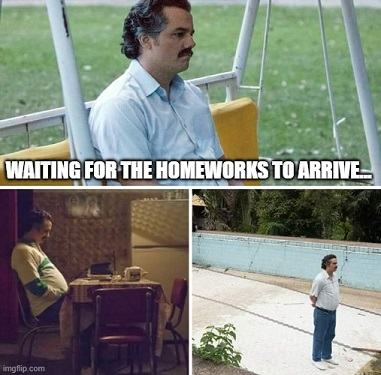